TP1 - Recalage d'images
=============

In [1]:
import numpy as np
import numpy.linalg as npl
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import cv2

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [16]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d #retourne dx*im
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dxT(im) :
    d=np.zeros(im.shape)
    d[0,:] = -im[0,:]
    d[1:-1,:] = im[:-2,:] - im[1:-1:,:]
    d[-1,:] = im[-2,:]
    return d  
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,0] = -im[:,0]
    d[:,1:-1] = im[:,:-2] - im[:,1:-1]
    d[:,-1] = im[:,-2]    
    return d

def objective_function(f,g,ux,uy,lamb,mu) :
    fu=interpol(f,ux,uy)
    R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
    E = 1/2*npl.norm(fu  - g)**2
    obj = E + R
    return obj,fu

def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   

        gradEx = (fu - g)*interpol(dx(f),ux,uy)
        gradEy = (fu - g)*interpol(dy(f),ux,uy)
        gradE = np.array([gradEx, gradEy])
        
        
        # Gradient of R at point u
        gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
        gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))
        
        
        # Gradient of E+R at point u
        gradx = gradEx + gradRx
        grady = gradEy + gradRy
        
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

#df déjà interpolé
def JPsi(vx,vy,df,lamb,mu) :
    JPsi0 = df[0]*vx+df[1]*vy
    JPsi1 = np.sqrt(mu)*dy(vx)+np.sqrt(mu)*dx(vy)
    JPsi2 = np.sqrt(mu+lamb)*dx(vx)+ np.sqrt(mu+lamb)*dy(vy)
    
    return [JPsi0,JPsi1,JPsi2]

def JTPsi(phi,df,lamb,mu) :
    ux =df[0]*phi[0]+ np.sqrt(mu)*dyT(phi[1])+ np.sqrt(mu+lamb)*dxT(phi[2])
    uy =df[1]*phi[0]+ np.sqrt(mu)*dxT(phi[1])+ np.sqrt(mu+lamb)*dyT(phi[2])

    return [ux,uy]

def JTJ(vx,vy,df,lamb,mu,epsilon) :
    J = JPsi(vx,vy,df,lamb,mu)
    JJ = JTPsi(J,df,lamb,mu)
    #JJ += epsilon*vx + epsilon*vy
    uxs = JJ[0]+epsilon*vx
    uys = JJ[1]+epsilon*vy
    
    return uxs,uys

def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)
    
   
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dfx=dx(f)
    dfy=dy(f)
    df = [dfx,dfy]
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfu=[interpol(dfx,ux,uy),interpol(dfy,ux,uy)] ##on dérive puis on interpole
        phi = [fu - g,np.sqrt(mu)*(dx(uy) + dy(ux)), np.sqrt(mu + lamb)*(dx(ux) + dy(uy))]
        b = JTPsi(phi,dfu,lamb,mu)
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,dfu)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        if (niter % 3 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter

In [53]:
def get_images():
    band1 = np.loadtxt("band1.txt")
    band2 = np.loadtxt("band2.txt")
    return band1, band2
b1,b2 = get_images()

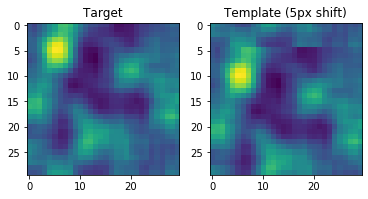

In [59]:
im1 = b2[1000:1030,500:530]
template = np.roll(target,5,axis=0)
kernel = np.ones((5,5),np.float32)/25
target = cv2.filter2D(im1,-1,kernel)

fig, ax = plt.subplots(1,2)
ax[0].imshow(target)
ax[0].set_title("Target")
ax[1].imshow(template)
ax[1].set_title("Template (5px shift)")
plt.show()


In [27]:
lamb = np.linspace(-1,1.5,10)
mu = np.copy(0.1*lamb)
nitertab = np.zeros(10)
nitermax=3000
step0 = 0.01
for i in range(10):
    ux,uy,CF,step,nitertab[i]=RecalageDG(im1,im2,lamb[i],mu[i],nitermax,step0)

iteration : 3  cost function : 3.5540562459701723 step : 0.08
iteration : 6  cost function : 3.5312078536589917 step : 0.64
iteration : 9  cost function : -31241.770331907526 step : 5.12
iteration : 12  cost function : -1.6930037046775622e+16 step : 40.96
iteration : 15  cost function : -2.642588692874432e+33 step : 327.68
iteration : 18  cost function : -1.143948776397823e+56 step : 2621.44
iteration : 21  cost function : -1.3478961330005238e+84 step : 20971.52
iteration : 24  cost function : -4.278762262069843e+117 step : 167772.16
iteration : 27  cost function : -3.638241151548837e+156 step : 1342177.28
iteration : 30  cost function : -8.257798087597762e+200 step : 10737418.24
iteration : 33  cost function : -4.991556142541813e+250 step : 85899345.92
iteration : 36  cost function : -8.022048825149176e+305 step : 687194767.36
iteration : 39  cost function : -inf step : 5497558138.88
iteration : 42  cost function : -inf step : 43980465111.04
iteration : 45  cost function : -inf step :

<ipython-input-16-a0f55e8f4051>:40: RuntimeWarning: overflow encountered in multiply
  tmpx=ux-step*descentx
<ipython-input-16-a0f55e8f4051>:41: RuntimeWarning: overflow encountered in multiply
  tmpy=uy-step*descenty
<ipython-input-16-a0f55e8f4051>:12: RuntimeWarning: invalid value encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
<ipython-input-16-a0f55e8f4051>:16: RuntimeWarning: invalid value encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]
<ipython-input-16-a0f55e8f4051>:33: RuntimeWarning: invalid value encountered in add
  R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
<ipython-input-16-a0f55e8f4051>:27: RuntimeWarning: invalid value encountered in subtract
  d[:,1:-1] = im[:,:-2] - im[:,1:-1]
<ipython-input-16-a0f55e8f4051>:68: RuntimeWarning: invalid value encountered in add
  gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
<ipython-input-16-a0f55e8f4051>:21: RuntimeWarning: invalid value encountered 

iteration : 66  cost function : nan step : 7.378697629483821e+17
iteration : 69  cost function : nan step : 5.902958103587057e+18
iteration : 72  cost function : nan step : 4.722366482869645e+19
iteration : 75  cost function : nan step : 3.777893186295716e+20
iteration : 78  cost function : nan step : 3.022314549036573e+21
iteration : 81  cost function : nan step : 2.4178516392292584e+22
iteration : 84  cost function : nan step : 1.9342813113834067e+23
iteration : 87  cost function : nan step : 1.5474250491067254e+24
iteration : 90  cost function : nan step : 1.2379400392853803e+25
iteration : 93  cost function : nan step : 9.903520314283042e+25
iteration : 96  cost function : nan step : 7.922816251426434e+26
iteration : 99  cost function : nan step : 6.338253001141147e+27
iteration : 102  cost function : nan step : 5.070602400912918e+28
iteration : 105  cost function : nan step : 4.056481920730334e+29
iteration : 108  cost function : nan step : 3.2451855365842673e+30
iteration : 111  

iteration : 444  cost function : nan step : 4.542742026847543e+131
iteration : 447  cost function : nan step : 3.6341936214780345e+132
iteration : 450  cost function : nan step : 2.9073548971824276e+133
iteration : 453  cost function : nan step : 2.325883917745942e+134
iteration : 456  cost function : nan step : 1.8607071341967537e+135
iteration : 459  cost function : nan step : 1.488565707357403e+136
iteration : 462  cost function : nan step : 1.1908525658859224e+137
iteration : 465  cost function : nan step : 9.526820527087379e+137
iteration : 468  cost function : nan step : 7.621456421669903e+138
iteration : 471  cost function : nan step : 6.097165137335922e+139
iteration : 474  cost function : nan step : 4.877732109868738e+140
iteration : 477  cost function : nan step : 3.9021856878949904e+141
iteration : 480  cost function : nan step : 3.1217485503159923e+142
iteration : 483  cost function : nan step : 2.497398840252794e+143
iteration : 486  cost function : nan step : 1.9979190722

iteration : 846  cost function : nan step : 4.692198018002938e+252
iteration : 849  cost function : nan step : 3.75375841440235e+253
iteration : 852  cost function : nan step : 3.00300673152188e+254
iteration : 855  cost function : nan step : 2.402405385217504e+255
iteration : 858  cost function : nan step : 1.9219243081740033e+256
iteration : 861  cost function : nan step : 1.5375394465392026e+257
iteration : 864  cost function : nan step : 1.2300315572313621e+258
iteration : 867  cost function : nan step : 9.840252457850897e+258
iteration : 870  cost function : nan step : 7.872201966280718e+259
iteration : 873  cost function : nan step : 6.297761573024574e+260
iteration : 876  cost function : nan step : 5.038209258419659e+261
iteration : 879  cost function : nan step : 4.0305674067357274e+262
iteration : 882  cost function : nan step : 3.224453925388582e+263
iteration : 885  cost function : nan step : 2.5795631403108655e+264
iteration : 888  cost function : nan step : 2.0636505122486

iteration : 1326  cost function : nan step : inf
iteration : 1329  cost function : nan step : inf
iteration : 1332  cost function : nan step : inf
iteration : 1335  cost function : nan step : inf
iteration : 1338  cost function : nan step : inf
iteration : 1341  cost function : nan step : inf
iteration : 1344  cost function : nan step : inf
iteration : 1347  cost function : nan step : inf
iteration : 1350  cost function : nan step : inf
iteration : 1353  cost function : nan step : inf
iteration : 1356  cost function : nan step : inf
iteration : 1359  cost function : nan step : inf
iteration : 1362  cost function : nan step : inf
iteration : 1365  cost function : nan step : inf
iteration : 1368  cost function : nan step : inf
iteration : 1371  cost function : nan step : inf
iteration : 1374  cost function : nan step : inf
iteration : 1377  cost function : nan step : inf
iteration : 1380  cost function : nan step : inf
iteration : 1383  cost function : nan step : inf
iteration : 1386  co

iteration : 1842  cost function : nan step : inf
iteration : 1845  cost function : nan step : inf
iteration : 1848  cost function : nan step : inf
iteration : 1851  cost function : nan step : inf
iteration : 1854  cost function : nan step : inf
iteration : 1857  cost function : nan step : inf
iteration : 1860  cost function : nan step : inf
iteration : 1863  cost function : nan step : inf
iteration : 1866  cost function : nan step : inf
iteration : 1869  cost function : nan step : inf
iteration : 1872  cost function : nan step : inf
iteration : 1875  cost function : nan step : inf
iteration : 1878  cost function : nan step : inf
iteration : 1881  cost function : nan step : inf
iteration : 1884  cost function : nan step : inf
iteration : 1887  cost function : nan step : inf
iteration : 1890  cost function : nan step : inf
iteration : 1893  cost function : nan step : inf
iteration : 1896  cost function : nan step : inf
iteration : 1899  cost function : nan step : inf
iteration : 1902  co

iteration : 2376  cost function : nan step : inf
iteration : 2379  cost function : nan step : inf
iteration : 2382  cost function : nan step : inf
iteration : 2385  cost function : nan step : inf
iteration : 2388  cost function : nan step : inf
iteration : 2391  cost function : nan step : inf
iteration : 2394  cost function : nan step : inf
iteration : 2397  cost function : nan step : inf
iteration : 2400  cost function : nan step : inf
iteration : 2403  cost function : nan step : inf
iteration : 2406  cost function : nan step : inf
iteration : 2409  cost function : nan step : inf
iteration : 2412  cost function : nan step : inf
iteration : 2415  cost function : nan step : inf
iteration : 2418  cost function : nan step : inf
iteration : 2421  cost function : nan step : inf
iteration : 2424  cost function : nan step : inf
iteration : 2427  cost function : nan step : inf
iteration : 2430  cost function : nan step : inf
iteration : 2433  cost function : nan step : inf
iteration : 2436  co

iteration : 2919  cost function : nan step : inf
iteration : 2922  cost function : nan step : inf
iteration : 2925  cost function : nan step : inf
iteration : 2928  cost function : nan step : inf
iteration : 2931  cost function : nan step : inf
iteration : 2934  cost function : nan step : inf
iteration : 2937  cost function : nan step : inf
iteration : 2940  cost function : nan step : inf
iteration : 2943  cost function : nan step : inf
iteration : 2946  cost function : nan step : inf
iteration : 2949  cost function : nan step : inf
iteration : 2952  cost function : nan step : inf
iteration : 2955  cost function : nan step : inf
iteration : 2958  cost function : nan step : inf
iteration : 2961  cost function : nan step : inf
iteration : 2964  cost function : nan step : inf
iteration : 2967  cost function : nan step : inf
iteration : 2970  cost function : nan step : inf
iteration : 2973  cost function : nan step : inf
iteration : 2976  cost function : nan step : inf
iteration : 2979  co

<ipython-input-16-a0f55e8f4051>:12: RuntimeWarning: overflow encountered in subtract
  d[:-1,:]=im[1:,:]-im[:-1,:]
<ipython-input-16-a0f55e8f4051>:16: RuntimeWarning: overflow encountered in subtract
  d[:,:-1]=im[:,1:]-im[:,:-1]
<ipython-input-16-a0f55e8f4051>:33: RuntimeWarning: overflow encountered in add
  R = mu/2*npl.norm(dx(uy)+dy(ux))**2 + ((lamb+mu)/2)*npl.norm(dx(ux) + dy(uy))**2
<ipython-input-16-a0f55e8f4051>:27: RuntimeWarning: overflow encountered in subtract
  d[:,1:-1] = im[:,:-2] - im[:,1:-1]
<ipython-input-16-a0f55e8f4051>:68: RuntimeWarning: overflow encountered in add
  gradRx = mu*(dyT(dy(ux)) + dyT(dx(uy))) + (lamb+mu)*(dxT(dx(ux)) + (dxT(dy(uy))))
<ipython-input-16-a0f55e8f4051>:21: RuntimeWarning: overflow encountered in subtract
  d[1:-1,:] = im[:-2,:] - im[1:-1:,:]
<ipython-input-16-a0f55e8f4051>:69: RuntimeWarning: overflow encountered in add
  gradRy = mu * (dxT(dy(ux)) + dxT(dx(uy))) + (lamb + mu)*(dyT(dx(ux)) + dyT(dy(uy)))


nan step : 9.223372036854776e+16
iteration : 66  cost function : nan step : 7.378697629483821e+17
iteration : 69  cost function : nan step : 5.902958103587057e+18
iteration : 72  cost function : nan step : 4.722366482869645e+19
iteration : 75  cost function : nan step : 3.777893186295716e+20
iteration : 78  cost function : nan step : 3.022314549036573e+21
iteration : 81  cost function : nan step : 2.4178516392292584e+22
iteration : 84  cost function : nan step : 1.9342813113834067e+23
iteration : 87  cost function : nan step : 1.5474250491067254e+24
iteration : 90  cost function : nan step : 1.2379400392853803e+25
iteration : 93  cost function : nan step : 9.903520314283042e+25
iteration : 96  cost function : nan step : 7.922816251426434e+26
iteration : 99  cost function : nan step : 6.338253001141147e+27
iteration : 102  cost function : nan step : 5.070602400912918e+28
iteration : 105  cost function : nan step : 4.056481920730334e+29
iteration : 108  cost function : nan step : 3.24518

iteration : 465  cost function : nan step : 9.526820527087379e+137
iteration : 468  cost function : nan step : 7.621456421669903e+138
iteration : 471  cost function : nan step : 6.097165137335922e+139
iteration : 474  cost function : nan step : 4.877732109868738e+140
iteration : 477  cost function : nan step : 3.9021856878949904e+141
iteration : 480  cost function : nan step : 3.1217485503159923e+142
iteration : 483  cost function : nan step : 2.497398840252794e+143
iteration : 486  cost function : nan step : 1.997919072202235e+144
iteration : 489  cost function : nan step : 1.598335257761788e+145
iteration : 492  cost function : nan step : 1.2786682062094304e+146
iteration : 495  cost function : nan step : 1.0229345649675444e+147
iteration : 498  cost function : nan step : 8.183476519740355e+147
iteration : 501  cost function : nan step : 6.546781215792284e+148
iteration : 504  cost function : nan step : 5.237424972633827e+149
iteration : 507  cost function : nan step : 4.189939978107

iteration : 864  cost function : nan step : 1.2300315572313621e+258
iteration : 867  cost function : nan step : 9.840252457850897e+258
iteration : 870  cost function : nan step : 7.872201966280718e+259
iteration : 873  cost function : nan step : 6.297761573024574e+260
iteration : 876  cost function : nan step : 5.038209258419659e+261
iteration : 879  cost function : nan step : 4.0305674067357274e+262
iteration : 882  cost function : nan step : 3.224453925388582e+263
iteration : 885  cost function : nan step : 2.5795631403108655e+264
iteration : 888  cost function : nan step : 2.0636505122486924e+265
iteration : 891  cost function : nan step : 1.650920409798954e+266
iteration : 894  cost function : nan step : 1.3207363278391631e+267
iteration : 897  cost function : nan step : 1.0565890622713305e+268
iteration : 900  cost function : nan step : 8.452712498170644e+268
iteration : 903  cost function : nan step : 6.762169998536515e+269
iteration : 906  cost function : nan step : 5.4097359988

iteration : 1347  cost function : nan step : inf
iteration : 1350  cost function : nan step : inf
iteration : 1353  cost function : nan step : inf
iteration : 1356  cost function : nan step : inf
iteration : 1359  cost function : nan step : inf
iteration : 1362  cost function : nan step : inf
iteration : 1365  cost function : nan step : inf
iteration : 1368  cost function : nan step : inf
iteration : 1371  cost function : nan step : inf
iteration : 1374  cost function : nan step : inf
iteration : 1377  cost function : nan step : inf
iteration : 1380  cost function : nan step : inf
iteration : 1383  cost function : nan step : inf
iteration : 1386  cost function : nan step : inf
iteration : 1389  cost function : nan step : inf
iteration : 1392  cost function : nan step : inf
iteration : 1395  cost function : nan step : inf
iteration : 1398  cost function : nan step : inf
iteration : 1401  cost function : nan step : inf
iteration : 1404  cost function : nan step : inf
iteration : 1407  co

iteration : 1905  cost function : nan step : inf
iteration : 1908  cost function : nan step : inf
iteration : 1911  cost function : nan step : inf
iteration : 1914  cost function : nan step : inf
iteration : 1917  cost function : nan step : inf
iteration : 1920  cost function : nan step : inf
iteration : 1923  cost function : nan step : inf
iteration : 1926  cost function : nan step : inf
iteration : 1929  cost function : nan step : inf
iteration : 1932  cost function : nan step : inf
iteration : 1935  cost function : nan step : inf
iteration : 1938  cost function : nan step : inf
iteration : 1941  cost function : nan step : inf
iteration : 1944  cost function : nan step : inf
iteration : 1947  cost function : nan step : inf
iteration : 1950  cost function : nan step : inf
iteration : 1953  cost function : nan step : inf
iteration : 1956  cost function : nan step : inf
iteration : 1959  cost function : nan step : inf
iteration : 1962  cost function : nan step : inf
iteration : 1965  co

iteration : 2442  cost function : nan step : inf
iteration : 2445  cost function : nan step : inf
iteration : 2448  cost function : nan step : inf
iteration : 2451  cost function : nan step : inf
iteration : 2454  cost function : nan step : inf
iteration : 2457  cost function : nan step : inf
iteration : 2460  cost function : nan step : inf
iteration : 2463  cost function : nan step : inf
iteration : 2466  cost function : nan step : inf
iteration : 2469  cost function : nan step : inf
iteration : 2472  cost function : nan step : inf
iteration : 2475  cost function : nan step : inf
iteration : 2478  cost function : nan step : inf
iteration : 2481  cost function : nan step : inf
iteration : 2484  cost function : nan step : inf
iteration : 2487  cost function : nan step : inf
iteration : 2490  cost function : nan step : inf
iteration : 2493  cost function : nan step : inf
iteration : 2496  cost function : nan step : inf
iteration : 2499  cost function : nan step : inf
iteration : 2502  co

iteration : 2997  cost function : nan step : inf
iteration : 3000  cost function : nan step : inf
iteration : 3  cost function : 3.5540761143716773 step : 0.08
iteration : 6  cost function : 3.547129821685824 step : 0.64
iteration : 9  cost function : -65.2069820455841 step : 5.12
iteration : 12  cost function : -270395225547.18726 step : 40.96
iteration : 15  cost function : -3.170704687218731e+26 step : 327.68
iteration : 18  cost function : -1.0401101820635298e+47 step : 2621.44
iteration : 21  cost function : -9.336673674939135e+72 step : 20971.52
iteration : 24  cost function : -2.2646594925027e+104 step : 167772.16
iteration : 27  cost function : -1.473883916648763e+141 step : 1342177.28
iteration : 30  cost function : -2.5631988288196107e+183 step : 10737418.24
iteration : 33  cost function : -1.1879893747716455e+231 step : 85899345.92
iteration : 36  cost function : -1.464707712361788e+284 step : 687194767.36
iteration : 39  cost function : -inf step : 5497558138.88
iteration :

iteration : 423  cost function : nan step : 2.1661481985318867e+125
iteration : 426  cost function : nan step : 1.7329185588255093e+126
iteration : 429  cost function : nan step : 1.3863348470604075e+127
iteration : 432  cost function : nan step : 1.109067877648326e+128
iteration : 435  cost function : nan step : 8.872543021186608e+128
iteration : 438  cost function : nan step : 7.098034416949286e+129
iteration : 441  cost function : nan step : 5.678427533559429e+130
iteration : 444  cost function : nan step : 4.542742026847543e+131
iteration : 447  cost function : nan step : 3.6341936214780345e+132
iteration : 450  cost function : nan step : 2.9073548971824276e+133
iteration : 453  cost function : nan step : 2.325883917745942e+134
iteration : 456  cost function : nan step : 1.8607071341967537e+135
iteration : 459  cost function : nan step : 1.488565707357403e+136
iteration : 462  cost function : nan step : 1.1908525658859224e+137
iteration : 465  cost function : nan step : 9.526820527

iteration : 846  cost function : nan step : 4.692198018002938e+252
iteration : 849  cost function : nan step : 3.75375841440235e+253
iteration : 852  cost function : nan step : 3.00300673152188e+254
iteration : 855  cost function : nan step : 2.402405385217504e+255
iteration : 858  cost function : nan step : 1.9219243081740033e+256
iteration : 861  cost function : nan step : 1.5375394465392026e+257
iteration : 864  cost function : nan step : 1.2300315572313621e+258
iteration : 867  cost function : nan step : 9.840252457850897e+258
iteration : 870  cost function : nan step : 7.872201966280718e+259
iteration : 873  cost function : nan step : 6.297761573024574e+260
iteration : 876  cost function : nan step : 5.038209258419659e+261
iteration : 879  cost function : nan step : 4.0305674067357274e+262
iteration : 882  cost function : nan step : 3.224453925388582e+263
iteration : 885  cost function : nan step : 2.5795631403108655e+264
iteration : 888  cost function : nan step : 2.0636505122486

iteration : 1341  cost function : nan step : inf
iteration : 1344  cost function : nan step : inf
iteration : 1347  cost function : nan step : inf
iteration : 1350  cost function : nan step : inf
iteration : 1353  cost function : nan step : inf
iteration : 1356  cost function : nan step : inf
iteration : 1359  cost function : nan step : inf
iteration : 1362  cost function : nan step : inf
iteration : 1365  cost function : nan step : inf
iteration : 1368  cost function : nan step : inf
iteration : 1371  cost function : nan step : inf
iteration : 1374  cost function : nan step : inf
iteration : 1377  cost function : nan step : inf
iteration : 1380  cost function : nan step : inf
iteration : 1383  cost function : nan step : inf
iteration : 1386  cost function : nan step : inf
iteration : 1389  cost function : nan step : inf
iteration : 1392  cost function : nan step : inf
iteration : 1395  cost function : nan step : inf
iteration : 1398  cost function : nan step : inf
iteration : 1401  co

iteration : 1893  cost function : nan step : inf
iteration : 1896  cost function : nan step : inf
iteration : 1899  cost function : nan step : inf
iteration : 1902  cost function : nan step : inf
iteration : 1905  cost function : nan step : inf
iteration : 1908  cost function : nan step : inf
iteration : 1911  cost function : nan step : inf
iteration : 1914  cost function : nan step : inf
iteration : 1917  cost function : nan step : inf
iteration : 1920  cost function : nan step : inf
iteration : 1923  cost function : nan step : inf
iteration : 1926  cost function : nan step : inf
iteration : 1929  cost function : nan step : inf
iteration : 1932  cost function : nan step : inf
iteration : 1935  cost function : nan step : inf
iteration : 1938  cost function : nan step : inf
iteration : 1941  cost function : nan step : inf
iteration : 1944  cost function : nan step : inf
iteration : 1947  cost function : nan step : inf
iteration : 1950  cost function : nan step : inf
iteration : 1953  co

iteration : 2418  cost function : nan step : inf
iteration : 2421  cost function : nan step : inf
iteration : 2424  cost function : nan step : inf
iteration : 2427  cost function : nan step : inf
iteration : 2430  cost function : nan step : inf
iteration : 2433  cost function : nan step : inf
iteration : 2436  cost function : nan step : inf
iteration : 2439  cost function : nan step : inf
iteration : 2442  cost function : nan step : inf
iteration : 2445  cost function : nan step : inf
iteration : 2448  cost function : nan step : inf
iteration : 2451  cost function : nan step : inf
iteration : 2454  cost function : nan step : inf
iteration : 2457  cost function : nan step : inf
iteration : 2460  cost function : nan step : inf
iteration : 2463  cost function : nan step : inf
iteration : 2466  cost function : nan step : inf
iteration : 2469  cost function : nan step : inf
iteration : 2472  cost function : nan step : inf
iteration : 2475  cost function : nan step : inf
iteration : 2478  co

iteration : 2988  cost function : nan step : inf
iteration : 2991  cost function : nan step : inf
iteration : 2994  cost function : nan step : inf
iteration : 2997  cost function : nan step : inf
iteration : 3000  cost function : nan step : inf
iteration : 3  cost function : 3.5540853066724876 step : 0.08
iteration : 6  cost function : 3.5495659631495853 step : 0.64
iteration : 9  cost function : 3.030972438818896 step : 5.12
iteration : 12  cost function : -4735146.815687289 step : 40.96
iteration : 15  cost function : -1.4873680537960503e+19 step : 327.68
iteration : 18  cost function : -1.3240160898245242e+37 step : 2621.44
iteration : 21  cost function : -3.2516235411701544e+60 step : 20971.52
iteration : 24  cost function : -2.1678664777977278e+89 step : 167772.16
iteration : 27  cost function : -3.888219366821504e+123 step : 1342177.28
iteration : 30  cost function : -1.86641545297486e+163 step : 10737418.24
iteration : 33  cost function : -2.3901347980872563e+208 step : 85899345

iteration : 399  cost function : nan step : 1.2911249390434543e+118
iteration : 402  cost function : nan step : 1.0328999512347635e+119
iteration : 405  cost function : nan step : 8.263199609878108e+119
iteration : 408  cost function : nan step : 6.610559687902486e+120
iteration : 411  cost function : nan step : 5.288447750321989e+121
iteration : 414  cost function : nan step : 4.230758200257591e+122
iteration : 417  cost function : nan step : 3.384606560206073e+123
iteration : 420  cost function : nan step : 2.7076852481648583e+124
iteration : 423  cost function : nan step : 2.1661481985318867e+125
iteration : 426  cost function : nan step : 1.7329185588255093e+126
iteration : 429  cost function : nan step : 1.3863348470604075e+127
iteration : 432  cost function : nan step : 1.109067877648326e+128
iteration : 435  cost function : nan step : 8.872543021186608e+128
iteration : 438  cost function : nan step : 7.098034416949286e+129
iteration : 441  cost function : nan step : 5.6784275335

iteration : 825  cost function : nan step : 2.2374143686308564e+246
iteration : 828  cost function : nan step : 1.789931494904685e+247
iteration : 831  cost function : nan step : 1.431945195923748e+248
iteration : 834  cost function : nan step : 1.1455561567389985e+249
iteration : 837  cost function : nan step : 9.164449253911988e+249
iteration : 840  cost function : nan step : 7.33155940312959e+250
iteration : 843  cost function : nan step : 5.865247522503672e+251
iteration : 846  cost function : nan step : 4.692198018002938e+252
iteration : 849  cost function : nan step : 3.75375841440235e+253
iteration : 852  cost function : nan step : 3.00300673152188e+254
iteration : 855  cost function : nan step : 2.402405385217504e+255
iteration : 858  cost function : nan step : 1.9219243081740033e+256
iteration : 861  cost function : nan step : 1.5375394465392026e+257
iteration : 864  cost function : nan step : 1.2300315572313621e+258
iteration : 867  cost function : nan step : 9.84025245785089

iteration : 1251  cost function : nan step : inf
iteration : 1254  cost function : nan step : inf
iteration : 1257  cost function : nan step : inf
iteration : 1260  cost function : nan step : inf
iteration : 1263  cost function : nan step : inf
iteration : 1266  cost function : nan step : inf
iteration : 1269  cost function : nan step : inf
iteration : 1272  cost function : nan step : inf
iteration : 1275  cost function : nan step : inf
iteration : 1278  cost function : nan step : inf
iteration : 1281  cost function : nan step : inf
iteration : 1284  cost function : nan step : inf
iteration : 1287  cost function : nan step : inf
iteration : 1290  cost function : nan step : inf
iteration : 1293  cost function : nan step : inf
iteration : 1296  cost function : nan step : inf
iteration : 1299  cost function : nan step : inf
iteration : 1302  cost function : nan step : inf
iteration : 1305  cost function : nan step : inf
iteration : 1308  cost function : nan step : inf
iteration : 1311  co

iteration : 1818  cost function : nan step : inf
iteration : 1821  cost function : nan step : inf
iteration : 1824  cost function : nan step : inf
iteration : 1827  cost function : nan step : inf
iteration : 1830  cost function : nan step : inf
iteration : 1833  cost function : nan step : inf
iteration : 1836  cost function : nan step : inf
iteration : 1839  cost function : nan step : inf
iteration : 1842  cost function : nan step : inf
iteration : 1845  cost function : nan step : inf
iteration : 1848  cost function : nan step : inf
iteration : 1851  cost function : nan step : inf
iteration : 1854  cost function : nan step : inf
iteration : 1857  cost function : nan step : inf
iteration : 1860  cost function : nan step : inf
iteration : 1863  cost function : nan step : inf
iteration : 1866  cost function : nan step : inf
iteration : 1869  cost function : nan step : inf
iteration : 1872  cost function : nan step : inf
iteration : 1875  cost function : nan step : inf
iteration : 1878  co

iteration : 2328  cost function : nan step : inf
iteration : 2331  cost function : nan step : inf
iteration : 2334  cost function : nan step : inf
iteration : 2337  cost function : nan step : inf
iteration : 2340  cost function : nan step : inf
iteration : 2343  cost function : nan step : inf
iteration : 2346  cost function : nan step : inf
iteration : 2349  cost function : nan step : inf
iteration : 2352  cost function : nan step : inf
iteration : 2355  cost function : nan step : inf
iteration : 2358  cost function : nan step : inf
iteration : 2361  cost function : nan step : inf
iteration : 2364  cost function : nan step : inf
iteration : 2367  cost function : nan step : inf
iteration : 2370  cost function : nan step : inf
iteration : 2373  cost function : nan step : inf
iteration : 2376  cost function : nan step : inf
iteration : 2379  cost function : nan step : inf
iteration : 2382  cost function : nan step : inf
iteration : 2385  cost function : nan step : inf
iteration : 2388  co

iteration : 2883  cost function : nan step : inf
iteration : 2886  cost function : nan step : inf
iteration : 2889  cost function : nan step : inf
iteration : 2892  cost function : nan step : inf
iteration : 2895  cost function : nan step : inf
iteration : 2898  cost function : nan step : inf
iteration : 2901  cost function : nan step : inf
iteration : 2904  cost function : nan step : inf
iteration : 2907  cost function : nan step : inf
iteration : 2910  cost function : nan step : inf
iteration : 2913  cost function : nan step : inf
iteration : 2916  cost function : nan step : inf
iteration : 2919  cost function : nan step : inf
iteration : 2922  cost function : nan step : inf
iteration : 2925  cost function : nan step : inf
iteration : 2928  cost function : nan step : inf
iteration : 2931  cost function : nan step : inf
iteration : 2934  cost function : nan step : inf
iteration : 2937  cost function : nan step : inf
iteration : 2940  cost function : nan step : inf
iteration : 2943  co

iteration : 309  cost function : 3.2423544882788518 step : 2.56
iteration : 312  cost function : 3.2409713712227544 step : 2.56
iteration : 315  cost function : 3.239546811583407 step : 1.28
iteration : 318  cost function : 3.2381890920918464 step : 1.28
iteration : 321  cost function : 3.23678813098293 step : 1.28
iteration : 324  cost function : 3.235457106844039 step : 1.28
iteration : 327  cost function : 3.2340814227709513 step : 1.28
iteration : 330  cost function : 3.232779204715738 step : 1.28
iteration : 333  cost function : 3.2314314964826565 step : 1.28
iteration : 336  cost function : 3.2301613967823215 step : 1.28
iteration : 339  cost function : 3.2288457546901945 step : 1.28
iteration : 342  cost function : 3.226998328065695 step : 2.56
iteration : 345  cost function : 3.225624650700695 step : 2.56
iteration : 348  cost function : 3.224269929731229 step : 2.56
iteration : 351  cost function : 3.222906562870947 step : 2.56
iteration : 354  cost function : 3.22156248557442

iteration : 717  cost function : 3.0842886824547335 step : 2.56
iteration : 720  cost function : 3.083294172240371 step : 2.56
iteration : 723  cost function : 3.0822581720254556 step : 1.28
iteration : 726  cost function : 3.0812837685534684 step : 1.28
iteration : 729  cost function : 3.080262597641174 step : 1.28
iteration : 732  cost function : 3.079313081676877 step : 1.28
iteration : 735  cost function : 3.0783107538056904 step : 1.28
iteration : 738  cost function : 3.0773917599534912 step : 1.28
iteration : 741  cost function : 3.076413404487399 step : 1.28
iteration : 744  cost function : 3.0751794433251183 step : 2.56
iteration : 747  cost function : 3.0745839793983283 step : 1.28
iteration : 750  cost function : 3.07322113812231 step : 2.56
iteration : 753  cost function : 3.0722451753790163 step : 2.56
iteration : 756  cost function : 3.0713012152229795 step : 2.56
iteration : 759  cost function : 3.0703432096644185 step : 2.56
iteration : 762  cost function : 3.06942057016

iteration : 1122  cost function : 2.98494864234571 step : 2.56
iteration : 1125  cost function : 2.9843195433887 step : 1.28
iteration : 1128  cost function : 2.9837006200371663 step : 1.28
iteration : 1131  cost function : 2.983043819092231 step : 1.28
iteration : 1134  cost function : 2.982402842528203 step : 1.28
iteration : 1137  cost function : 2.98172308730029 step : 1.28
iteration : 1140  cost function : 2.9810670335200635 step : 1.28
iteration : 1143  cost function : 2.98037437359238 step : 1.28
iteration : 1146  cost function : 2.979715189800349 step : 1.28
iteration : 1149  cost function : 2.9790215578723975 step : 1.28
iteration : 1152  cost function : 2.978006914121832 step : 2.56
iteration : 1155  cost function : 2.977268730005695 step : 2.56
iteration : 1158  cost function : 2.976541615352439 step : 2.56
iteration : 1161  cost function : 2.975808632780701 step : 2.56
iteration : 1164  cost function : 2.9750914924354097 step : 2.56
iteration : 1167  cost function : 2.97437

iteration : 1518  cost function : 2.914564067536654 step : 2.56
iteration : 1521  cost function : 2.9140884059676306 step : 2.56
iteration : 1524  cost function : 2.913621756913266 step : 2.56
iteration : 1527  cost function : 2.9131437787430587 step : 1.28
iteration : 1530  cost function : 2.9126756314036806 step : 1.28
iteration : 1533  cost function : 2.9121957805852823 step : 1.28
iteration : 1536  cost function : 2.9117267238267823 step : 1.28
iteration : 1539  cost function : 2.9112457256391298 step : 1.28
iteration : 1542  cost function : 2.910776553178173 step : 1.28
iteration : 1545  cost function : 2.9102954026060854 step : 1.28
iteration : 1548  cost function : 2.9098271790149663 step : 1.28
iteration : 1551  cost function : 2.9091296474052704 step : 2.56
iteration : 1554  cost function : 2.908611897901476 step : 2.56
iteration : 1557  cost function : 2.9080861333437675 step : 2.56
iteration : 1560  cost function : 2.9075573306363274 step : 2.56
iteration : 1563  cost functi

iteration : 1926  cost function : 2.763107949706184 step : 2.56
iteration : 1929  cost function : 2.762200874158232 step : 2.56
iteration : 1932  cost function : 2.7613299220034158 step : 2.56
iteration : 1935  cost function : 2.7604497404966883 step : 2.56
iteration : 1938  cost function : 2.759611697858481 step : 2.56
iteration : 1941  cost function : 2.7587630916562937 step : 2.56
iteration : 1944  cost function : 2.7579627293488174 step : 2.56
iteration : 1947  cost function : 2.7571497715954427 step : 1.28
iteration : 1950  cost function : 2.7563913668073545 step : 1.28
iteration : 1953  cost function : 2.7556170631943266 step : 1.28
iteration : 1956  cost function : 2.754903665628488 step : 1.28
iteration : 1959  cost function : 2.75416996481599 step : 1.28
iteration : 1962  cost function : 2.753504077782451 step : 1.28
iteration : 1965  cost function : 2.7528126983632677 step : 1.28
iteration : 1968  cost function : 2.751835253407838 step : 2.56
iteration : 1971  cost function :

iteration : 2340  cost function : 2.701766858382054 step : 1.28
iteration : 2343  cost function : 2.7014562883687456 step : 1.28
iteration : 2346  cost function : 2.7011711092190165 step : 1.28
iteration : 2349  cost function : 2.700864919994553 step : 1.28
iteration : 2352  cost function : 2.700477934086874 step : 2.56
iteration : 2355  cost function : 2.7002875398256165 step : 1.28
iteration : 2358  cost function : 2.69985667338766 step : 2.56
iteration : 2361  cost function : 2.699543667984018 step : 2.56
iteration : 2364  cost function : 2.6992385856622074 step : 2.56
iteration : 2367  cost function : 2.69892672460713 step : 2.56
iteration : 2370  cost function : 2.698623883179526 step : 2.56
iteration : 2373  cost function : 2.698313226391172 step : 2.56
iteration : 2376  cost function : 2.698012875623764 step : 2.56
iteration : 2379  cost function : 2.6977035799807165 step : 2.56
iteration : 2382  cost function : 2.6974060443110037 step : 2.56
iteration : 2385  cost function : 2.

iteration : 2739  cost function : 2.6645118368828973 step : 1.28
iteration : 2742  cost function : 2.664269705916224 step : 1.28
iteration : 2745  cost function : 2.6640115172334182 step : 1.28
iteration : 2748  cost function : 2.6637739995038254 step : 1.28
iteration : 2751  cost function : 2.663518272567028 step : 1.28
iteration : 2754  cost function : 2.6632865608689618 step : 1.28
iteration : 2757  cost function : 2.6630342501862887 step : 1.28
iteration : 2760  cost function : 2.662685887325794 step : 2.56
iteration : 2763  cost function : 2.6624239368227163 step : 2.56
iteration : 2766  cost function : 2.6621682247761194 step : 2.56
iteration : 2769  cost function : 2.661906339513823 step : 2.56
iteration : 2772  cost function : 2.6616516384792788 step : 2.56
iteration : 2775  cost function : 2.6613898683059274 step : 2.56
iteration : 2778  cost function : 2.6611363796647494 step : 2.56
iteration : 2781  cost function : 2.66087480448502 step : 2.56
iteration : 2784  cost function

iteration : 171  cost function : 3.4470424662856427 step : 1.28
iteration : 174  cost function : 3.4460509657005023 step : 1.28
iteration : 177  cost function : 3.4450525584217684 step : 1.28
iteration : 180  cost function : 3.4440796882479083 step : 0.64
iteration : 183  cost function : 3.4433606332958075 step : 0.64
iteration : 186  cost function : 3.442556403807841 step : 0.64
iteration : 189  cost function : 3.441592565817064 step : 0.64
iteration : 192  cost function : 3.4406491239401977 step : 0.64
iteration : 195  cost function : 3.4397013806028514 step : 0.64
iteration : 198  cost function : 3.438773995867722 step : 0.64
iteration : 201  cost function : 3.4378434863754204 step : 0.64
iteration : 204  cost function : 3.4369320185815107 step : 0.64
iteration : 207  cost function : 3.4360177556212026 step : 0.64
iteration : 210  cost function : 3.435121280308969 step : 0.64
iteration : 213  cost function : 3.434222593958 step : 0.64
iteration : 216  cost function : 3.4333405566886

iteration : 561  cost function : 3.359098498605177 step : 1.28
iteration : 564  cost function : 3.358614353278422 step : 1.28
iteration : 567  cost function : 3.358131867809249 step : 1.28
iteration : 570  cost function : 3.3576521885487476 step : 0.64
iteration : 573  cost function : 3.357174177222463 step : 0.64
iteration : 576  cost function : 3.356698900743929 step : 0.64
iteration : 579  cost function : 3.3562252951397236 step : 0.64
iteration : 582  cost function : 3.355754354643013 step : 0.64
iteration : 585  cost function : 3.355285086524683 step : 0.64
iteration : 588  cost function : 3.3548184138363135 step : 0.64
iteration : 591  cost function : 3.3543534126942416 step : 0.64
iteration : 594  cost function : 3.353890938194508 step : 0.64
iteration : 597  cost function : 3.3534301323609266 step : 0.64
iteration : 600  cost function : 3.3529717854047636 step : 0.64
iteration : 603  cost function : 3.3525151024383515 step : 0.64
iteration : 606  cost function : 3.3520608117128

iteration : 990  cost function : 3.305331325896983 step : 1.28
iteration : 993  cost function : 3.305030231228265 step : 1.28
iteration : 996  cost function : 3.30472928061026 step : 1.28
iteration : 999  cost function : 3.3044296946744187 step : 1.28
iteration : 1002  cost function : 3.3041302493559894 step : 1.28
iteration : 1005  cost function : 3.3038321531129364 step : 1.28
iteration : 1008  cost function : 3.303534193564224 step : 1.28
iteration : 1011  cost function : 3.3032375674113448 step : 1.28
iteration : 1014  cost function : 3.302941074297283 step : 1.28
iteration : 1017  cost function : 3.3026458989242764 step : 1.28
iteration : 1020  cost function : 3.302350853197437 step : 1.28
iteration : 1023  cost function : 3.302057109591288 step : 1.28
iteration : 1026  cost function : 3.301763492493555 step : 1.28
iteration : 1029  cost function : 3.3014711619379207 step : 1.28
iteration : 1032  cost function : 3.3011789549990302 step : 1.28
iteration : 1035  cost function : 3.30

iteration : 1380  cost function : 3.2712852972622577 step : 0.32
iteration : 1383  cost function : 3.271055270836735 step : 0.32
iteration : 1386  cost function : 3.270823815116302 step : 0.32
iteration : 1389  cost function : 3.270594613242071 step : 0.32
iteration : 1392  cost function : 3.270364021329341 step : 0.32
iteration : 1395  cost function : 3.270135635608124 step : 0.32
iteration : 1398  cost function : 3.2699058991306984 step : 0.32
iteration : 1401  cost function : 3.269678321168988 step : 0.32
iteration : 1404  cost function : 3.26944943177951 step : 0.32
iteration : 1407  cost function : 3.2692226532334807 step : 0.32
iteration : 1410  cost function : 3.268994602608595 step : 0.32
iteration : 1413  cost function : 3.268768615182402 step : 0.32
iteration : 1416  cost function : 3.268541395033523 step : 0.32
iteration : 1419  cost function : 3.2683161905049314 step : 0.64
iteration : 1422  cost function : 3.268094185997482 step : 1.28
iteration : 1425  cost function : 3.2

iteration : 1770  cost function : 3.244199245584172 step : 0.32
iteration : 1773  cost function : 3.244006005625613 step : 0.32
iteration : 1776  cost function : 3.2438134945245314 step : 0.32
iteration : 1779  cost function : 3.24362062148781 step : 0.32
iteration : 1782  cost function : 3.243427163287151 step : 0.32
iteration : 1785  cost function : 3.243232519093943 step : 0.32
iteration : 1788  cost function : 3.2430383314534152 step : 0.32
iteration : 1791  cost function : 3.242844056832481 step : 0.32
iteration : 1794  cost function : 3.2426502780520443 step : 0.32
iteration : 1797  cost function : 3.2424563674099627 step : 0.32
iteration : 1800  cost function : 3.242262989998363 step : 0.32
iteration : 1803  cost function : 3.24206943742235 step : 0.32
iteration : 1806  cost function : 3.241876454350354 step : 0.32
iteration : 1809  cost function : 3.2416832544420817 step : 0.32
iteration : 1812  cost function : 3.2414906591721677 step : 0.32
iteration : 1815  cost function : 3.

iteration : 2190  cost function : 3.2182040198292343 step : 0.32
iteration : 2193  cost function : 3.218024156328604 step : 0.32
iteration : 2196  cost function : 3.217846992362254 step : 0.32
iteration : 2199  cost function : 3.217667536348508 step : 0.32
iteration : 2202  cost function : 3.2174907738064285 step : 0.32
iteration : 2205  cost function : 3.217311733545002 step : 0.32
iteration : 2208  cost function : 3.217135380600165 step : 0.32
iteration : 2211  cost function : 3.2169567645024006 step : 0.32
iteration : 2214  cost function : 3.216780829453994 step : 0.32
iteration : 2217  cost function : 3.2166026460708537 step : 0.32
iteration : 2220  cost function : 3.2164271373394833 step : 0.32
iteration : 2223  cost function : 3.2162493953568907 step : 0.32
iteration : 2226  cost function : 3.216074321481684 step : 0.32
iteration : 2229  cost function : 3.2158970297179086 step : 0.32
iteration : 2232  cost function : 3.2157223993558426 step : 0.32
iteration : 2235  cost function 

iteration : 2613  cost function : 3.192363057811024 step : 0.32
iteration : 2616  cost function : 3.1921812775824585 step : 0.32
iteration : 2619  cost function : 3.1919913888172884 step : 0.32
iteration : 2622  cost function : 3.191809696335941 step : 0.32
iteration : 2625  cost function : 3.1916199509156122 step : 0.32
iteration : 2628  cost function : 3.191438342253283 step : 0.32
iteration : 2631  cost function : 3.191248736458981 step : 0.32
iteration : 2634  cost function : 3.1910672076187785 step : 0.32
iteration : 2637  cost function : 3.19087773764176 step : 0.32
iteration : 2640  cost function : 3.1906962845616866 step : 0.32
iteration : 2643  cost function : 3.190506946508099 step : 0.32
iteration : 2646  cost function : 3.1903255651370577 step : 0.32
iteration : 2649  cost function : 3.190136355488621 step : 0.32
iteration : 2652  cost function : 3.1899550426911447 step : 0.32
iteration : 2655  cost function : 3.189765958767519 step : 0.32
iteration : 2658  cost function : 

iteration : 12  cost function : 3.5384238750753925 step : 0.64
iteration : 15  cost function : 3.536448658377735 step : 0.32
iteration : 18  cost function : 3.5348381505215056 step : 0.32
iteration : 21  cost function : 3.5337048370876567 step : 0.32
iteration : 24  cost function : 3.5320792599950446 step : 0.32
iteration : 27  cost function : 3.5302842142659667 step : 0.32
iteration : 30  cost function : 3.5289891453256095 step : 0.32
iteration : 33  cost function : 3.5275452533240843 step : 0.32
iteration : 36  cost function : 3.5263684019357457 step : 0.32
iteration : 39  cost function : 3.525104963843095 step : 0.32
iteration : 42  cost function : 3.5240026483711313 step : 0.32
iteration : 45  cost function : 3.5228644175849038 step : 0.32
iteration : 48  cost function : 3.521822139808312 step : 0.32
iteration : 51  cost function : 3.5207811567637526 step : 0.32
iteration : 54  cost function : 3.519795404218307 step : 0.32
iteration : 57  cost function : 3.518842751808655 step : 0.

iteration : 408  cost function : 3.4470288213369287 step : 0.32
iteration : 411  cost function : 3.4467897160229297 step : 0.32
iteration : 414  cost function : 3.4465793658530752 step : 0.32
iteration : 417  cost function : 3.4464120683667416 step : 0.32
iteration : 420  cost function : 3.4462917163268165 step : 0.32
iteration : 423  cost function : 3.446239485341672 step : 0.32
iteration : 426  cost function : 3.444620987414143 step : 0.64
iteration : 429  cost function : 3.4441863784127578 step : 0.32
iteration : 432  cost function : 3.4439470081858077 step : 0.32
iteration : 435  cost function : 3.443739089428807 step : 0.32
iteration : 438  cost function : 3.443564771343369 step : 0.32
iteration : 441  cost function : 3.443439947527146 step : 0.32
iteration : 444  cost function : 3.443370047146328 step : 0.32
iteration : 447  cost function : 3.4418773639272193 step : 0.32
iteration : 450  cost function : 3.4414348364209184 step : 0.32
iteration : 453  cost function : 3.44119928592

iteration : 810  cost function : 3.4056401701299532 step : 0.32
iteration : 813  cost function : 3.4055890059128866 step : 0.32
iteration : 816  cost function : 3.405576269955294 step : 0.16
iteration : 819  cost function : 3.404441871844354 step : 1.28
iteration : 822  cost function : 3.404271489458025 step : 0.32
iteration : 825  cost function : 3.404136953034967 step : 0.32
iteration : 828  cost function : 3.4040185825999214 step : 0.32
iteration : 831  cost function : 3.4039279623149152 step : 0.32
iteration : 834  cost function : 3.403864375693178 step : 0.32
iteration : 837  cost function : 3.4038444590818204 step : 0.16
iteration : 840  cost function : 3.4027899099486514 step : 1.28
iteration : 843  cost function : 3.4026100930938203 step : 0.32
iteration : 846  cost function : 3.4024717411983687 step : 0.32
iteration : 849  cost function : 3.4023538757990592 step : 0.32
iteration : 852  cost function : 3.4022549733972953 step : 0.32
iteration : 855  cost function : 3.4021880853

iteration : 1212  cost function : 3.378393667392625 step : 0.64
iteration : 1215  cost function : 3.378200520026766 step : 0.32
iteration : 1218  cost function : 3.378092045308316 step : 0.32
iteration : 1221  cost function : 3.3779983589470866 step : 0.32
iteration : 1224  cost function : 3.3779184718066375 step : 0.32
iteration : 1227  cost function : 3.37786184398979 step : 0.32
iteration : 1230  cost function : 3.377828499847284 step : 0.32
iteration : 1233  cost function : 3.377146583625576 step : 0.32
iteration : 1236  cost function : 3.376940822608315 step : 0.32
iteration : 1239  cost function : 3.3768313430592665 step : 0.32
iteration : 1242  cost function : 3.3767315417773522 step : 0.32
iteration : 1245  cost function : 3.376648683859559 step : 0.32
iteration : 1248  cost function : 3.3765822349321537 step : 0.32
iteration : 1251  cost function : 3.376542537892897 step : 0.32
iteration : 1254  cost function : 3.3765304141216754 step : 0.16
iteration : 1257  cost function : 3

iteration : 1608  cost function : 3.3563659378358146 step : 1.28
iteration : 1611  cost function : 3.356239997511306 step : 0.32
iteration : 1614  cost function : 3.356147143358529 step : 0.32
iteration : 1617  cost function : 3.3560649204074067 step : 0.32
iteration : 1620  cost function : 3.355997127878379 step : 0.32
iteration : 1623  cost function : 3.35594664991318 step : 0.32
iteration : 1626  cost function : 3.355919491426432 step : 0.32
iteration : 1629  cost function : 3.355330440813964 step : 0.64
iteration : 1632  cost function : 3.355153599020373 step : 0.32
iteration : 1635  cost function : 3.3550583431350804 step : 0.32
iteration : 1638  cost function : 3.354973640024289 step : 0.32
iteration : 1641  cost function : 3.354901181740126 step : 0.32
iteration : 1644  cost function : 3.3548456947908245 step : 0.32
iteration : 1647  cost function : 3.354810220392539 step : 0.32
iteration : 1650  cost function : 3.3542638251551753 step : 0.32
iteration : 1653  cost function : 3.

iteration : 2010  cost function : 3.3377130311475427 step : 0.32
iteration : 2013  cost function : 3.337644953175647 step : 0.32
iteration : 2016  cost function : 3.337591747508535 step : 0.32
iteration : 2019  cost function : 3.3375506991474375 step : 0.32
iteration : 2022  cost function : 3.337532857295638 step : 0.32
iteration : 2025  cost function : 3.337027101298369 step : 0.64
iteration : 2028  cost function : 3.3368840937912387 step : 0.32
iteration : 2031  cost function : 3.3368048085039845 step : 0.32
iteration : 2034  cost function : 3.3367366485615957 step : 0.32
iteration : 2037  cost function : 3.33667672127768 step : 0.32
iteration : 2040  cost function : 3.3366340133095345 step : 0.32
iteration : 2043  cost function : 3.336605609161346 step : 0.32
iteration : 2046  cost function : 3.336138223872304 step : 0.32
iteration : 2049  cost function : 3.335986818415341 step : 0.32
iteration : 2052  cost function : 3.3359081470694885 step : 0.32
iteration : 2055  cost function : 

iteration : 2430  cost function : 3.321264094118732 step : 0.32
iteration : 2433  cost function : 3.3212109800451715 step : 0.32
iteration : 2436  cost function : 3.3211743195924446 step : 0.32
iteration : 2439  cost function : 3.3211481478800287 step : 0.32
iteration : 2442  cost function : 3.320744728780274 step : 0.32
iteration : 2445  cost function : 3.3206120342570777 step : 0.32
iteration : 2448  cost function : 3.3205439018795717 step : 0.32
iteration : 2451  cost function : 3.32047928051718 step : 0.32
iteration : 2454  cost function : 3.320427079229504 step : 0.32
iteration : 2457  cost function : 3.320381706622542 step : 0.32
iteration : 2460  cost function : 3.3203552331213477 step : 0.32
iteration : 2463  cost function : 3.320341322601114 step : 0.16
iteration : 2466  cost function : 3.319854374858691 step : 1.28
iteration : 2469  cost function : 3.319767472941254 step : 0.32
iteration : 2472  cost function : 3.319704235724251 step : 0.32
iteration : 2475  cost function : 3

iteration : 2835  cost function : 3.3074290754179985 step : 0.32
iteration : 2838  cost function : 3.307078094736526 step : 0.32
iteration : 2841  cost function : 3.3069546966509273 step : 0.32
iteration : 2844  cost function : 3.3068926118260635 step : 0.32
iteration : 2847  cost function : 3.3068325715013787 step : 0.32
iteration : 2850  cost function : 3.306784338630189 step : 0.32
iteration : 2853  cost function : 3.3067407519353376 step : 0.32
iteration : 2856  cost function : 3.30671486507653 step : 0.32
iteration : 2859  cost function : 3.306698241736858 step : 0.16
iteration : 2862  cost function : 3.3062737852461574 step : 1.28
iteration : 2865  cost function : 3.3061908592868887 step : 0.32
iteration : 2868  cost function : 3.3061328979963776 step : 0.32
iteration : 2871  cost function : 3.3060776157737966 step : 0.32
iteration : 2874  cost function : 3.306035767806019 step : 0.32
iteration : 2877  cost function : 3.3059997214318475 step : 0.32
iteration : 2880  cost function

iteration : 252  cost function : 3.4902088206046393 step : 0.16
iteration : 255  cost function : 3.4898688969556027 step : 0.16
iteration : 258  cost function : 3.4893571671564327 step : 0.32
iteration : 261  cost function : 3.4889524755932593 step : 0.32
iteration : 264  cost function : 3.488589999808174 step : 0.16
iteration : 267  cost function : 3.4881198255986114 step : 0.32
iteration : 270  cost function : 3.487709150542913 step : 0.32
iteration : 273  cost function : 3.4873589957406046 step : 0.16
iteration : 276  cost function : 3.4868992350763475 step : 0.32
iteration : 279  cost function : 3.486501542633041 step : 0.32
iteration : 282  cost function : 3.4861365135677316 step : 0.16
iteration : 285  cost function : 3.4857079127072583 step : 0.32
iteration : 288  cost function : 3.4853072258216824 step : 0.32
iteration : 291  cost function : 3.484953846634464 step : 0.16
iteration : 294  cost function : 3.484532875516606 step : 0.32
iteration : 297  cost function : 3.4841436915

iteration : 642  cost function : 3.450166844138406 step : 0.16
iteration : 645  cost function : 3.4499175583401325 step : 0.32
iteration : 648  cost function : 3.449683296094389 step : 0.32
iteration : 651  cost function : 3.449470802480477 step : 0.16
iteration : 654  cost function : 3.449226932703408 step : 0.32
iteration : 657  cost function : 3.4489945652807714 step : 0.32
iteration : 660  cost function : 3.448781403019016 step : 0.16
iteration : 663  cost function : 3.4486178266850698 step : 0.16
iteration : 666  cost function : 3.4483124803368295 step : 0.32
iteration : 669  cost function : 3.448099970543286 step : 0.16
iteration : 672  cost function : 3.4479318838755937 step : 0.16
iteration : 675  cost function : 3.447637780259749 step : 0.32
iteration : 678  cost function : 3.447424960652646 step : 0.16
iteration : 681  cost function : 3.4472545308529727 step : 0.16
iteration : 684  cost function : 3.446969506681277 step : 0.32
iteration : 687  cost function : 3.44675753804339

iteration : 1062  cost function : 3.4236401354561496 step : 0.32
iteration : 1065  cost function : 3.4234891736882043 step : 0.32
iteration : 1068  cost function : 3.423361852309366 step : 0.16
iteration : 1071  cost function : 3.423174560704494 step : 0.32
iteration : 1074  cost function : 3.4230232599474415 step : 0.32
iteration : 1077  cost function : 3.4228948239633055 step : 0.16
iteration : 1080  cost function : 3.4227121941007113 step : 0.32
iteration : 1083  cost function : 3.4225614232705364 step : 0.32
iteration : 1086  cost function : 3.422430816687832 step : 0.16
iteration : 1089  cost function : 3.4222535883390655 step : 0.32
iteration : 1092  cost function : 3.4221026493661197 step : 0.32
iteration : 1095  cost function : 3.421971294334999 step : 0.16
iteration : 1098  cost function : 3.42179811796995 step : 0.32
iteration : 1101  cost function : 3.4216478111958604 step : 0.32
iteration : 1104  cost function : 3.421514707373633 step : 0.16
iteration : 1107  cost function 

iteration : 1446  cost function : 3.4062347806284983 step : 0.16
iteration : 1449  cost function : 3.4060983027712948 step : 0.32
iteration : 1452  cost function : 3.4059796600280703 step : 0.32
iteration : 1455  cost function : 3.4058754533902316 step : 0.16
iteration : 1458  cost function : 3.405741724977938 step : 0.32
iteration : 1461  cost function : 3.405623379203098 step : 0.32
iteration : 1464  cost function : 3.4055175909919746 step : 0.16
iteration : 1467  cost function : 3.40538726691726 step : 0.32
iteration : 1470  cost function : 3.4052686425143066 step : 0.32
iteration : 1473  cost function : 3.4051623781915716 step : 0.16
iteration : 1476  cost function : 3.405034428508575 step : 0.32
iteration : 1479  cost function : 3.4049161529469827 step : 0.32
iteration : 1482  cost function : 3.404808581365319 step : 0.16
iteration : 1485  cost function : 3.4046836206246964 step : 0.32
iteration : 1488  cost function : 3.404565160760912 step : 0.32
iteration : 1491  cost function 

iteration : 1857  cost function : 3.3914559860038054 step : 0.32
iteration : 1860  cost function : 3.391360237206178 step : 0.16
iteration : 1863  cost function : 3.391282320827043 step : 0.16
iteration : 1866  cost function : 3.3911563944859244 step : 0.32
iteration : 1869  cost function : 3.391060257585899 step : 0.16
iteration : 1872  cost function : 3.3909799246161865 step : 0.16
iteration : 1875  cost function : 3.3908576174503247 step : 0.32
iteration : 1878  cost function : 3.390760633573048 step : 0.32
iteration : 1881  cost function : 3.390678871939582 step : 0.16
iteration : 1884  cost function : 3.3905592457702327 step : 0.32
iteration : 1887  cost function : 3.3904619616023615 step : 0.32
iteration : 1890  cost function : 3.390378141854769 step : 0.16
iteration : 1893  cost function : 3.390261630671698 step : 0.32
iteration : 1896  cost function : 3.3901636333371914 step : 0.32
iteration : 1899  cost function : 3.3900786307920177 step : 0.16
iteration : 1902  cost function 

iteration : 2259  cost function : 3.3784786100125093 step : 0.16
iteration : 2262  cost function : 3.378376163682396 step : 0.32
iteration : 2265  cost function : 3.378280786384897 step : 0.32
iteration : 2268  cost function : 3.378194059417695 step : 0.16
iteration : 2271  cost function : 3.3780934035024592 step : 0.32
iteration : 2274  cost function : 3.3779977332069255 step : 0.32
iteration : 2277  cost function : 3.37791007271573 step : 0.16
iteration : 2280  cost function : 3.3778427469970262 step : 0.16
iteration : 2283  cost function : 3.3777151406703805 step : 0.32
iteration : 2286  cost function : 3.3776266176666154 step : 0.16
iteration : 2289  cost function : 3.3775568754749132 step : 0.16
iteration : 2292  cost function : 3.3774330017026073 step : 0.32
iteration : 2295  cost function : 3.3773436925191613 step : 0.16
iteration : 2298  cost function : 3.377271744422046 step : 0.16
iteration : 2301  cost function : 3.3771513119241376 step : 0.32
iteration : 2304  cost function

iteration : 2667  cost function : 3.36610788198183 step : 0.16
iteration : 2670  cost function : 3.3660061941176647 step : 0.32
iteration : 2673  cost function : 3.3659199593331683 step : 0.32
iteration : 2676  cost function : 3.365845024899974 step : 0.16
iteration : 2679  cost function : 3.3657452132157113 step : 0.32
iteration : 2682  cost function : 3.365658903068127 step : 0.32
iteration : 2685  cost function : 3.3655823538329623 step : 0.16
iteration : 2688  cost function : 3.3654850036301114 step : 0.32
iteration : 2691  cost function : 3.3653981242189244 step : 0.32
iteration : 2694  cost function : 3.3653209278534955 step : 0.16
iteration : 2697  cost function : 3.365225157193019 step : 0.32
iteration : 2700  cost function : 3.3651382729104844 step : 0.32
iteration : 2703  cost function : 3.365059679814358 step : 0.16
iteration : 2706  cost function : 3.3649660719889996 step : 0.32
iteration : 2709  cost function : 3.364878701460528 step : 0.32
iteration : 2712  cost function 

iteration : 81  cost function : 3.5281286610392932 step : 0.16
iteration : 84  cost function : 3.5276465618698327 step : 0.16
iteration : 87  cost function : 3.527002323871934 step : 0.16
iteration : 90  cost function : 3.5264279830133876 step : 0.32
iteration : 93  cost function : 3.525940708905847 step : 0.16
iteration : 96  cost function : 3.525332680611046 step : 0.16
iteration : 99  cost function : 3.5249624618841144 step : 0.16
iteration : 102  cost function : 3.5242883526595272 step : 0.16
iteration : 105  cost function : 3.523764555459728 step : 0.16
iteration : 108  cost function : 3.5233078109879954 step : 0.16
iteration : 111  cost function : 3.522746754164787 step : 0.16
iteration : 114  cost function : 3.522239185823808 step : 0.32
iteration : 117  cost function : 3.5217802452876 step : 0.16
iteration : 120  cost function : 3.521243941313162 step : 0.16
iteration : 123  cost function : 3.5208816928555215 step : 0.16
iteration : 126  cost function : 3.5202896560655725 step 

iteration : 504  cost function : 3.4799640960993035 step : 0.16
iteration : 507  cost function : 3.4798001786535186 step : 0.16
iteration : 510  cost function : 3.4795185147447847 step : 0.16
iteration : 513  cost function : 3.479283432932887 step : 0.16
iteration : 516  cost function : 3.4791023939826458 step : 0.16
iteration : 519  cost function : 3.4788386860215064 step : 0.16
iteration : 522  cost function : 3.47861004873941 step : 0.16
iteration : 525  cost function : 3.4784190520718847 step : 0.16
iteration : 528  cost function : 3.4781664025840824 step : 0.16
iteration : 531  cost function : 3.4779461466168846 step : 0.32
iteration : 534  cost function : 3.4777441235021165 step : 0.16
iteration : 537  cost function : 3.4775045270357254 step : 0.16
iteration : 540  cost function : 3.477359106421065 step : 0.16
iteration : 543  cost function : 3.477081256214641 step : 0.16
iteration : 546  cost function : 3.4768498211713093 step : 0.16
iteration : 549  cost function : 3.4766895617

iteration : 900  cost function : 3.455708498312276 step : 0.16
iteration : 903  cost function : 3.455522155652325 step : 0.16
iteration : 906  cost function : 3.4553653375576436 step : 0.16
iteration : 909  cost function : 3.4552480126711678 step : 0.16
iteration : 912  cost function : 3.455071072320426 step : 0.16
iteration : 915  cost function : 3.4549194907790226 step : 0.16
iteration : 918  cost function : 3.4547930706579266 step : 0.16
iteration : 921  cost function : 3.4546249667433577 step : 0.16
iteration : 924  cost function : 3.4544773394520583 step : 0.32
iteration : 927  cost function : 3.4543442544463883 step : 0.16
iteration : 930  cost function : 3.454182884396522 step : 0.16
iteration : 933  cost function : 3.4540392206478945 step : 0.32
iteration : 936  cost function : 3.4539001643353044 step : 0.16
iteration : 939  cost function : 3.453745266311423 step : 0.16
iteration : 942  cost function : 3.4536382527385894 step : 0.16
iteration : 945  cost function : 3.4534613451

iteration : 1320  cost function : 3.4377813089042966 step : 0.16
iteration : 1323  cost function : 3.4376628791013815 step : 0.16
iteration : 1326  cost function : 3.437586924239403 step : 0.16
iteration : 1329  cost function : 3.437449953847984 step : 0.16
iteration : 1332  cost function : 3.4373348676292457 step : 0.16
iteration : 1335  cost function : 3.437250530910026 step : 0.16
iteration : 1338  cost function : 3.4371201219551373 step : 0.16
iteration : 1341  cost function : 3.4370088393548683 step : 0.16
iteration : 1344  cost function : 3.4369172666257373 step : 0.16
iteration : 1347  cost function : 3.436793406081585 step : 0.16
iteration : 1350  cost function : 3.4366848146127897 step : 0.32
iteration : 1353  cost function : 3.436588029352803 step : 0.16
iteration : 1356  cost function : 3.436468618985404 step : 0.16
iteration : 1359  cost function : 3.4363624681555254 step : 0.32
iteration : 1362  cost function : 3.4362603468017476 step : 0.16
iteration : 1365  cost function

iteration : 1719  cost function : 3.424674303989316 step : 0.16
iteration : 1722  cost function : 3.424567915937365 step : 0.16
iteration : 1725  cost function : 3.424477340494351 step : 0.16
iteration : 1728  cost function : 3.4244033976303254 step : 0.16
iteration : 1731  cost function : 3.4243023564731847 step : 0.16
iteration : 1734  cost function : 3.424213851639205 step : 0.32
iteration : 1737  cost function : 3.424135490987936 step : 0.16
iteration : 1740  cost function : 3.424038217730507 step : 0.16
iteration : 1743  cost function : 3.42395197720021 step : 0.32
iteration : 1746  cost function : 3.4238694137187995 step : 0.16
iteration : 1749  cost function : 3.4237760009743203 step : 0.16
iteration : 1752  cost function : 3.423713089032583 step : 0.16
iteration : 1755  cost function : 3.4236058088758297 step : 0.16
iteration : 1758  cost function : 3.423515050057594 step : 0.16
iteration : 1761  cost function : 3.423446106871653 step : 0.16
iteration : 1764  cost function : 3.

iteration : 2148  cost function : 3.4131338534758253 step : 0.16
iteration : 2151  cost function : 3.4130588249161002 step : 0.16
iteration : 2154  cost function : 3.412994011966029 step : 0.16
iteration : 2157  cost function : 3.4129110539007086 step : 0.16
iteration : 2160  cost function : 3.4128375119734558 step : 0.32
iteration : 2163  cost function : 3.412769283402396 step : 0.16
iteration : 2166  cost function : 3.412689089920505 step : 0.16
iteration : 2169  cost function : 3.4126386309851844 step : 0.16
iteration : 2172  cost function : 3.412545698276108 step : 0.16
iteration : 2175  cost function : 3.41246834490415 step : 0.16
iteration : 2178  cost function : 3.4124115915643833 step : 0.16
iteration : 2181  cost function : 3.4123237466513316 step : 0.16
iteration : 2184  cost function : 3.412248322174654 step : 0.16
iteration : 2187  cost function : 3.4121869352215852 step : 0.16
iteration : 2190  cost function : 3.412102716744454 step : 0.16
iteration : 2193  cost function :

iteration : 2553  cost function : 3.4036726771672625 step : 0.16
iteration : 2556  cost function : 3.4035902739013215 step : 0.16
iteration : 2559  cost function : 3.4035206489891126 step : 0.16
iteration : 2562  cost function : 3.403466179146786 step : 0.16
iteration : 2565  cost function : 3.40338783268515 step : 0.16
iteration : 2568  cost function : 3.4033197954626386 step : 0.16
iteration : 2571  cost function : 3.4032613464581654 step : 0.16
iteration : 2574  cost function : 3.4031860127737654 step : 0.16
iteration : 2577  cost function : 3.403119558473289 step : 0.32
iteration : 2580  cost function : 3.403057513132102 step : 0.16
iteration : 2583  cost function : 3.4029850382150304 step : 0.16
iteration : 2586  cost function : 3.4029389247767177 step : 0.16
iteration : 2589  cost function : 3.4028549421702268 step : 0.16
iteration : 2592  cost function : 3.4027845561063437 step : 0.16
iteration : 2595  cost function : 3.4027331240898113 step : 0.16
iteration : 2598  cost functio

iteration : 2955  cost function : 3.3949046602201847 step : 0.16
iteration : 2958  cost function : 3.394834835016679 step : 0.16
iteration : 2961  cost function : 3.3947920949807746 step : 0.16
iteration : 2964  cost function : 3.3947107913156644 step : 0.16
iteration : 2967  cost function : 3.3946431758847293 step : 0.16
iteration : 2970  cost function : 3.394594901960117 step : 0.16
iteration : 2973  cost function : 3.3945177412598464 step : 0.16
iteration : 2976  cost function : 3.394451948268977 step : 0.16
iteration : 2979  cost function : 3.3943991055138887 step : 0.16
iteration : 2982  cost function : 3.3943253735111023 step : 0.16
iteration : 2985  cost function : 3.394261121100957 step : 0.32
iteration : 2988  cost function : 3.3942044702416285 step : 0.16
iteration : 2991  cost function : 3.394133615550659 step : 0.16
iteration : 2994  cost function : 3.3940706442048354 step : 0.32
iteration : 2997  cost function : 3.3940108422018387 step : 0.16
iteration : 3000  cost functio

iteration : 396  cost function : 3.492295683557623 step : 0.08
iteration : 399  cost function : 3.491951438382831 step : 0.16
iteration : 402  cost function : 3.4916957507846904 step : 0.32
iteration : 405  cost function : 3.4915544597942443 step : 0.08
iteration : 408  cost function : 3.4912083143684285 step : 0.16
iteration : 411  cost function : 3.490948904610898 step : 0.32
iteration : 414  cost function : 3.4908263900069603 step : 0.08
iteration : 417  cost function : 3.4904754766239003 step : 0.16
iteration : 420  cost function : 3.490212816294922 step : 0.32
iteration : 423  cost function : 3.489954575628773 step : 0.16
iteration : 426  cost function : 3.489754333974091 step : 0.16
iteration : 429  cost function : 3.489486801965975 step : 0.32
iteration : 432  cost function : 3.4892319867099166 step : 0.16
iteration : 435  cost function : 3.4890431096835326 step : 0.16
iteration : 438  cost function : 3.4887709522449346 step : 0.32
iteration : 441  cost function : 3.488519151661

iteration : 792  cost function : 3.4663657969188906 step : 0.16
iteration : 795  cost function : 3.4661943802605317 step : 0.32
iteration : 798  cost function : 3.4660319253058316 step : 0.16
iteration : 801  cost function : 3.465912528334949 step : 0.16
iteration : 804  cost function : 3.4657374392304696 step : 0.32
iteration : 807  cost function : 3.4655761907441005 step : 0.16
iteration : 810  cost function : 3.465464175748043 step : 0.08
iteration : 813  cost function : 3.4652689357558035 step : 0.16
iteration : 816  cost function : 3.465124611255473 step : 0.16
iteration : 819  cost function : 3.465020021526714 step : 0.08
iteration : 822  cost function : 3.464823262247105 step : 0.16
iteration : 825  cost function : 3.464677000180119 step : 0.16
iteration : 828  cost function : 3.4645807705827747 step : 0.08
iteration : 831  cost function : 3.464381551658202 step : 0.16
iteration : 834  cost function : 3.4642334193643176 step : 0.32
iteration : 837  cost function : 3.464145632631

iteration : 1182  cost function : 3.4495007718834128 step : 0.16
iteration : 1185  cost function : 3.4494176218973136 step : 0.08
iteration : 1188  cost function : 3.4492763615230593 step : 0.16
iteration : 1191  cost function : 3.449171657636137 step : 0.16
iteration : 1194  cost function : 3.4490938394237802 step : 0.08
iteration : 1197  cost function : 3.44895075694842 step : 0.16
iteration : 1200  cost function : 3.448844775009355 step : 0.16
iteration : 1203  cost function : 3.448772188366644 step : 0.08
iteration : 1206  cost function : 3.4486272356486642 step : 0.16
iteration : 1209  cost function : 3.4485191389547443 step : 0.32
iteration : 1212  cost function : 3.448452191091303 step : 0.08
iteration : 1215  cost function : 3.448304878251389 step : 0.16
iteration : 1218  cost function : 3.4481951512718774 step : 0.32
iteration : 1221  cost function : 3.448133793343203 step : 0.08
iteration : 1224  cost function : 3.4479842404404297 step : 0.16
iteration : 1227  cost function :

iteration : 1599  cost function : 3.435962521887797 step : 0.16
iteration : 1602  cost function : 3.4358759317588703 step : 0.32
iteration : 1605  cost function : 3.435825470623828 step : 0.08
iteration : 1608  cost function : 3.4357075942102973 step : 0.16
iteration : 1611  cost function : 3.435619167286509 step : 0.32
iteration : 1614  cost function : 3.4355740408735613 step : 0.08
iteration : 1617  cost function : 3.4354537266238556 step : 0.16
iteration : 1620  cost function : 3.4353636867968618 step : 0.32
iteration : 1623  cost function : 3.435273535228792 step : 0.16
iteration : 1626  cost function : 3.4352015693801854 step : 0.16
iteration : 1629  cost function : 3.4351093152721712 step : 0.32
iteration : 1632  cost function : 3.4350195671474673 step : 0.16
iteration : 1635  cost function : 3.43495045432095 step : 0.16
iteration : 1638  cost function : 3.434856215871808 step : 0.32
iteration : 1641  cost function : 3.4347667119026672 step : 0.16
iteration : 1644  cost function 

iteration : 2007  cost function : 3.42533489860452 step : 0.08
iteration : 2010  cost function : 3.4252340479298917 step : 0.16
iteration : 2013  cost function : 3.4251581437659437 step : 0.32
iteration : 2016  cost function : 3.4250821833291543 step : 0.16
iteration : 2019  cost function : 3.4250210800663408 step : 0.16
iteration : 2022  cost function : 3.424943599850201 step : 0.32
iteration : 2025  cost function : 3.4248677515790407 step : 0.16
iteration : 2028  cost function : 3.4248092543454525 step : 0.16
iteration : 2031  cost function : 3.424729672114176 step : 0.32
iteration : 2034  cost function : 3.4246540471677243 step : 0.16
iteration : 2037  cost function : 3.424597996273971 step : 0.16
iteration : 2040  cost function : 3.424516497339236 step : 0.32
iteration : 2043  cost function : 3.4244409616156806 step : 0.16
iteration : 2046  cost function : 3.424387916812432 step : 0.08
iteration : 2049  cost function : 3.424296298417658 step : 0.16
iteration : 2052  cost function :

iteration : 2406  cost function : 3.416289869080459 step : 0.32
iteration : 2409  cost function : 3.416256204751742 step : 0.08
iteration : 2412  cost function : 3.416165607042374 step : 0.16
iteration : 2415  cost function : 3.416097403881018 step : 0.32
iteration : 2418  cost function : 3.416029419644879 step : 0.16
iteration : 2421  cost function : 3.4159750928632056 step : 0.16
iteration : 2424  cost function : 3.4159053469634366 step : 0.32
iteration : 2427  cost function : 3.4158373851008688 step : 0.16
iteration : 2430  cost function : 3.4157852799285466 step : 0.16
iteration : 2433  cost function : 3.4157136002726376 step : 0.32
iteration : 2436  cost function : 3.4156457333009356 step : 0.16
iteration : 2439  cost function : 3.415595791169725 step : 0.16
iteration : 2442  cost function : 3.415522254929257 step : 0.32
iteration : 2445  cost function : 3.415454393033313 step : 0.16
iteration : 2448  cost function : 3.415407033182814 step : 0.08
iteration : 2451  cost function : 

iteration : 2826  cost function : 3.407587628640592 step : 0.32
iteration : 2829  cost function : 3.407523578033467 step : 0.16
iteration : 2832  cost function : 3.4074735548369555 step : 0.16
iteration : 2835  cost function : 3.407406767581561 step : 0.32
iteration : 2838  cost function : 3.4073427258840314 step : 0.16
iteration : 2841  cost function : 3.407294687346329 step : 0.16
iteration : 2844  cost function : 3.407226094303073 step : 0.32
iteration : 2847  cost function : 3.407162034442339 step : 0.16
iteration : 2850  cost function : 3.407116207646546 step : 0.08
iteration : 2853  cost function : 3.4070388152657833 step : 0.16
iteration : 2856  cost function : 3.4069815184910395 step : 0.16
iteration : 2859  cost function : 3.4069380311608364 step : 0.08
iteration : 2862  cost function : 3.406859498342919 step : 0.16
iteration : 2865  cost function : 3.4068011602539183 step : 0.16
iteration : 2868  cost function : 3.406760265864797 step : 0.08
iteration : 2871  cost function : 

-1.0


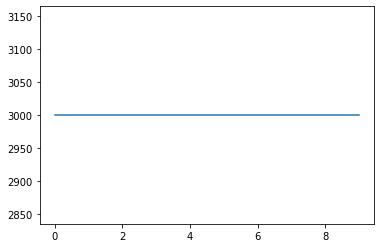

In [28]:
plt.plot(nitertab)
k = np.argmin(nitertab)
print(lamb[k])

In [28]:
k = 0.11
lamb0 = 0.11
mu = 0.1*lamb0
nitermax=3000
step0 = 0.01
ux,uy,CF,step,niter=RecalageDG(im1,im2,lamb0,mu,nitermax,step0)

iteration : 3  cost function : 80.51123776123845 step : 0.08
iteration : 6  cost function : 80.40180962749857 step : 0.64
iteration : 9  cost function : 79.84652172171097 step : 5.12
iteration : 12  cost function : 78.72598048711015 step : 2.56
iteration : 15  cost function : 78.5054947584329 step : 1.28
iteration : 18  cost function : 78.27150318449391 step : 1.28
iteration : 21  cost function : 78.02166236965697 step : 1.28
iteration : 24  cost function : 77.81155886669066 step : 1.28
iteration : 27  cost function : 77.58308728518236 step : 1.28
iteration : 30  cost function : 77.37504346993923 step : 2.56
iteration : 33  cost function : 77.15411612577407 step : 1.28
iteration : 36  cost function : 76.97135285700453 step : 1.28
iteration : 39  cost function : 76.79845605395136 step : 1.28
iteration : 42  cost function : 76.63732104953802 step : 1.28
iteration : 45  cost function : 76.47043259895965 step : 1.28
iteration : 48  cost function : 76.31136455181664 step : 1.28
iteration : 

iteration : 405  cost function : 67.32732950511055 step : 2.56
iteration : 408  cost function : 67.27402885424108 step : 2.56
iteration : 411  cost function : 67.22680518852238 step : 2.56
iteration : 414  cost function : 67.17195214574816 step : 2.56
iteration : 417  cost function : 67.12652535646973 step : 2.56
iteration : 420  cost function : 67.07463338372906 step : 1.28
iteration : 423  cost function : 67.03270002077772 step : 2.56
iteration : 426  cost function : 66.98335968090855 step : 1.28
iteration : 429  cost function : 66.94447163186258 step : 1.28
iteration : 432  cost function : 66.89729145753873 step : 1.28
iteration : 435  cost function : 66.86148441735835 step : 1.28
iteration : 438  cost function : 66.81599142172404 step : 1.28
iteration : 441  cost function : 66.76487899797694 step : 2.56
iteration : 444  cost function : 66.7380103955846 step : 1.28
iteration : 447  cost function : 66.6800805759952 step : 2.56
iteration : 450  cost function : 66.63594784339021 step :

iteration : 801  cost function : 61.00262302638858 step : 1.28
iteration : 804  cost function : 60.96465709076951 step : 1.28
iteration : 807  cost function : 60.91613071877299 step : 2.56
iteration : 810  cost function : 60.880262373028444 step : 2.56
iteration : 813  cost function : 60.84623785895736 step : 2.56
iteration : 816  cost function : 60.81323881074747 step : 2.56
iteration : 819  cost function : 60.781578402869584 step : 2.56
iteration : 822  cost function : 60.75003621796777 step : 2.56
iteration : 825  cost function : 60.7191217263482 step : 2.56
iteration : 828  cost function : 60.68760815868021 step : 2.56
iteration : 831  cost function : 60.656850358505125 step : 2.56
iteration : 834  cost function : 60.62535436550525 step : 2.56
iteration : 837  cost function : 60.59491511597474 step : 2.56
iteration : 840  cost function : 60.56384043395609 step : 2.56
iteration : 843  cost function : 60.53412175196175 step : 2.56
iteration : 846  cost function : 60.50356492793744 st

iteration : 1197  cost function : 57.49735340683298 step : 2.56
iteration : 1200  cost function : 57.47843432675214 step : 2.56
iteration : 1203  cost function : 57.45841743879797 step : 2.56
iteration : 1206  cost function : 57.43977836406438 step : 2.56
iteration : 1209  cost function : 57.41958593311165 step : 2.56
iteration : 1212  cost function : 57.40095201566167 step : 2.56
iteration : 1215  cost function : 57.38041236758195 step : 2.56
iteration : 1218  cost function : 57.361656131514856 step : 2.56
iteration : 1221  cost function : 57.34061029568982 step : 2.56
iteration : 1224  cost function : 57.32162487140228 step : 2.56
iteration : 1227  cost function : 57.30013330878299 step : 1.28
iteration : 1230  cost function : 57.28103895136199 step : 2.56
iteration : 1233  cost function : 57.25927658936146 step : 1.28
iteration : 1236  cost function : 57.2402707227908 step : 1.28
iteration : 1239  cost function : 57.218598405620654 step : 1.28
iteration : 1242  cost function : 57.19

iteration : 1590  cost function : 55.40126150594229 step : 2.56
iteration : 1593  cost function : 55.38514608998304 step : 2.56
iteration : 1596  cost function : 55.367527419069454 step : 2.56
iteration : 1599  cost function : 55.351612150053896 step : 2.56
iteration : 1602  cost function : 55.334020684979386 step : 1.28
iteration : 1605  cost function : 55.318415660345174 step : 1.28
iteration : 1608  cost function : 55.30094120195273 step : 1.28
iteration : 1611  cost function : 55.2857384948106 step : 1.28
iteration : 1614  cost function : 55.26846987536027 step : 1.28
iteration : 1617  cost function : 55.25380252052415 step : 1.28
iteration : 1620  cost function : 55.23686586020823 step : 1.28
iteration : 1623  cost function : 55.21544838097446 step : 2.56
iteration : 1626  cost function : 55.19849020870666 step : 2.56
iteration : 1629  cost function : 55.1822630296051 step : 2.56
iteration : 1632  cost function : 55.16550747274573 step : 2.56
iteration : 1635  cost function : 55.1

iteration : 1983  cost function : 53.9015251963973 step : 1.28
iteration : 1986  cost function : 53.894052730832804 step : 1.28
iteration : 1989  cost function : 53.88640127278037 step : 1.28
iteration : 1992  cost function : 53.878194021526824 step : 1.28
iteration : 1995  cost function : 53.87006721318836 step : 1.28
iteration : 1998  cost function : 53.86166791267403 step : 1.28
iteration : 2001  cost function : 53.85365810205967 step : 1.28
iteration : 2004  cost function : 53.84178977970488 step : 2.56
iteration : 2007  cost function : 53.833264849711256 step : 2.56
iteration : 2010  cost function : 53.824848591191326 step : 2.56
iteration : 2013  cost function : 53.81669150256658 step : 2.56
iteration : 2016  cost function : 53.80863654394349 step : 2.56
iteration : 2019  cost function : 53.800848449206896 step : 2.56
iteration : 2022  cost function : 53.79314554279911 step : 2.56
iteration : 2025  cost function : 53.785719739317884 step : 2.56
iteration : 2028  cost function : 5

iteration : 2376  cost function : 52.858618409957 step : 2.56
iteration : 2379  cost function : 52.84783673860679 step : 2.56
iteration : 2382  cost function : 52.83697603276071 step : 2.56
iteration : 2385  cost function : 52.82587550302382 step : 2.56
iteration : 2388  cost function : 52.814743445929466 step : 2.56
iteration : 2391  cost function : 52.80358779532405 step : 2.56
iteration : 2394  cost function : 52.79269988732937 step : 2.56
iteration : 2397  cost function : 52.78206843263332 step : 2.56
iteration : 2400  cost function : 52.77185528501544 step : 2.56
iteration : 2403  cost function : 52.76192178615335 step : 2.56
iteration : 2406  cost function : 52.75231575112629 step : 2.56
iteration : 2409  cost function : 52.74291480728033 step : 2.56
iteration : 2412  cost function : 52.733765056587664 step : 2.56
iteration : 2415  cost function : 52.72475439825379 step : 2.56
iteration : 2418  cost function : 52.71593642360115 step : 2.56
iteration : 2421  cost function : 52.707

iteration : 2769  cost function : 51.56485612682459 step : 1.28
iteration : 2772  cost function : 51.551449274057724 step : 2.56
iteration : 2775  cost function : 51.543526752638165 step : 1.28
iteration : 2778  cost function : 51.52923615602708 step : 2.56
iteration : 2781  cost function : 51.518155826405255 step : 2.56
iteration : 2784  cost function : 51.507904454370085 step : 2.56
iteration : 2787  cost function : 51.49730149914636 step : 2.56
iteration : 2790  cost function : 51.4876424394964 step : 2.56
iteration : 2793  cost function : 51.477552507032854 step : 2.56
iteration : 2796  cost function : 51.468480894396855 step : 2.56
iteration : 2799  cost function : 51.45885094066623 step : 2.56
iteration : 2802  cost function : 51.45027971217602 step : 2.56
iteration : 2805  cost function : 51.440992824104654 step : 2.56
iteration : 2808  cost function : 51.43282927575568 step : 2.56
iteration : 2811  cost function : 51.423784133874044 step : 2.56
iteration : 2814  cost function :

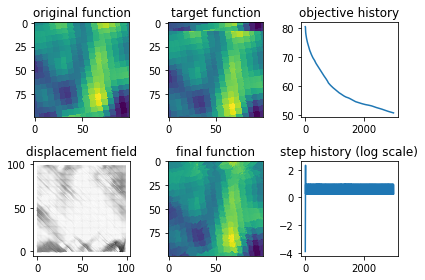

In [29]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(im1)
ax[0,0].set_title('original function')
ax[0,1].imshow(im2)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(im1,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

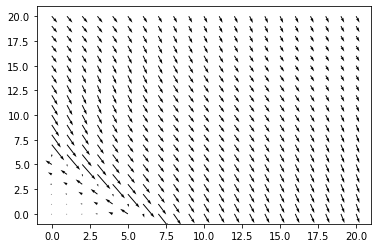

In [0]:
plt.quiver(ux, uy)
plt.show()

In [60]:
lambk = np.linspace(0,50,20)
muk = np.copy(lambk)
niter1 = np.zeros(20)
step1=0.01
eps1=0.1
nitermax=3000

for i in range(20) :
    ux,uy,CF,step,niter1[i]=RecalageGN(target,template,lambk[i],muk[i],nitermax,step1,eps1)

iteration : 3  cost function : 0.4466867074309917 step : 0.08
iteration : 6  cost function : 0.4458678740325265 step : 0.64
iteration : 9  cost function : 0.4393531604396029 step : 5.12
iteration : 12  cost function : 0.3900520875836228 step : 40.96
iteration : 15  cost function : 0.18575555111989675 step : 327.68
iteration : 18  cost function : 0.1229302335082229 step : 1310.72
iteration : 21  cost function : 0.06068982742489051 step : 655.36
iteration : 24  cost function : 0.041680416076619334 step : 327.68
iteration : 27  cost function : 0.03877595277964021 step : 163.84
iteration : 30  cost function : 0.038206795001747354 step : 40.96
iteration : 33  cost function : 0.03809986166698527 step : 327.68
iteration : 3  cost function : 0.4467624178965153 step : 0.08
iteration : 6  cost function : 0.4466642443951425 step : 0.64
iteration : 9  cost function : 0.4461474968844536 step : 5.12
iteration : 12  cost function : 0.44456859005539895 step : 2.56
iteration : 15  cost function : 0.443

iteration : 354  cost function : 0.37013485888006237 step : 2.56
iteration : 357  cost function : 0.36947904052840924 step : 2.56
iteration : 360  cost function : 0.3690213608409058 step : 1.28
iteration : 363  cost function : 0.36821826037504823 step : 2.56
iteration : 366  cost function : 0.36752252754706305 step : 2.56
iteration : 369  cost function : 0.36686216618246714 step : 2.56
iteration : 372  cost function : 0.3664615023486284 step : 1.28
iteration : 375  cost function : 0.3656170824142865 step : 2.56
iteration : 378  cost function : 0.36490032901202546 step : 2.56
iteration : 381  cost function : 0.3642283769170493 step : 2.56
iteration : 384  cost function : 0.3635842317914595 step : 2.56
iteration : 387  cost function : 0.36301699205094357 step : 1.28
iteration : 390  cost function : 0.36228112577009064 step : 2.56
iteration : 393  cost function : 0.3616013445672752 step : 2.56
iteration : 396  cost function : 0.3609545822456998 step : 2.56
iteration : 399  cost function :

iteration : 744  cost function : 0.29111308090013116 step : 2.56
iteration : 747  cost function : 0.290724336975644 step : 1.28
iteration : 750  cost function : 0.2901009743438829 step : 2.56
iteration : 753  cost function : 0.28954754475868955 step : 2.56
iteration : 756  cost function : 0.28902750715296743 step : 2.56
iteration : 759  cost function : 0.2887077843894424 step : 1.28
iteration : 762  cost function : 0.2880564314035076 step : 2.56
iteration : 765  cost function : 0.28749524674804094 step : 2.56
iteration : 768  cost function : 0.28697640253280626 step : 2.56
iteration : 771  cost function : 0.2864768651622272 step : 2.56
iteration : 774  cost function : 0.2860553034303646 step : 1.28
iteration : 777  cost function : 0.28547830516158057 step : 2.56
iteration : 780  cost function : 0.28495437791568073 step : 2.56
iteration : 783  cost function : 0.2844547459299063 step : 2.56
iteration : 786  cost function : 0.2840830732654089 step : 1.28
iteration : 789  cost function : 0

iteration : 1125  cost function : 0.2387239205914226 step : 1.28
iteration : 1128  cost function : 0.23834641403752932 step : 2.56
iteration : 1131  cost function : 0.23801035453994 step : 2.56
iteration : 1134  cost function : 0.23769266417930038 step : 2.56
iteration : 1137  cost function : 0.23748886438062827 step : 1.28
iteration : 1140  cost function : 0.2370947777937023 step : 2.56
iteration : 1143  cost function : 0.23675398640721507 step : 2.56
iteration : 1146  cost function : 0.23643670519943372 step : 2.56
iteration : 1149  cost function : 0.23613141263742948 step : 2.56
iteration : 1152  cost function : 0.23586846157960595 step : 1.28
iteration : 1155  cost function : 0.23552001714951745 step : 2.56
iteration : 1158  cost function : 0.23520185876143487 step : 2.56
iteration : 1161  cost function : 0.23489880527790583 step : 2.56
iteration : 1164  cost function : 0.23466881030042266 step : 1.28
iteration : 1167  cost function : 0.2343088888606354 step : 2.56
iteration : 1170

iteration : 1500  cost function : 0.20786584949903886 step : 2.56
iteration : 1503  cost function : 0.2077431464015364 step : 1.28
iteration : 1506  cost function : 0.20752044082918844 step : 2.56
iteration : 1509  cost function : 0.20732648039430457 step : 2.56
iteration : 1512  cost function : 0.20714538294009366 step : 2.56
iteration : 1515  cost function : 0.20697086360595598 step : 2.56
iteration : 1518  cost function : 0.20681759267820274 step : 1.28
iteration : 1521  cost function : 0.20662002932042475 step : 2.56
iteration : 1524  cost function : 0.2064390324430552 step : 2.56
iteration : 1527  cost function : 0.20626630712775745 step : 2.56
iteration : 1530  cost function : 0.2061319728894874 step : 1.28
iteration : 1533  cost function : 0.2059287565237825 step : 2.56
iteration : 1536  cost function : 0.2057469348617053 step : 2.56
iteration : 1539  cost function : 0.20557559065436296 step : 2.56
iteration : 1542  cost function : 0.20546449741811576 step : 1.28
iteration : 154

iteration : 1881  cost function : 0.19001329154618338 step : 1.28
iteration : 1884  cost function : 0.18986971640829065 step : 1.28
iteration : 1887  cost function : 0.1897471158394149 step : 2.56
iteration : 1890  cost function : 0.18963410714204526 step : 2.56
iteration : 1893  cost function : 0.18952566164840848 step : 2.56
iteration : 1896  cost function : 0.18943858731655402 step : 1.28
iteration : 1899  cost function : 0.18931171926603269 step : 2.56
iteration : 1902  cost function : 0.18919765771668165 step : 2.56
iteration : 1905  cost function : 0.18908944430124053 step : 2.56
iteration : 1908  cost function : 0.18901563124388923 step : 1.28
iteration : 1911  cost function : 0.18888314723396823 step : 2.56
iteration : 1914  cost function : 0.18876726527289503 step : 2.56
iteration : 1917  cost function : 0.18865891601514703 step : 2.56
iteration : 1920  cost function : 0.18855422068236594 step : 2.56
iteration : 1923  cost function : 0.18846165136350934 step : 1.28
iteration :

iteration : 2262  cost function : 0.1781996922482513 step : 1.28
iteration : 2265  cost function : 0.17811076697903508 step : 2.56
iteration : 2268  cost function : 0.1780296232144515 step : 2.56
iteration : 2271  cost function : 0.1779520173921215 step : 2.56
iteration : 2274  cost function : 0.17789375735538074 step : 1.28
iteration : 2277  cost function : 0.17780093072036224 step : 2.56
iteration : 2280  cost function : 0.17771843218813743 step : 2.56
iteration : 2283  cost function : 0.17764049967713652 step : 2.56
iteration : 2286  cost function : 0.17759247234831096 step : 1.28
iteration : 2289  cost function : 0.17749458330511075 step : 2.56
iteration : 2292  cost function : 0.17741022583587174 step : 2.56
iteration : 2295  cost function : 0.1773317978123678 step : 2.56
iteration : 2298  cost function : 0.17725630612565377 step : 2.56
iteration : 2301  cost function : 0.17719244700873152 step : 1.28
iteration : 2304  cost function : 0.17710544620741125 step : 2.56
iteration : 23

iteration : 2640  cost function : 0.16925915170716732 step : 1.28
iteration : 2643  cost function : 0.16918375019517234 step : 2.56
iteration : 2646  cost function : 0.16911503644227593 step : 2.56
iteration : 2649  cost function : 0.16904916050458596 step : 2.56
iteration : 2652  cost function : 0.1689993760638338 step : 1.28
iteration : 2655  cost function : 0.16892048430633377 step : 2.56
iteration : 2658  cost function : 0.1688502974828657 step : 2.56
iteration : 2661  cost function : 0.16878383090953453 step : 2.56
iteration : 2664  cost function : 0.16874230977989693 step : 1.28
iteration : 2667  cost function : 0.1686588061673624 step : 2.56
iteration : 2670  cost function : 0.16858664188007838 step : 2.56
iteration : 2673  cost function : 0.16851935512003507 step : 2.56
iteration : 2676  cost function : 0.16845452489103369 step : 2.56
iteration : 2679  cost function : 0.16839916809591512 step : 1.28
iteration : 2682  cost function : 0.16832446535252144 step : 2.56
iteration : 2

iteration : 21  cost function : 0.44277439839511656 step : 1.28
iteration : 24  cost function : 0.44206528581778626 step : 2.56
iteration : 27  cost function : 0.4414231478648857 step : 5.12
iteration : 30  cost function : 0.4406511737124594 step : 2.56
iteration : 33  cost function : 0.4400052418872029 step : 2.56
iteration : 36  cost function : 0.43939559108398635 step : 2.56
iteration : 39  cost function : 0.43884028663845337 step : 1.28
iteration : 42  cost function : 0.4381485815560102 step : 2.56
iteration : 45  cost function : 0.4375069974674682 step : 5.12
iteration : 48  cost function : 0.4367320269153497 step : 2.56
iteration : 51  cost function : 0.4360803464078161 step : 2.56
iteration : 54  cost function : 0.4354647012923913 step : 2.56
iteration : 57  cost function : 0.4349198769972852 step : 1.28
iteration : 60  cost function : 0.4342133847868966 step : 2.56
iteration : 63  cost function : 0.4335596334307538 step : 2.56
iteration : 66  cost function : 0.4329405609053539 

iteration : 405  cost function : 0.358863121072209 step : 2.56
iteration : 408  cost function : 0.35822215336632035 step : 2.56
iteration : 411  cost function : 0.35765971059193435 step : 1.28
iteration : 414  cost function : 0.3569273176146017 step : 2.56
iteration : 417  cost function : 0.35625034779679043 step : 2.56
iteration : 420  cost function : 0.3556064738778827 step : 2.56
iteration : 423  cost function : 0.3550996499581689 step : 1.28
iteration : 426  cost function : 0.35433800912910857 step : 2.56
iteration : 429  cost function : 0.3536487467842878 step : 2.56
iteration : 432  cost function : 0.35300077598789653 step : 2.56
iteration : 435  cost function : 0.3525654461765652 step : 1.28
iteration : 438  cost function : 0.3517656037114695 step : 2.56
iteration : 441  cost function : 0.3510601226078857 step : 2.56
iteration : 444  cost function : 0.3504064228662527 step : 2.56
iteration : 447  cost function : 0.3497703905571081 step : 2.56
iteration : 450  cost function : 0.3

iteration : 789  cost function : 0.2834980740597393 step : 1.28
iteration : 792  cost function : 0.2829227389460309 step : 2.56
iteration : 795  cost function : 0.28240336401475374 step : 2.56
iteration : 798  cost function : 0.2819118108360837 step : 2.56
iteration : 801  cost function : 0.28157999483641666 step : 1.28
iteration : 804  cost function : 0.2809779554222406 step : 2.56
iteration : 807  cost function : 0.28045036778094673 step : 2.56
iteration : 810  cost function : 0.2799591612507247 step : 2.56
iteration : 813  cost function : 0.27948440872709934 step : 2.56
iteration : 816  cost function : 0.2790738678687066 step : 1.28
iteration : 819  cost function : 0.27853285139898154 step : 2.56
iteration : 822  cost function : 0.27803965081267856 step : 2.56
iteration : 825  cost function : 0.2775680124791258 step : 2.56
iteration : 828  cost function : 0.27721404138273403 step : 1.28
iteration : 831  cost function : 0.2766525422398854 step : 2.56
iteration : 834  cost function : 

iteration : 1176  cost function : 0.23343167979410145 step : 2.56
iteration : 1179  cost function : 0.2331257237509903 step : 2.56
iteration : 1182  cost function : 0.23283232592119343 step : 2.56
iteration : 1185  cost function : 0.23260283143993765 step : 1.28
iteration : 1188  cost function : 0.23225780431321102 step : 2.56
iteration : 1191  cost function : 0.23194895393029832 step : 2.56
iteration : 1194  cost function : 0.2316570098117966 step : 2.56
iteration : 1197  cost function : 0.2314725093487646 step : 1.28
iteration : 1200  cost function : 0.23110961684908962 step : 2.56
iteration : 1203  cost function : 0.23079533527591492 step : 2.56
iteration : 1206  cost function : 0.2305033187095699 step : 2.56
iteration : 1209  cost function : 0.2302224333081277 step : 2.56
iteration : 1212  cost function : 0.22998825068120393 step : 1.28
iteration : 1215  cost function : 0.22966453121018363 step : 2.56
iteration : 1218  cost function : 0.22937069222431952 step : 2.56
iteration : 122

iteration : 1554  cost function : 0.20485536267253235 step : 2.56
iteration : 1557  cost function : 0.20471588037552962 step : 1.28
iteration : 1560  cost function : 0.204527697014899 step : 2.56
iteration : 1563  cost function : 0.20435658805517423 step : 2.56
iteration : 1566  cost function : 0.2041934841683154 step : 2.56
iteration : 1569  cost function : 0.20407618178823414 step : 1.28
iteration : 1572  cost function : 0.20387997885384973 step : 2.56
iteration : 1575  cost function : 0.20370676545048697 step : 2.56
iteration : 1578  cost function : 0.2035442362978624 step : 2.56
iteration : 1581  cost function : 0.2034558552915507 step : 1.28
iteration : 1584  cost function : 0.20324758153061018 step : 1.28
iteration : 1587  cost function : 0.20307025750329835 step : 2.56
iteration : 1590  cost function : 0.20290651074925092 step : 2.56
iteration : 1593  cost function : 0.20274979737629542 step : 2.56
iteration : 1596  cost function : 0.20262840872682789 step : 1.28
iteration : 159

iteration : 1932  cost function : 0.18832813659718448 step : 2.56
iteration : 1935  cost function : 0.18822099387739835 step : 2.56
iteration : 1938  cost function : 0.18811808039620623 step : 2.56
iteration : 1941  cost function : 0.18803577530526122 step : 1.28
iteration : 1944  cost function : 0.18791528208166827 step : 2.56
iteration : 1947  cost function : 0.18780668610410334 step : 2.56
iteration : 1950  cost function : 0.187703758329099 step : 2.56
iteration : 1953  cost function : 0.1876364632327546 step : 1.28
iteration : 1956  cost function : 0.18750923152145912 step : 2.56
iteration : 1959  cost function : 0.1873981748816337 step : 2.56
iteration : 1962  cost function : 0.18729475720366867 step : 2.56
iteration : 1965  cost function : 0.18719492150595632 step : 2.56
iteration : 1968  cost function : 0.1871105265990529 step : 1.28
iteration : 1971  cost function : 0.18699564271242144 step : 2.56
iteration : 1974  cost function : 0.18689109600857073 step : 2.56
iteration : 197

iteration : 2310  cost function : 0.1772737850692078 step : 1.28
iteration : 2313  cost function : 0.1771756017484504 step : 1.28
iteration : 2316  cost function : 0.17709199221592825 step : 2.56
iteration : 2319  cost function : 0.17701497059263108 step : 2.56
iteration : 2322  cost function : 0.176941148546492 step : 2.56
iteration : 2325  cost function : 0.1768840475632145 step : 1.28
iteration : 2328  cost function : 0.17679656866650614 step : 2.56
iteration : 2331  cost function : 0.17671807719410954 step : 2.56
iteration : 2334  cost function : 0.17664390066318042 step : 2.56
iteration : 2337  cost function : 0.17659797517838605 step : 1.28
iteration : 2340  cost function : 0.1765049525764152 step : 2.56
iteration : 2343  cost function : 0.17642421083861665 step : 2.56
iteration : 2346  cost function : 0.17634931208828092 step : 2.56
iteration : 2349  cost function : 0.17627705485732903 step : 2.56
iteration : 2352  cost function : 0.17621756997298996 step : 1.28
iteration : 2355

iteration : 2688  cost function : 0.16857325668075893 step : 2.56
iteration : 2691  cost function : 0.1685080667473277 step : 2.56
iteration : 2694  cost function : 0.16846994650022123 step : 1.28
iteration : 2697  cost function : 0.1683869786383921 step : 1.28
iteration : 2700  cost function : 0.16831560485011535 step : 2.56
iteration : 2703  cost function : 0.16824939459577484 step : 2.56
iteration : 2706  cost function : 0.16818598853979086 step : 2.56
iteration : 2709  cost function : 0.16813562675571544 step : 1.28
iteration : 2712  cost function : 0.16806172298110456 step : 2.56
iteration : 2715  cost function : 0.16799491344021922 step : 2.56
iteration : 2718  cost function : 0.16793150488717343 step : 2.56
iteration : 2721  cost function : 0.16788978710553204 step : 1.28
iteration : 2724  cost function : 0.1678111738837899 step : 2.56
iteration : 2727  cost function : 0.16774229541487223 step : 2.56
iteration : 2730  cost function : 0.1676782326638937 step : 2.56
iteration : 27

iteration : 66  cost function : 0.43321735887521595 step : 2.56
iteration : 69  cost function : 0.4325620461518696 step : 2.56
iteration : 72  cost function : 0.43193959006538457 step : 2.56
iteration : 75  cost function : 0.43140321974709084 step : 1.28
iteration : 78  cost function : 0.4306827003359143 step : 2.56
iteration : 81  cost function : 0.4300186015022658 step : 2.56
iteration : 84  cost function : 0.4293901944540547 step : 2.56
iteration : 87  cost function : 0.4288697399212614 step : 1.28
iteration : 90  cost function : 0.4281331142969849 step : 2.56
iteration : 93  cost function : 0.42745882489433434 step : 2.56
iteration : 96  cost function : 0.42682407990460297 step : 2.56
iteration : 99  cost function : 0.4263265979254934 step : 1.28
iteration : 102  cost function : 0.4255701222760923 step : 2.56
iteration : 105  cost function : 0.4248841026046125 step : 2.56
iteration : 108  cost function : 0.42424258317655084 step : 2.56
iteration : 111  cost function : 0.42377633648

iteration : 456  cost function : 0.3480969542667485 step : 2.56
iteration : 459  cost function : 0.3476109832442289 step : 1.28
iteration : 462  cost function : 0.34684978202640043 step : 2.56
iteration : 465  cost function : 0.34616525041651697 step : 2.56
iteration : 468  cost function : 0.34552278701135525 step : 2.56
iteration : 471  cost function : 0.3451215914487297 step : 1.28
iteration : 474  cost function : 0.3443157201299859 step : 2.56
iteration : 477  cost function : 0.34361222270332964 step : 2.56
iteration : 480  cost function : 0.3429630734993845 step : 2.56
iteration : 483  cost function : 0.34233415702153347 step : 2.56
iteration : 486  cost function : 0.3418081141716343 step : 1.28
iteration : 489  cost function : 0.34107902295599524 step : 2.56
iteration : 492  cost function : 0.34042047317267365 step : 2.56
iteration : 495  cost function : 0.33978888989560957 step : 2.56
iteration : 498  cost function : 0.3393322738883438 step : 1.28
iteration : 501  cost function :

iteration : 840  cost function : 0.2755801292431068 step : 1.28
iteration : 843  cost function : 0.2750091978288048 step : 2.56
iteration : 846  cost function : 0.2745100565045013 step : 2.56
iteration : 849  cost function : 0.2740432782742287 step : 2.56
iteration : 852  cost function : 0.27359316807921297 step : 2.56
iteration : 855  cost function : 0.273203544123021 step : 1.28
iteration : 858  cost function : 0.27269121090939624 step : 2.56
iteration : 861  cost function : 0.2722224002436343 step : 2.56
iteration : 864  cost function : 0.2717754513756699 step : 2.56
iteration : 867  cost function : 0.2714430523287425 step : 1.28
iteration : 870  cost function : 0.2709100127441155 step : 2.56
iteration : 873  cost function : 0.2704357105251128 step : 2.56
iteration : 876  cost function : 0.26999032487186797 step : 2.56
iteration : 879  cost function : 0.2697327778440036 step : 1.28
iteration : 882  cost function : 0.2691689698307797 step : 1.28
iteration : 885  cost function : 0.268

iteration : 1224  cost function : 0.2290883988692894 step : 1.28
iteration : 1227  cost function : 0.22872509504746363 step : 1.28
iteration : 1230  cost function : 0.228415470732451 step : 2.56
iteration : 1233  cost function : 0.22813122586956766 step : 2.56
iteration : 1236  cost function : 0.22785909639658464 step : 2.56
iteration : 1239  cost function : 0.22765107781373986 step : 1.28
iteration : 1242  cost function : 0.22732914695837664 step : 2.56
iteration : 1245  cost function : 0.22704176266599166 step : 2.56
iteration : 1248  cost function : 0.2267706692786949 step : 2.56
iteration : 1251  cost function : 0.22660840846855002 step : 1.28
iteration : 1254  cost function : 0.22626858418921802 step : 1.28
iteration : 1257  cost function : 0.22597596584096458 step : 2.56
iteration : 1260  cost function : 0.2257054084874847 step : 2.56
iteration : 1263  cost function : 0.2254456732966359 step : 2.56
iteration : 1266  cost function : 0.22523743376484626 step : 1.28
iteration : 1269

iteration : 1608  cost function : 0.202086718356251 step : 2.56
iteration : 1611  cost function : 0.20199189688174965 step : 1.28
iteration : 1614  cost function : 0.2017968562203673 step : 2.56
iteration : 1617  cost function : 0.2016283548814724 step : 2.56
iteration : 1620  cost function : 0.20147235663242608 step : 2.56
iteration : 1623  cost function : 0.2013224302116734 step : 2.56
iteration : 1626  cost function : 0.20120144182651378 step : 1.28
iteration : 1629  cost function : 0.20102690945603835 step : 2.56
iteration : 1632  cost function : 0.20086948151753042 step : 2.56
iteration : 1635  cost function : 0.20072022903684483 step : 2.56
iteration : 1638  cost function : 0.20062257663496796 step : 1.28
iteration : 1641  cost function : 0.20043864061181807 step : 2.56
iteration : 1644  cost function : 0.20027820161240625 step : 2.56
iteration : 1647  cost function : 0.20012886389808734 step : 2.56
iteration : 1650  cost function : 0.19998493027620778 step : 2.56
iteration : 165

iteration : 1986  cost function : 0.18662891861341016 step : 1.28
iteration : 1989  cost function : 0.18651468713168426 step : 2.56
iteration : 1992  cost function : 0.1864112871347697 step : 2.56
iteration : 1995  cost function : 0.1863129766836584 step : 2.56
iteration : 1998  cost function : 0.18624705503698555 step : 1.28
iteration : 2001  cost function : 0.18612626957620879 step : 2.56
iteration : 2004  cost function : 0.18602043880784402 step : 2.56
iteration : 2007  cost function : 0.18592158485983273 step : 2.56
iteration : 2010  cost function : 0.18582609582513906 step : 2.56
iteration : 2013  cost function : 0.18574487823053 step : 1.28
iteration : 2016  cost function : 0.18563521853059683 step : 2.56
iteration : 2019  cost function : 0.18553516486146984 step : 2.56
iteration : 2022  cost function : 0.1854396856300512 step : 2.56
iteration : 2025  cost function : 0.18537140689079634 step : 1.28
iteration : 2028  cost function : 0.1852559829101636 step : 2.56
iteration : 2031 

iteration : 2370  cost function : 0.17590430360542575 step : 2.56
iteration : 2373  cost function : 0.17584195038042386 step : 1.28
iteration : 2376  cost function : 0.17576147888619584 step : 2.56
iteration : 2379  cost function : 0.17568746309043476 step : 2.56
iteration : 2382  cost function : 0.17561649748912792 step : 2.56
iteration : 2385  cost function : 0.1755626934422233 step : 1.28
iteration : 2388  cost function : 0.1754780770468224 step : 2.56
iteration : 2391  cost function : 0.17540240626010434 step : 2.56
iteration : 2394  cost function : 0.17533093140347306 step : 2.56
iteration : 2397  cost function : 0.1752887811261411 step : 1.28
iteration : 2400  cost function : 0.17519817678088534 step : 1.28
iteration : 2403  cost function : 0.1751199899752853 step : 2.56
iteration : 2406  cost function : 0.17504759713107584 step : 2.56
iteration : 2409  cost function : 0.17497790402658908 step : 2.56
iteration : 2412  cost function : 0.1749222862795539 step : 1.28
iteration : 241

iteration : 2754  cost function : 0.16734255984355798 step : 2.56
iteration : 2757  cost function : 0.16729865382606338 step : 1.28
iteration : 2760  cost function : 0.16722314005188824 step : 2.56
iteration : 2763  cost function : 0.16715617311798067 step : 2.56
iteration : 2766  cost function : 0.1670932290498122 step : 2.56
iteration : 2769  cost function : 0.16703214349813825 step : 2.56
iteration : 2772  cost function : 0.16697843633245846 step : 1.28
iteration : 2775  cost function : 0.16690872846639512 step : 2.56
iteration : 2778  cost function : 0.1668445379141007 step : 2.56
iteration : 2781  cost function : 0.16678292175738177 step : 2.56
iteration : 2784  cost function : 0.1667362786976543 step : 1.28
iteration : 2787  cost function : 0.16666260315797304 step : 2.56
iteration : 2790  cost function : 0.1665966988658058 step : 2.56
iteration : 2793  cost function : 0.16653437248650912 step : 2.56
iteration : 2796  cost function : 0.16649761873391294 step : 1.28
iteration : 27

iteration : 141  cost function : 0.4173113371500331 step : 2.56
iteration : 144  cost function : 0.416769989078594 step : 1.28
iteration : 147  cost function : 0.4160146217410454 step : 2.56
iteration : 150  cost function : 0.41533759772892614 step : 2.56
iteration : 153  cost function : 0.414683163327788 step : 2.56
iteration : 156  cost function : 0.41418638345617614 step : 1.28
iteration : 159  cost function : 0.41340041373339104 step : 2.56
iteration : 162  cost function : 0.4127094187692368 step : 2.56
iteration : 165  cost function : 0.41204711947980566 step : 2.56
iteration : 168  cost function : 0.41160828635848284 step : 1.28
iteration : 171  cost function : 0.41078442769953816 step : 2.56
iteration : 174  cost function : 0.4100765001269648 step : 2.56
iteration : 177  cost function : 0.4094051537621261 step : 2.56
iteration : 180  cost function : 0.40875985227734946 step : 2.56
iteration : 183  cost function : 0.4081701289688873 step : 1.28
iteration : 186  cost function : 0.

iteration : 528  cost function : 0.33309702592028456 step : 2.56
iteration : 531  cost function : 0.33248095230048075 step : 2.56
iteration : 534  cost function : 0.3319879732527374 step : 1.28
iteration : 537  cost function : 0.3312644910066006 step : 2.56
iteration : 540  cost function : 0.3306154195467269 step : 2.56
iteration : 543  cost function : 0.32999651602747626 step : 2.56
iteration : 546  cost function : 0.3295857320208774 step : 1.28
iteration : 549  cost function : 0.32882139378352654 step : 2.56
iteration : 552  cost function : 0.3281563472056105 step : 2.56
iteration : 555  cost function : 0.3275335375978898 step : 2.56
iteration : 558  cost function : 0.3269338241481276 step : 2.56
iteration : 561  cost function : 0.3264155466153112 step : 1.28
iteration : 564  cost function : 0.32572917625152525 step : 2.56
iteration : 567  cost function : 0.32509895029073443 step : 2.56
iteration : 570  cost function : 0.32449841427726367 step : 2.56
iteration : 573  cost function : 

iteration : 912  cost function : 0.2649922810206453 step : 2.56
iteration : 915  cost function : 0.2645763580376824 step : 2.56
iteration : 918  cost function : 0.26426420364755254 step : 1.28
iteration : 921  cost function : 0.2637695702842569 step : 2.56
iteration : 924  cost function : 0.2633297123883504 step : 2.56
iteration : 927  cost function : 0.2629151685003356 step : 2.56
iteration : 930  cost function : 0.2626751814361291 step : 1.28
iteration : 933  cost function : 0.2621505748021324 step : 1.28
iteration : 936  cost function : 0.26170084057852006 step : 2.56
iteration : 939  cost function : 0.2612855570181075 step : 2.56
iteration : 942  cost function : 0.26088752743109517 step : 2.56
iteration : 945  cost function : 0.2605733888170524 step : 1.28
iteration : 948  cost function : 0.2601071275707925 step : 2.56
iteration : 951  cost function : 0.2596879910321304 step : 2.56
iteration : 954  cost function : 0.2592919611411818 step : 2.56
iteration : 957  cost function : 0.25

iteration : 1296  cost function : 0.2227495335220173 step : 2.56
iteration : 1299  cost function : 0.22249261228596215 step : 2.56
iteration : 1302  cost function : 0.22224668115704152 step : 2.56
iteration : 1305  cost function : 0.2220592249677671 step : 1.28
iteration : 1308  cost function : 0.22176825802899888 step : 2.56
iteration : 1311  cost function : 0.2215084240408979 step : 2.56
iteration : 1314  cost function : 0.22126350935422506 step : 2.56
iteration : 1317  cost function : 0.22111940241820752 step : 1.28
iteration : 1320  cost function : 0.22081065668504302 step : 1.28
iteration : 1323  cost function : 0.22054495702638618 step : 2.56
iteration : 1326  cost function : 0.22029967068788475 step : 2.56
iteration : 1329  cost function : 0.22006428682807497 step : 2.56
iteration : 1332  cost function : 0.2198786269617741 step : 1.28
iteration : 1335  cost function : 0.21960295309395675 step : 2.56
iteration : 1338  cost function : 0.2193554823777619 step : 2.56
iteration : 134

iteration : 1680  cost function : 0.19866808581084422 step : 1.28
iteration : 1683  cost function : 0.19850553630764442 step : 2.56
iteration : 1686  cost function : 0.19835912693662328 step : 2.56
iteration : 1689  cost function : 0.1982202515243774 step : 2.56
iteration : 1692  cost function : 0.1981310135493405 step : 1.28
iteration : 1695  cost function : 0.19795912201588559 step : 2.56
iteration : 1698  cost function : 0.19780960455237342 step : 2.56
iteration : 1701  cost function : 0.19767044902553235 step : 2.56
iteration : 1704  cost function : 0.1975364909028995 step : 2.56
iteration : 1707  cost function : 0.197425773435906 step : 1.28
iteration : 1710  cost function : 0.19727095706522446 step : 2.56
iteration : 1713  cost function : 0.19713047951982704 step : 2.56
iteration : 1716  cost function : 0.19699705470690068 step : 2.56
iteration : 1719  cost function : 0.1969068581285884 step : 1.28
iteration : 1722  cost function : 0.19674369149380588 step : 2.56
iteration : 1725

iteration : 2064  cost function : 0.18420596959044394 step : 2.56
iteration : 2067  cost function : 0.18414007260219023 step : 1.28
iteration : 2070  cost function : 0.18403048002278924 step : 2.56
iteration : 2073  cost function : 0.18393314556717716 step : 2.56
iteration : 2076  cost function : 0.18384174129886188 step : 2.56
iteration : 2079  cost function : 0.18375302495445225 step : 2.56
iteration : 2082  cost function : 0.18367486188966672 step : 1.28
iteration : 2085  cost function : 0.1835741885709985 step : 2.56
iteration : 2088  cost function : 0.18348175428952337 step : 2.56
iteration : 2091  cost function : 0.183393099439411 step : 2.56
iteration : 2094  cost function : 0.18332632029719073 step : 1.28
iteration : 2097  cost function : 0.18322066132819437 step : 2.56
iteration : 2100  cost function : 0.18312645222981944 step : 2.56
iteration : 2103  cost function : 0.18303747561043746 step : 2.56
iteration : 2106  cost function : 0.18298620163037235 step : 1.28
iteration : 2

iteration : 2448  cost function : 0.17415311746488685 step : 2.56
iteration : 2451  cost function : 0.17408424886341303 step : 2.56
iteration : 2454  cost function : 0.17403727193404195 step : 1.28
iteration : 2457  cost function : 0.17395289844779052 step : 2.56
iteration : 2460  cost function : 0.17387872860442224 step : 2.56
iteration : 2463  cost function : 0.1738092015910443 step : 2.56
iteration : 2466  cost function : 0.1737419238801936 step : 2.56
iteration : 2469  cost function : 0.1736842499232079 step : 1.28
iteration : 2472  cost function : 0.17360692320249674 step : 2.56
iteration : 2475  cost function : 0.17353610133813974 step : 2.56
iteration : 2478  cost function : 0.17346839646393009 step : 2.56
iteration : 2481  cost function : 0.1734195413068167 step : 1.28
iteration : 2484  cost function : 0.17333762091876964 step : 2.56
iteration : 2487  cost function : 0.17326482875439886 step : 2.56
iteration : 2490  cost function : 0.17319637458643364 step : 2.56
iteration : 24

iteration : 2832  cost function : 0.16583278377622707 step : 2.56
iteration : 2835  cost function : 0.1657689082796195 step : 2.56
iteration : 2838  cost function : 0.16570787121264954 step : 2.56
iteration : 2841  cost function : 0.16566450730730228 step : 1.28
iteration : 2844  cost function : 0.1655902451437624 step : 2.56
iteration : 2847  cost function : 0.1655243764852168 step : 2.56
iteration : 2850  cost function : 0.1654624780347863 step : 2.56
iteration : 2853  cost function : 0.16540236186201976 step : 2.56
iteration : 2856  cost function : 0.16534969504237976 step : 1.28
iteration : 2859  cost function : 0.16528096906165585 step : 2.56
iteration : 2862  cost function : 0.16521780482094828 step : 2.56
iteration : 2865  cost function : 0.1651571439710987 step : 2.56
iteration : 2868  cost function : 0.16511172207428054 step : 1.28
iteration : 2871  cost function : 0.1650389273495638 step : 2.56
iteration : 2874  cost function : 0.16497393252865253 step : 2.56
iteration : 2877

iteration : 216  cost function : 0.40047002001548593 step : 2.56
iteration : 219  cost function : 0.3998030025493431 step : 2.56
iteration : 222  cost function : 0.3993781968219246 step : 1.28
iteration : 225  cost function : 0.3985424699495681 step : 2.56
iteration : 228  cost function : 0.39782609590761897 step : 2.56
iteration : 231  cost function : 0.3971500448348152 step : 2.56
iteration : 234  cost function : 0.3965012251062404 step : 2.56
iteration : 237  cost function : 0.3959298154044605 step : 1.28
iteration : 240  cost function : 0.39518875819900817 step : 2.56
iteration : 243  cost function : 0.394501209742865 step : 2.56
iteration : 246  cost function : 0.39384803852899675 step : 2.56
iteration : 249  cost function : 0.3933345827459478 step : 1.28
iteration : 252  cost function : 0.3925611468651036 step : 2.56
iteration : 255  cost function : 0.3918587325465569 step : 2.56
iteration : 258  cost function : 0.39119993727989444 step : 2.56
iteration : 261  cost function : 0.3

iteration : 609  cost function : 0.3164591097297973 step : 2.56
iteration : 612  cost function : 0.31585908568036486 step : 2.56
iteration : 615  cost function : 0.3152776465849504 step : 2.56
iteration : 618  cost function : 0.31478261575005084 step : 1.28
iteration : 621  cost function : 0.3141140264178759 step : 2.56
iteration : 624  cost function : 0.31350605450356395 step : 2.56
iteration : 627  cost function : 0.31292363809146134 step : 2.56
iteration : 630  cost function : 0.3125023365831394 step : 1.28
iteration : 633  cost function : 0.3117995453203964 step : 2.56
iteration : 636  cost function : 0.3111787990548275 step : 2.56
iteration : 639  cost function : 0.3105930625873061 step : 2.56
iteration : 642  cost function : 0.31027096169527113 step : 1.28
iteration : 645  cost function : 0.30951888240702286 step : 1.28
iteration : 648  cost function : 0.3088784144210057 step : 2.56
iteration : 651  cost function : 0.30828639437975075 step : 2.56
iteration : 654  cost function : 

iteration : 996  cost function : 0.2537127259886694 step : 2.56
iteration : 999  cost function : 0.25333614684958766 step : 2.56
iteration : 1002  cost function : 0.25311792319287585 step : 1.28
iteration : 1005  cost function : 0.2526410419813142 step : 1.28
iteration : 1008  cost function : 0.25223145834294014 step : 2.56
iteration : 1011  cost function : 0.2518532725758545 step : 2.56
iteration : 1014  cost function : 0.251490465661006 step : 2.56
iteration : 1017  cost function : 0.25120567148381656 step : 1.28
iteration : 1020  cost function : 0.2507795749805232 step : 2.56
iteration : 1023  cost function : 0.25039692361331845 step : 2.56
iteration : 1026  cost function : 0.25003531861712763 step : 2.56
iteration : 1029  cost function : 0.2498107688562724 step : 1.28
iteration : 1032  cost function : 0.24935908895273795 step : 2.56
iteration : 1035  cost function : 0.24896748372178484 step : 2.56
iteration : 1038  cost function : 0.24860441995459412 step : 2.56
iteration : 1041  c

iteration : 1377  cost function : 0.2163936307338562 step : 1.28
iteration : 1380  cost function : 0.21611854530537836 step : 2.56
iteration : 1383  cost function : 0.21587970784550725 step : 2.56
iteration : 1386  cost function : 0.21565810556590084 step : 2.56
iteration : 1389  cost function : 0.21544494056266847 step : 2.56
iteration : 1392  cost function : 0.21527139825426633 step : 1.28
iteration : 1395  cost function : 0.21502422590213816 step : 2.56
iteration : 1398  cost function : 0.21480089068666974 step : 2.56
iteration : 1401  cost function : 0.21458901929171564 step : 2.56
iteration : 1404  cost function : 0.2144499328777918 step : 1.28
iteration : 1407  cost function : 0.2141893670663383 step : 2.56
iteration : 1410  cost function : 0.21396193092524302 step : 2.56
iteration : 1413  cost function : 0.21375022302658445 step : 2.56
iteration : 1416  cost function : 0.21354627531189085 step : 2.56
iteration : 1419  cost function : 0.21337658228932124 step : 1.28
iteration : 1

iteration : 1755  cost function : 0.19527858594232586 step : 1.28
iteration : 1758  cost function : 0.19513848260120287 step : 2.56
iteration : 1761  cost function : 0.19500888667228788 step : 2.56
iteration : 1764  cost function : 0.1948844570483375 step : 2.56
iteration : 1767  cost function : 0.19478634504606318 step : 1.28
iteration : 1770  cost function : 0.1946403335124855 step : 2.56
iteration : 1773  cost function : 0.19450896441747084 step : 2.56
iteration : 1776  cost function : 0.19438468117601373 step : 2.56
iteration : 1779  cost function : 0.1943075232734428 step : 1.28
iteration : 1782  cost function : 0.19415238286590536 step : 2.56
iteration : 1785  cost function : 0.19401772574835258 step : 2.56
iteration : 1788  cost function : 0.1938928648066634 step : 2.56
iteration : 1791  cost function : 0.19377265636623345 step : 2.56
iteration : 1794  cost function : 0.19367554149714267 step : 1.28
iteration : 1797  cost function : 0.193535480538177 step : 2.56
iteration : 1800

iteration : 2130  cost function : 0.18224770663374587 step : 1.28
iteration : 2133  cost function : 0.18215298072459252 step : 2.56
iteration : 2136  cost function : 0.1820652906288822 step : 2.56
iteration : 2139  cost function : 0.18198088504562596 step : 2.56
iteration : 2142  cost function : 0.18191377283599397 step : 1.28
iteration : 2145  cost function : 0.18181474125436514 step : 2.56
iteration : 2148  cost function : 0.181725539711877 step : 2.56
iteration : 2151  cost function : 0.18164089629089838 step : 2.56
iteration : 2154  cost function : 0.18158745706841434 step : 1.28
iteration : 2157  cost function : 0.18148196673278508 step : 2.56
iteration : 2160  cost function : 0.18139025190671676 step : 2.56
iteration : 2163  cost function : 0.18130489768098051 step : 2.56
iteration : 2166  cost function : 0.18122265843564156 step : 2.56
iteration : 2169  cost function : 0.18115533791933222 step : 1.28
iteration : 2172  cost function : 0.18105970199888183 step : 2.56
iteration : 2

iteration : 2505  cost function : 0.172868350719868 step : 2.56
iteration : 2508  cost function : 0.17279536930714048 step : 2.56
iteration : 2511  cost function : 0.17272705527436982 step : 2.56
iteration : 2514  cost function : 0.17266097670954123 step : 2.56
iteration : 2517  cost function : 0.17260503884052564 step : 1.28
iteration : 2520  cost function : 0.17252873047141046 step : 2.56
iteration : 2523  cost function : 0.17245899895064304 step : 2.56
iteration : 2526  cost function : 0.17239239296300163 step : 2.56
iteration : 2529  cost function : 0.1723454472952052 step : 1.28
iteration : 2532  cost function : 0.17226432069978134 step : 2.56
iteration : 2535  cost function : 0.17219247362641502 step : 2.56
iteration : 2538  cost function : 0.1721250108443331 step : 2.56
iteration : 2541  cost function : 0.17205954835055393 step : 2.56
iteration : 2544  cost function : 0.1720026008026966 step : 1.28
iteration : 2547  cost function : 0.17192766010195074 step : 2.56
iteration : 255

iteration : 2886  cost function : 0.16474704268827514 step : 2.56
iteration : 2889  cost function : 0.16470915636353584 step : 1.28
iteration : 2892  cost function : 0.1646324430157411 step : 2.56
iteration : 2895  cost function : 0.16456560636982412 step : 2.56
iteration : 2898  cost function : 0.16450295252953093 step : 2.56
iteration : 2901  cost function : 0.16444236065202597 step : 2.56
iteration : 2904  cost function : 0.16439284368565374 step : 1.28
iteration : 2907  cost function : 0.16432193995636662 step : 2.56
iteration : 2910  cost function : 0.16425764889094502 step : 2.56
iteration : 2913  cost function : 0.16419630414220038 step : 2.56
iteration : 2916  cost function : 0.16415546260481015 step : 1.28
iteration : 2919  cost function : 0.16407953463351677 step : 2.56
iteration : 2922  cost function : 0.1640129070229936 step : 2.56
iteration : 2925  cost function : 0.16395044793036734 step : 2.56
iteration : 2928  cost function : 0.1638900012363266 step : 2.56
iteration : 2

iteration : 276  cost function : 0.3877090436420756 step : 2.56
iteration : 279  cost function : 0.38697856746688114 step : 2.56
iteration : 282  cost function : 0.38630861818725243 step : 2.56
iteration : 285  cost function : 0.3856583522096715 step : 2.56
iteration : 288  cost function : 0.38512734138326254 step : 1.28
iteration : 291  cost function : 0.3843665626727489 step : 2.56
iteration : 294  cost function : 0.3836845275210259 step : 2.56
iteration : 297  cost function : 0.38302945430317686 step : 2.56
iteration : 300  cost function : 0.3825735901154412 step : 1.28
iteration : 303  cost function : 0.38177200874025563 step : 2.56
iteration : 306  cost function : 0.3810733425095625 step : 2.56
iteration : 309  cost function : 0.38040678105934456 step : 2.56
iteration : 312  cost function : 0.3800434840393009 step : 1.28
iteration : 315  cost function : 0.37918000808332 step : 1.28
iteration : 318  cost function : 0.37845122278298987 step : 2.56
iteration : 321  cost function : 0.

iteration : 666  cost function : 0.30577478434673017 step : 2.56
iteration : 669  cost function : 0.30545156960080794 step : 1.28
iteration : 672  cost function : 0.30472003113734936 step : 1.28
iteration : 675  cost function : 0.30409002600055285 step : 2.56
iteration : 678  cost function : 0.30351084026184677 step : 2.56
iteration : 681  cost function : 0.3029534697659749 step : 2.56
iteration : 684  cost function : 0.3025198505714551 step : 1.28
iteration : 687  cost function : 0.3018615715958938 step : 2.56
iteration : 690  cost function : 0.3012728120080629 step : 2.56
iteration : 693  cost function : 0.3007142238263959 step : 2.56
iteration : 696  cost function : 0.30036959941616825 step : 1.28
iteration : 699  cost function : 0.29966997657893985 step : 2.56
iteration : 702  cost function : 0.299065791103902 step : 2.56
iteration : 705  cost function : 0.2985034204950969 step : 2.56
iteration : 708  cost function : 0.2979630224305334 step : 2.56
iteration : 711  cost function : 0

iteration : 1053  cost function : 0.24706237707992976 step : 2.56
iteration : 1056  cost function : 0.24672043310752406 step : 2.56
iteration : 1059  cost function : 0.24642730425010437 step : 1.28
iteration : 1062  cost function : 0.24603672781554783 step : 2.56
iteration : 1065  cost function : 0.24568000305256338 step : 2.56
iteration : 1068  cost function : 0.24533958012940685 step : 2.56
iteration : 1071  cost function : 0.2450922746158931 step : 1.28
iteration : 1074  cost function : 0.2446794337403621 step : 2.56
iteration : 1077  cost function : 0.24431369373494735 step : 2.56
iteration : 1080  cost function : 0.243970279726022 step : 2.56
iteration : 1083  cost function : 0.24363781142858168 step : 2.56
iteration : 1086  cost function : 0.24334565108349268 step : 1.28
iteration : 1089  cost function : 0.24296893313080362 step : 2.56
iteration : 1092  cost function : 0.2426231017933658 step : 2.56
iteration : 1095  cost function : 0.24229218335931618 step : 2.56
iteration : 109

iteration : 1431  cost function : 0.21265622283877206 step : 2.56
iteration : 1434  cost function : 0.21249099930422186 step : 1.28
iteration : 1437  cost function : 0.21226031190337538 step : 2.56
iteration : 1440  cost function : 0.21205118912885795 step : 2.56
iteration : 1443  cost function : 0.21185249869979172 step : 2.56
iteration : 1446  cost function : 0.21171885153558664 step : 1.28
iteration : 1449  cost function : 0.21147595402223687 step : 2.56
iteration : 1452  cost function : 0.21126314012956443 step : 2.56
iteration : 1455  cost function : 0.21106467764167605 step : 2.56
iteration : 1458  cost function : 0.21087328976988473 step : 2.56
iteration : 1461  cost function : 0.2107123057273232 step : 1.28
iteration : 1464  cost function : 0.210492713190644 step : 2.56
iteration : 1467  cost function : 0.21029301473823517 step : 2.56
iteration : 1470  cost function : 0.21010294524493328 step : 2.56
iteration : 1473  cost function : 0.20997138945353525 step : 1.28
iteration : 1

iteration : 1809  cost function : 0.19316469368417466 step : 1.28
iteration : 1812  cost function : 0.19302386158824567 step : 2.56
iteration : 1815  cost function : 0.19289791638764195 step : 2.56
iteration : 1818  cost function : 0.19277914327217258 step : 2.56
iteration : 1821  cost function : 0.1927102731486831 step : 1.28
iteration : 1824  cost function : 0.19255980416976257 step : 1.28
iteration : 1827  cost function : 0.19243024820615753 step : 2.56
iteration : 1830  cost function : 0.19231066138268427 step : 2.56
iteration : 1833  cost function : 0.19219589227232256 step : 2.56
iteration : 1836  cost function : 0.19210665564209536 step : 1.28
iteration : 1839  cost function : 0.19197143881739004 step : 2.56
iteration : 1842  cost function : 0.19185014939526865 step : 2.56
iteration : 1845  cost function : 0.19173539215895175 step : 2.56
iteration : 1848  cost function : 0.19166596866703103 step : 1.28
iteration : 1851  cost function : 0.19152182171622714 step : 1.28
iteration :

iteration : 2193  cost function : 0.18054797760299296 step : 2.56
iteration : 2196  cost function : 0.18046833973189236 step : 2.56
iteration : 2199  cost function : 0.18039807842267613 step : 1.28
iteration : 2202  cost function : 0.18030772486322316 step : 2.56
iteration : 2205  cost function : 0.18022456124001543 step : 2.56
iteration : 2208  cost function : 0.18014490128518018 step : 2.56
iteration : 2211  cost function : 0.1800850631485401 step : 1.28
iteration : 2214  cost function : 0.1799900301859756 step : 2.56
iteration : 2217  cost function : 0.1799051170568494 step : 2.56
iteration : 2220  cost function : 0.17982507415696836 step : 2.56
iteration : 2223  cost function : 0.17977958765544982 step : 1.28
iteration : 2226  cost function : 0.17967735565406767 step : 1.28
iteration : 2229  cost function : 0.17958937105509537 step : 2.56
iteration : 2232  cost function : 0.17950818881830194 step : 2.56
iteration : 2235  cost function : 0.17943016885772228 step : 2.56
iteration : 2

iteration : 2577  cost function : 0.17132845591357282 step : 2.56
iteration : 2580  cost function : 0.17126058451697176 step : 2.56
iteration : 2583  cost function : 0.17119519904182276 step : 2.56
iteration : 2586  cost function : 0.17114393342770065 step : 1.28
iteration : 2589  cost function : 0.17106656797607708 step : 2.56
iteration : 2592  cost function : 0.17099692715878503 step : 2.56
iteration : 2595  cost function : 0.17093081863064663 step : 2.56
iteration : 2598  cost function : 0.1708899240850788 step : 1.28
iteration : 2601  cost function : 0.1708066992800838 step : 2.56
iteration : 2604  cost function : 0.17073440028372489 step : 2.56
iteration : 2607  cost function : 0.17066709626492776 step : 2.56
iteration : 2610  cost function : 0.17060217266583336 step : 2.56
iteration : 2613  cost function : 0.17054945158817403 step : 1.28
iteration : 2616  cost function : 0.17047340253780766 step : 2.56
iteration : 2619  cost function : 0.17040431470866804 step : 2.56
iteration : 

iteration : 2952  cost function : 0.16346845021191742 step : 2.56
iteration : 2955  cost function : 0.16340606438542432 step : 2.56
iteration : 2958  cost function : 0.1633454906290167 step : 2.56
iteration : 2961  cost function : 0.16329370696361195 step : 1.28
iteration : 2964  cost function : 0.16322379413800497 step : 2.56
iteration : 2967  cost function : 0.16315971460756304 step : 2.56
iteration : 2970  cost function : 0.16309837609629224 step : 2.56
iteration : 2973  cost function : 0.16305442753850338 step : 1.28
iteration : 2976  cost function : 0.16297984536098278 step : 2.56
iteration : 2979  cost function : 0.1629135491313413 step : 2.56
iteration : 2982  cost function : 0.1628511367039162 step : 2.56
iteration : 2985  cost function : 0.16279045758951222 step : 2.56
iteration : 2988  cost function : 0.16273712668779097 step : 1.28
iteration : 2991  cost function : 0.1626677046628875 step : 2.56
iteration : 2994  cost function : 0.16260378760291205 step : 2.56
iteration : 29

iteration : 339  cost function : 0.3738649837355934 step : 2.56
iteration : 342  cost function : 0.37331031697427963 step : 1.28
iteration : 345  cost function : 0.37256540123744303 step : 2.56
iteration : 348  cost function : 0.37188861129442563 step : 2.56
iteration : 351  cost function : 0.37123630918470313 step : 2.56
iteration : 354  cost function : 0.370750610944401 step : 1.28
iteration : 357  cost function : 0.36996657633639335 step : 2.56
iteration : 360  cost function : 0.3692733935261057 step : 2.56
iteration : 363  cost function : 0.36861421629429153 step : 2.56
iteration : 366  cost function : 0.3682252787529222 step : 1.28
iteration : 369  cost function : 0.36738765715734434 step : 1.28
iteration : 372  cost function : 0.36667167159906183 step : 2.56
iteration : 375  cost function : 0.36599910105174027 step : 2.56
iteration : 378  cost function : 0.3653515467987737 step : 2.56
iteration : 381  cost function : 0.36481659472519584 step : 1.28
iteration : 384  cost function 

iteration : 723  cost function : 0.29527064045549634 step : 2.56
iteration : 726  cost function : 0.29485464323560495 step : 1.28
iteration : 729  cost function : 0.29422648566635384 step : 2.56
iteration : 732  cost function : 0.2936640901103225 step : 2.56
iteration : 735  cost function : 0.2931308898530314 step : 2.56
iteration : 738  cost function : 0.29280294081484004 step : 1.28
iteration : 741  cost function : 0.2921355055007807 step : 2.56
iteration : 744  cost function : 0.29155898440065264 step : 2.56
iteration : 747  cost function : 0.29102302954664355 step : 2.56
iteration : 750  cost function : 0.2905081668164218 step : 2.56
iteration : 753  cost function : 0.2900902610459075 step : 1.28
iteration : 756  cost function : 0.28949125161480793 step : 2.56
iteration : 759  cost function : 0.2889487655373502 step : 2.56
iteration : 762  cost function : 0.2884349192898102 step : 2.56
iteration : 765  cost function : 0.28809784563955587 step : 1.28
iteration : 768  cost function :

iteration : 1107  cost function : 0.24098834765051416 step : 2.56
iteration : 1110  cost function : 0.24066050279661455 step : 2.56
iteration : 1113  cost function : 0.24045499231698522 step : 1.28
iteration : 1116  cost function : 0.24004681097302222 step : 2.56
iteration : 1119  cost function : 0.23969232458663253 step : 2.56
iteration : 1122  cost function : 0.23936329629581696 step : 2.56
iteration : 1125  cost function : 0.23904661109034261 step : 2.56
iteration : 1128  cost function : 0.23878963320295313 step : 1.28
iteration : 1131  cost function : 0.23842144081872016 step : 2.56
iteration : 1134  cost function : 0.2380886982450789 step : 2.56
iteration : 1137  cost function : 0.237772913232026 step : 2.56
iteration : 1140  cost function : 0.23756711469353736 step : 1.28
iteration : 1143  cost function : 0.23717752692725946 step : 2.56
iteration : 1146  cost function : 0.23683750856139746 step : 2.56
iteration : 1149  cost function : 0.23652096920451401 step : 2.56
iteration : 1

iteration : 1491  cost function : 0.2088393108586052 step : 1.28
iteration : 1494  cost function : 0.20863123185442503 step : 2.56
iteration : 1497  cost function : 0.208441362637952 step : 2.56
iteration : 1500  cost function : 0.20826035000154086 step : 2.56
iteration : 1503  cost function : 0.20813184006814153 step : 1.28
iteration : 1506  cost function : 0.20791356856182425 step : 2.56
iteration : 1509  cost function : 0.20772075069746265 step : 2.56
iteration : 1512  cost function : 0.20754013336224164 step : 2.56
iteration : 1515  cost function : 0.20736554701556728 step : 2.56
iteration : 1518  cost function : 0.2072144656501171 step : 1.28
iteration : 1521  cost function : 0.20701602649274 step : 2.56
iteration : 1524  cost function : 0.20683453236525437 step : 2.56
iteration : 1527  cost function : 0.2066612141855754 step : 2.56
iteration : 1530  cost function : 0.20653557643603065 step : 1.28
iteration : 1533  cost function : 0.2063277221928332 step : 2.56
iteration : 1536  c

iteration : 1872  cost function : 0.1907395078150664 step : 2.56
iteration : 1875  cost function : 0.1906283266189236 step : 2.56
iteration : 1878  cost function : 0.19056332778197912 step : 1.28
iteration : 1881  cost function : 0.1904220717033523 step : 1.28
iteration : 1884  cost function : 0.19030028300621418 step : 2.56
iteration : 1887  cost function : 0.19018760859344241 step : 2.56
iteration : 1890  cost function : 0.1900793788467021 step : 2.56
iteration : 1893  cost function : 0.18999444586625922 step : 1.28
iteration : 1896  cost function : 0.18986713079019876 step : 2.56
iteration : 1899  cost function : 0.18975261692749773 step : 2.56
iteration : 1902  cost function : 0.18964425699020748 step : 2.56
iteration : 1905  cost function : 0.18957782757311648 step : 1.28
iteration : 1908  cost function : 0.1894420634304722 step : 2.56
iteration : 1911  cost function : 0.18932433932967513 step : 2.56
iteration : 1914  cost function : 0.18921519729506964 step : 2.56
iteration : 191

iteration : 2250  cost function : 0.17905572791106872 step : 2.56
iteration : 2253  cost function : 0.17897939455226847 step : 2.56
iteration : 2256  cost function : 0.1789130977478568 step : 1.28
iteration : 2259  cost function : 0.17882583030054205 step : 2.56
iteration : 2262  cost function : 0.17874558068638371 step : 2.56
iteration : 2265  cost function : 0.17866863348365536 step : 2.56
iteration : 2268  cost function : 0.17861241111137097 step : 1.28
iteration : 2271  cost function : 0.17852000179991367 step : 2.56
iteration : 2274  cost function : 0.17843776206372747 step : 2.56
iteration : 2277  cost function : 0.17836036553336407 step : 2.56
iteration : 2280  cost function : 0.17831852325234424 step : 1.28
iteration : 2283  cost function : 0.17821888425141946 step : 1.28
iteration : 2286  cost function : 0.17813366703924008 step : 2.56
iteration : 2289  cost function : 0.17805525196211242 step : 2.56
iteration : 2292  cost function : 0.17798002882132066 step : 2.56
iteration :

iteration : 2631  cost function : 0.17017362704956543 step : 1.28
iteration : 2634  cost function : 0.17010005648157359 step : 2.56
iteration : 2637  cost function : 0.17003237436078666 step : 2.56
iteration : 2640  cost function : 0.16996738365299366 step : 2.56
iteration : 2643  cost function : 0.16991880852163932 step : 1.28
iteration : 2646  cost function : 0.16984083781822665 step : 2.56
iteration : 2649  cost function : 0.16977115326185596 step : 2.56
iteration : 2652  cost function : 0.16970528547366992 step : 2.56
iteration : 2655  cost function : 0.16966800479987132 step : 1.28
iteration : 2658  cost function : 0.1695836733964817 step : 1.28
iteration : 2661  cost function : 0.16951116067404168 step : 2.56
iteration : 2664  cost function : 0.1694440784942551 step : 2.56
iteration : 2667  cost function : 0.16937963838641618 step : 2.56
iteration : 2670  cost function : 0.1693297052514112 step : 1.28
iteration : 2673  cost function : 0.16925320168206098 step : 2.56
iteration : 2

iteration : 9  cost function : 0.4462651997089756 step : 5.12
iteration : 12  cost function : 0.4448839683567945 step : 1.28
iteration : 15  cost function : 0.4439690000192669 step : 2.56
iteration : 18  cost function : 0.4432860731497683 step : 2.56
iteration : 21  cost function : 0.4426628328691482 step : 2.56
iteration : 24  cost function : 0.44228219366041466 step : 1.28
iteration : 27  cost function : 0.4414923199739091 step : 2.56
iteration : 30  cost function : 0.440822770920519 step : 2.56
iteration : 33  cost function : 0.4401961811881298 step : 2.56
iteration : 36  cost function : 0.439834237024404 step : 1.28
iteration : 39  cost function : 0.43902838563023355 step : 2.56
iteration : 42  cost function : 0.43834649550034716 step : 2.56
iteration : 45  cost function : 0.43771035390135554 step : 2.56
iteration : 48  cost function : 0.4370982386028141 step : 2.56
iteration : 51  cost function : 0.43655540172562374 step : 1.28
iteration : 54  cost function : 0.43585390009709263 s

iteration : 399  cost function : 0.36059218067878657 step : 2.56
iteration : 402  cost function : 0.36010812567161954 step : 1.28
iteration : 405  cost function : 0.35932494843585605 step : 2.56
iteration : 408  cost function : 0.3586311962895882 step : 2.56
iteration : 411  cost function : 0.3579724966505979 step : 2.56
iteration : 414  cost function : 0.35758981985848987 step : 1.28
iteration : 417  cost function : 0.356750353769199 step : 1.28
iteration : 420  cost function : 0.35603234612407486 step : 2.56
iteration : 423  cost function : 0.35536327399109113 step : 2.56
iteration : 426  cost function : 0.3547215988586969 step : 2.56
iteration : 429  cost function : 0.35420280382112934 step : 1.28
iteration : 432  cost function : 0.35345073250216313 step : 2.56
iteration : 435  cost function : 0.35276686531761764 step : 2.56
iteration : 438  cost function : 0.35211990968501283 step : 2.56
iteration : 441  cost function : 0.3516905230550216 step : 1.28
iteration : 444  cost function 

iteration : 792  cost function : 0.28329522079207786 step : 2.56
iteration : 795  cost function : 0.28277658326083294 step : 2.56
iteration : 798  cost function : 0.282284547690286 step : 2.56
iteration : 801  cost function : 0.28195384316214334 step : 1.28
iteration : 804  cost function : 0.28135115109159725 step : 2.56
iteration : 807  cost function : 0.28082169919708094 step : 2.56
iteration : 810  cost function : 0.2803287306149007 step : 2.56
iteration : 813  cost function : 0.27985235636962286 step : 2.56
iteration : 816  cost function : 0.2794517627667889 step : 1.28
iteration : 819  cost function : 0.278904161704619 step : 2.56
iteration : 822  cost function : 0.27840691543440904 step : 2.56
iteration : 825  cost function : 0.277932515542916 step : 2.56
iteration : 828  cost function : 0.2776029265043791 step : 1.28
iteration : 831  cost function : 0.2770267851584427 step : 2.56
iteration : 834  cost function : 0.27652049616236873 step : 2.56
iteration : 837  cost function : 0.

iteration : 1176  cost function : 0.23382820394057388 step : 1.28
iteration : 1179  cost function : 0.23345015730408342 step : 1.28
iteration : 1182  cost function : 0.23312327719044626 step : 2.56
iteration : 1185  cost function : 0.23282049004781133 step : 2.56
iteration : 1188  cost function : 0.2325295250186079 step : 2.56
iteration : 1191  cost function : 0.23229781870781277 step : 1.28
iteration : 1194  cost function : 0.23195809095184974 step : 2.56
iteration : 1197  cost function : 0.23165202953012431 step : 2.56
iteration : 1200  cost function : 0.2313622447174201 step : 2.56
iteration : 1203  cost function : 0.23118005903091296 step : 1.28
iteration : 1206  cost function : 0.2308197704491096 step : 2.56
iteration : 1209  cost function : 0.23050672030066796 step : 2.56
iteration : 1212  cost function : 0.23021623323626997 step : 2.56
iteration : 1215  cost function : 0.22993667568479648 step : 2.56
iteration : 1218  cost function : 0.2297101888217799 step : 1.28
iteration : 12

iteration : 1554  cost function : 0.2051270656836086 step : 1.28
iteration : 1557  cost function : 0.2049344687912464 step : 2.56
iteration : 1560  cost function : 0.20476059417100104 step : 2.56
iteration : 1563  cost function : 0.2045956385201368 step : 2.56
iteration : 1566  cost function : 0.204489120129137 step : 1.28
iteration : 1569  cost function : 0.20428544019541242 step : 2.56
iteration : 1572  cost function : 0.20410800900087644 step : 2.56
iteration : 1575  cost function : 0.20394294650481223 step : 2.56
iteration : 1578  cost function : 0.20378405269451993 step : 2.56
iteration : 1581  cost function : 0.20365355743041125 step : 1.28
iteration : 1584  cost function : 0.20346977294661792 step : 2.56
iteration : 1587  cost function : 0.20330324633363303 step : 2.56
iteration : 1590  cost function : 0.2031451665738571 step : 2.56
iteration : 1593  cost function : 0.20303983049181357 step : 1.28
iteration : 1596  cost function : 0.20284486480912248 step : 2.56
iteration : 1599

iteration : 1932  cost function : 0.18857485311411623 step : 2.56
iteration : 1935  cost function : 0.18846234393895978 step : 2.56
iteration : 1938  cost function : 0.18835699844177548 step : 2.56
iteration : 1941  cost function : 0.1882550539814612 step : 2.56
iteration : 1944  cost function : 0.18816758439695927 step : 1.28
iteration : 1947  cost function : 0.18805093914312815 step : 2.56
iteration : 1950  cost function : 0.18794433227045718 step : 2.56
iteration : 1953  cost function : 0.18784244091533528 step : 2.56
iteration : 1956  cost function : 0.1877695524463757 step : 1.28
iteration : 1959  cost function : 0.18764648741896625 step : 2.56
iteration : 1962  cost function : 0.18753754834873043 step : 2.56
iteration : 1965  cost function : 0.18743519857000837 step : 2.56
iteration : 1968  cost function : 0.18733610362882433 step : 2.56
iteration : 1971  cost function : 0.18724968394369104 step : 1.28
iteration : 1974  cost function : 0.18713690373277597 step : 2.56
iteration : 

iteration : 2313  cost function : 0.1774467024918511 step : 2.56
iteration : 2316  cost function : 0.17737318170418853 step : 2.56
iteration : 2319  cost function : 0.17731433091129886 step : 1.28
iteration : 2322  cost function : 0.17722815235470243 step : 2.56
iteration : 2325  cost function : 0.17715033902639443 step : 2.56
iteration : 2328  cost function : 0.17707644477146037 step : 2.56
iteration : 2331  cost function : 0.17702946820230164 step : 1.28
iteration : 2334  cost function : 0.1769374250097151 step : 2.56
iteration : 2337  cost function : 0.17685721300714877 step : 2.56
iteration : 2340  cost function : 0.17678251388060084 step : 2.56
iteration : 2343  cost function : 0.17671045748641342 step : 2.56
iteration : 2346  cost function : 0.17665144806032468 step : 1.28
iteration : 2349  cost function : 0.1765675558683363 step : 2.56
iteration : 2352  cost function : 0.17649144669313116 step : 2.56
iteration : 2355  cost function : 0.1764190327806588 step : 2.56
iteration : 23

iteration : 2688  cost function : 0.16892449475496274 step : 2.56
iteration : 2691  cost function : 0.16886061155567839 step : 2.56
iteration : 2694  cost function : 0.1688093194435731 step : 1.28
iteration : 2697  cost function : 0.1687352392572544 step : 2.56
iteration : 2700  cost function : 0.16866822547100002 step : 2.56
iteration : 2703  cost function : 0.16860455015529024 step : 2.56
iteration : 2706  cost function : 0.1685639070260329 step : 1.28
iteration : 2709  cost function : 0.16848446203778303 step : 2.56
iteration : 2712  cost function : 0.16841506270351955 step : 2.56
iteration : 2715  cost function : 0.16835038722998122 step : 2.56
iteration : 2718  cost function : 0.16828788373540327 step : 2.56
iteration : 2721  cost function : 0.16823649171536026 step : 1.28
iteration : 2724  cost function : 0.1681636122018537 step : 2.56
iteration : 2727  cost function : 0.16809742721427237 step : 2.56
iteration : 2730  cost function : 0.1680348292091173 step : 2.56
iteration : 273

iteration : 66  cost function : 0.43335542865667526 step : 2.56
iteration : 69  cost function : 0.4326918491717068 step : 2.56
iteration : 72  cost function : 0.4320625037437853 step : 2.56
iteration : 75  cost function : 0.4315997610473695 step : 1.28
iteration : 78  cost function : 0.430836365217363 step : 2.56
iteration : 81  cost function : 0.43015393137636215 step : 2.56
iteration : 84  cost function : 0.42951409430904447 step : 2.56
iteration : 87  cost function : 0.42911618395587603 step : 1.28
iteration : 90  cost function : 0.4283078434777963 step : 2.56
iteration : 93  cost function : 0.4276021621832525 step : 2.56
iteration : 96  cost function : 0.42695005713860373 step : 2.56
iteration : 99  cost function : 0.4263160238015821 step : 2.56
iteration : 102  cost function : 0.4257739398654697 step : 1.28
iteration : 105  cost function : 0.42503916416505577 step : 2.56
iteration : 108  cost function : 0.4243724577016162 step : 2.56
iteration : 111  cost function : 0.423729476006

iteration : 456  cost function : 0.34842348203091744 step : 1.28
iteration : 459  cost function : 0.3476568850287188 step : 2.56
iteration : 462  cost function : 0.34697552204807186 step : 2.56
iteration : 465  cost function : 0.3463287769632571 step : 2.56
iteration : 468  cost function : 0.34594910148753305 step : 1.28
iteration : 471  cost function : 0.3451275077956574 step : 1.28
iteration : 474  cost function : 0.3444228779424044 step : 2.56
iteration : 477  cost function : 0.34376677680003903 step : 2.56
iteration : 480  cost function : 0.34313714100698356 step : 2.56
iteration : 483  cost function : 0.3426299572215621 step : 1.28
iteration : 486  cost function : 0.34189221386167157 step : 2.56
iteration : 489  cost function : 0.3412224525041888 step : 2.56
iteration : 492  cost function : 0.34058868333179454 step : 2.56
iteration : 495  cost function : 0.3401738556716994 step : 1.28
iteration : 498  cost function : 0.3393884600764828 step : 2.56
iteration : 501  cost function : 

iteration : 849  cost function : 0.27421154511677714 step : 2.56
iteration : 852  cost function : 0.27374921576928113 step : 2.56
iteration : 855  cost function : 0.2734993943267137 step : 1.28
iteration : 858  cost function : 0.27290640451486853 step : 1.28
iteration : 861  cost function : 0.27239947317816243 step : 2.56
iteration : 864  cost function : 0.27193475100420295 step : 2.56
iteration : 867  cost function : 0.27148943944829174 step : 2.56
iteration : 870  cost function : 0.2711561390205996 step : 1.28
iteration : 873  cost function : 0.2706262854338036 step : 2.56
iteration : 876  cost function : 0.270155052173116 step : 2.56
iteration : 879  cost function : 0.26971069448037577 step : 2.56
iteration : 882  cost function : 0.26946060098092106 step : 1.28
iteration : 885  cost function : 0.26889545097247863 step : 1.28
iteration : 888  cost function : 0.26841208890531704 step : 2.56
iteration : 891  cost function : 0.2679661240601105 step : 2.56
iteration : 894  cost function 

iteration : 1233  cost function : 0.22832807031744404 step : 1.28
iteration : 1236  cost function : 0.22801044291492303 step : 2.56
iteration : 1239  cost function : 0.22772329391508814 step : 2.56
iteration : 1242  cost function : 0.22745094799092572 step : 2.56
iteration : 1245  cost function : 0.22727418960273055 step : 1.28
iteration : 1248  cost function : 0.2269381857534836 step : 2.56
iteration : 1251  cost function : 0.2266449950822648 step : 2.56
iteration : 1254  cost function : 0.2263730897187305 step : 2.56
iteration : 1257  cost function : 0.2261112797027198 step : 2.56
iteration : 1260  cost function : 0.22589619346264742 step : 1.28
iteration : 1263  cost function : 0.22559335525588767 step : 2.56
iteration : 1266  cost function : 0.2253191685204805 step : 2.56
iteration : 1269  cost function : 0.2250586846304301 step : 2.56
iteration : 1272  cost function : 0.22488614469914334 step : 1.28
iteration : 1275  cost function : 0.22456639495963523 step : 2.56
iteration : 1278

iteration : 1617  cost function : 0.20175230937634928 step : 2.56
iteration : 1620  cost function : 0.20160189146434276 step : 2.56
iteration : 1623  cost function : 0.2014789541203245 step : 1.28
iteration : 1626  cost function : 0.2013046209577525 step : 2.56
iteration : 1629  cost function : 0.2011467259349013 step : 2.56
iteration : 1632  cost function : 0.20099692193641505 step : 2.56
iteration : 1635  cost function : 0.2008987019563533 step : 1.28
iteration : 1638  cost function : 0.20071428539465472 step : 2.56
iteration : 1641  cost function : 0.20055301623032368 step : 2.56
iteration : 1644  cost function : 0.20040296890287415 step : 2.56
iteration : 1647  cost function : 0.20025827480828937 step : 2.56
iteration : 1650  cost function : 0.20013871686750406 step : 1.28
iteration : 1653  cost function : 0.19997155631007651 step : 2.56
iteration : 1656  cost function : 0.19982007244942046 step : 2.56
iteration : 1659  cost function : 0.19967596581932204 step : 2.56
iteration : 16

iteration : 2001  cost function : 0.1862626670825294 step : 2.56
iteration : 2004  cost function : 0.1861575959239612 step : 2.56
iteration : 2007  cost function : 0.18605905906065798 step : 2.56
iteration : 2010  cost function : 0.18596381154445127 step : 2.56
iteration : 2013  cost function : 0.18588213564379813 step : 1.28
iteration : 2016  cost function : 0.1857730926644832 step : 2.56
iteration : 2019  cost function : 0.18567326656534103 step : 2.56
iteration : 2022  cost function : 0.1855779917280221 step : 2.56
iteration : 2025  cost function : 0.1855099815015956 step : 1.28
iteration : 2028  cost function : 0.185394808637332 step : 2.56
iteration : 2031  cost function : 0.1852926797101339 step : 2.56
iteration : 2034  cost function : 0.18519689785449656 step : 2.56
iteration : 2037  cost function : 0.18510405611231845 step : 2.56
iteration : 2040  cost function : 0.18502367769341926 step : 1.28
iteration : 2043  cost function : 0.18491851469763076 step : 2.56
iteration : 2046  

iteration : 2385  cost function : 0.17571418786069548 step : 2.56
iteration : 2388  cost function : 0.1756586596573586 step : 1.28
iteration : 2391  cost function : 0.17557577378532543 step : 2.56
iteration : 2394  cost function : 0.17550113003423562 step : 2.56
iteration : 2397  cost function : 0.17543028266381583 step : 2.56
iteration : 2400  cost function : 0.17538634793468938 step : 1.28
iteration : 2403  cost function : 0.1752975386480198 step : 2.56
iteration : 2406  cost function : 0.17522040093583494 step : 2.56
iteration : 2409  cost function : 0.17514863005808476 step : 2.56
iteration : 2412  cost function : 0.17507945648929105 step : 2.56
iteration : 2415  cost function : 0.17502348190251557 step : 1.28
iteration : 2418  cost function : 0.17494257508750397 step : 2.56
iteration : 2421  cost function : 0.17486927664370036 step : 2.56
iteration : 2424  cost function : 0.17479962010403582 step : 2.56
iteration : 2427  cost function : 0.17475449034680984 step : 1.28
iteration : 

iteration : 2769  cost function : 0.1672442225243466 step : 2.56
iteration : 2772  cost function : 0.16718239098137366 step : 2.56
iteration : 2775  cost function : 0.16714490324647496 step : 1.28
iteration : 2778  cost function : 0.16706674946509892 step : 1.28
iteration : 2781  cost function : 0.1669987950683845 step : 2.56
iteration : 2784  cost function : 0.1669356855769569 step : 2.56
iteration : 2787  cost function : 0.1668748063835141 step : 2.56
iteration : 2790  cost function : 0.1668260665293243 step : 1.28
iteration : 2793  cost function : 0.16675448102635756 step : 2.56
iteration : 2796  cost function : 0.16668977502870638 step : 2.56
iteration : 2799  cost function : 0.1666282337188051 step : 2.56
iteration : 2802  cost function : 0.16658900548021777 step : 1.28
iteration : 2805  cost function : 0.1665121714449293 step : 2.56
iteration : 2808  cost function : 0.16644511602721726 step : 2.56
iteration : 2811  cost function : 0.1663825584809098 step : 2.56
iteration : 2814  

iteration : 153  cost function : 0.41477427077012485 step : 1.28
iteration : 156  cost function : 0.4139903186856925 step : 2.56
iteration : 159  cost function : 0.4132865075872983 step : 2.56
iteration : 162  cost function : 0.4126260505646683 step : 2.56
iteration : 165  cost function : 0.4122271693867586 step : 1.28
iteration : 168  cost function : 0.41138975349208456 step : 2.56
iteration : 171  cost function : 0.41066000468968133 step : 2.56
iteration : 174  cost function : 0.40998731486736456 step : 2.56
iteration : 177  cost function : 0.4093347200412709 step : 2.56
iteration : 180  cost function : 0.40879785230052 step : 1.28
iteration : 183  cost function : 0.4080341592622164 step : 2.56
iteration : 186  cost function : 0.40734591787121577 step : 2.56
iteration : 189  cost function : 0.40668530024804056 step : 2.56
iteration : 192  cost function : 0.4062218897833902 step : 1.28
iteration : 195  cost function : 0.40541330505959444 step : 2.56
iteration : 198  cost function : 0.

iteration : 543  cost function : 0.32995610782494145 step : 2.56
iteration : 546  cost function : 0.32933906259458806 step : 2.56
iteration : 549  cost function : 0.32894540707867337 step : 1.28
iteration : 552  cost function : 0.32817741328712385 step : 2.56
iteration : 555  cost function : 0.3275067735369548 step : 2.56
iteration : 558  cost function : 0.32688501176651585 step : 2.56
iteration : 561  cost function : 0.32628368106549244 step : 2.56
iteration : 564  cost function : 0.32579012701860727 step : 1.28
iteration : 567  cost function : 0.3250904567986819 step : 2.56
iteration : 570  cost function : 0.32445828797276605 step : 2.56
iteration : 573  cost function : 0.3238549049927267 step : 2.56
iteration : 576  cost function : 0.3234494554978665 step : 1.28
iteration : 579  cost function : 0.322707602581073 step : 2.56
iteration : 582  cost function : 0.3220591528209251 step : 2.56
iteration : 585  cost function : 0.3214509069878808 step : 2.56
iteration : 588  cost function : 

iteration : 927  cost function : 0.262962939672828 step : 2.56
iteration : 930  cost function : 0.2625167916589784 step : 2.56
iteration : 933  cost function : 0.26210106751931006 step : 2.56
iteration : 936  cost function : 0.26170096682647964 step : 2.56
iteration : 939  cost function : 0.2613700315991511 step : 1.28
iteration : 942  cost function : 0.2609082722784476 step : 2.56
iteration : 945  cost function : 0.26048905007372414 step : 2.56
iteration : 948  cost function : 0.26009112332536816 step : 2.56
iteration : 951  cost function : 0.25982420951833696 step : 1.28
iteration : 954  cost function : 0.25933724882851106 step : 2.56
iteration : 957  cost function : 0.2589100341695109 step : 2.56
iteration : 960  cost function : 0.2585108534511225 step : 2.56
iteration : 963  cost function : 0.2581235379304735 step : 2.56
iteration : 966  cost function : 0.25779795384429643 step : 1.28
iteration : 969  cost function : 0.2573528780200432 step : 2.56
iteration : 972  cost function : 0

iteration : 1311  cost function : 0.22153983677159111 step : 2.56
iteration : 1314  cost function : 0.2213681490237123 step : 1.28
iteration : 1317  cost function : 0.22107398330844366 step : 2.56
iteration : 1320  cost function : 0.2208144729456037 step : 2.56
iteration : 1323  cost function : 0.22057135943403214 step : 2.56
iteration : 1326  cost function : 0.2203364996297506 step : 2.56
iteration : 1329  cost function : 0.2201341858790934 step : 1.28
iteration : 1332  cost function : 0.21986681728396482 step : 2.56
iteration : 1335  cost function : 0.21962234105406192 step : 2.56
iteration : 1338  cost function : 0.2193894093064128 step : 2.56
iteration : 1341  cost function : 0.21922261015859473 step : 1.28
iteration : 1344  cost function : 0.2189426170442004 step : 2.56
iteration : 1347  cost function : 0.21869476621250686 step : 2.56
iteration : 1350  cost function : 0.21846249616793328 step : 2.56
iteration : 1353  cost function : 0.2182378376932199 step : 2.56
iteration : 1356 

iteration : 1686  cost function : 0.19841129559552262 step : 2.56
iteration : 1689  cost function : 0.19827484291603004 step : 2.56
iteration : 1692  cost function : 0.19815980814910655 step : 1.28
iteration : 1695  cost function : 0.19800315346837538 step : 2.56
iteration : 1698  cost function : 0.19786061812325598 step : 2.56
iteration : 1701  cost function : 0.19772473699521814 step : 2.56
iteration : 1704  cost function : 0.19763072618743222 step : 1.28
iteration : 1707  cost function : 0.19746556681587846 step : 2.56
iteration : 1710  cost function : 0.19732025399097497 step : 2.56
iteration : 1713  cost function : 0.1971842093579588 step : 2.56
iteration : 1716  cost function : 0.19705284235130927 step : 2.56
iteration : 1719  cost function : 0.19694074047272245 step : 1.28
iteration : 1722  cost function : 0.19679051056927782 step : 2.56
iteration : 1725  cost function : 0.19665328017078176 step : 2.56
iteration : 1728  cost function : 0.19652247164812722 step : 2.56
iteration :

iteration : 2067  cost function : 0.1842139628624034 step : 1.28
iteration : 2070  cost function : 0.18410449557866113 step : 2.56
iteration : 2073  cost function : 0.1840072813997232 step : 2.56
iteration : 2076  cost function : 0.1839159730834284 step : 2.56
iteration : 2079  cost function : 0.1838273952349706 step : 2.56
iteration : 2082  cost function : 0.18375001023252135 step : 1.28
iteration : 2085  cost function : 0.18364922453134638 step : 2.56
iteration : 2088  cost function : 0.18355678650397783 step : 2.56
iteration : 2091  cost function : 0.18346821525953919 step : 2.56
iteration : 2094  cost function : 0.1834029846742979 step : 1.28
iteration : 2097  cost function : 0.1832967944238613 step : 2.56
iteration : 2100  cost function : 0.18320237571940298 step : 2.56
iteration : 2103  cost function : 0.18311338507858785 step : 2.56
iteration : 2106  cost function : 0.18306496667483627 step : 1.28
iteration : 2109  cost function : 0.18295064903236188 step : 1.28
iteration : 2112

iteration : 2445  cost function : 0.17433357243582187 step : 2.56
iteration : 2448  cost function : 0.1742580665468376 step : 2.56
iteration : 2451  cost function : 0.17418783161581028 step : 2.56
iteration : 2454  cost function : 0.1741202085265071 step : 2.56
iteration : 2457  cost function : 0.17406543238257716 step : 1.28
iteration : 2460  cost function : 0.17398631818325305 step : 2.56
iteration : 2463  cost function : 0.17391463715721692 step : 2.56
iteration : 2466  cost function : 0.17384647046087653 step : 2.56
iteration : 2469  cost function : 0.17380223470550257 step : 1.28
iteration : 2472  cost function : 0.17371758832845427 step : 2.56
iteration : 2475  cost function : 0.17364351222868118 step : 2.56
iteration : 2478  cost function : 0.17357440413938643 step : 2.56
iteration : 2481  cost function : 0.1735076080468369 step : 2.56
iteration : 2484  cost function : 0.1734523094184764 step : 1.28
iteration : 2487  cost function : 0.17337466035606042 step : 2.56
iteration : 24

iteration : 2823  cost function : 0.16615253369842892 step : 2.56
iteration : 2826  cost function : 0.1660898717758528 step : 2.56
iteration : 2829  cost function : 0.16602948561452785 step : 2.56
iteration : 2832  cost function : 0.1659815690331135 step : 1.28
iteration : 2835  cost function : 0.16591035401251528 step : 2.56
iteration : 2838  cost function : 0.16584603126096817 step : 2.56
iteration : 2841  cost function : 0.16578493773044226 step : 2.56
iteration : 2844  cost function : 0.1657466293143464 step : 1.28
iteration : 2847  cost function : 0.16567005295166443 step : 2.56
iteration : 2850  cost function : 0.16560329966854861 step : 2.56
iteration : 2853  cost function : 0.16554113631264405 step : 2.56
iteration : 2856  cost function : 0.16548108791931992 step : 2.56
iteration : 2859  cost function : 0.16543218100147486 step : 1.28
iteration : 2862  cost function : 0.16536190341392928 step : 2.56
iteration : 2865  cost function : 0.16529815737980016 step : 2.56
iteration : 2

iteration : 207  cost function : 0.4028287790934139 step : 1.28
iteration : 210  cost function : 0.40208235085136745 step : 2.56
iteration : 213  cost function : 0.4013938814165272 step : 2.56
iteration : 216  cost function : 0.400737449477833 step : 2.56
iteration : 219  cost function : 0.40024303808470413 step : 1.28
iteration : 222  cost function : 0.3994558695340108 step : 2.56
iteration : 225  cost function : 0.3987482944542551 step : 2.56
iteration : 228  cost function : 0.3980835676217581 step : 2.56
iteration : 231  cost function : 0.3976854500179984 step : 1.28
iteration : 234  cost function : 0.39684284436499906 step : 2.56
iteration : 237  cost function : 0.39610954000622334 step : 2.56
iteration : 240  cost function : 0.39543373153699557 step : 2.56
iteration : 243  cost function : 0.3947792458080112 step : 2.56
iteration : 246  cost function : 0.3942496213720947 step : 1.28
iteration : 249  cost function : 0.39348133973905636 step : 2.56
iteration : 252  cost function : 0.

iteration : 591  cost function : 0.3204157870516994 step : 1.28
iteration : 594  cost function : 0.31971736191328964 step : 2.56
iteration : 597  cost function : 0.3190887593545929 step : 2.56
iteration : 600  cost function : 0.31849598220334047 step : 2.56
iteration : 603  cost function : 0.3181378542316684 step : 1.28
iteration : 606  cost function : 0.31738869412376475 step : 2.56
iteration : 609  cost function : 0.31673431897878995 step : 2.56
iteration : 612  cost function : 0.3161292514211534 step : 2.56
iteration : 615  cost function : 0.3155451651346121 step : 2.56
iteration : 618  cost function : 0.31507698171173343 step : 1.28
iteration : 621  cost function : 0.31439257219485073 step : 2.56
iteration : 624  cost function : 0.3137765694941507 step : 2.56
iteration : 627  cost function : 0.3131900531139432 step : 2.56
iteration : 630  cost function : 0.3128128706633639 step : 1.28
iteration : 633  cost function : 0.31208428121450066 step : 2.56
iteration : 636  cost function : 

iteration : 981  cost function : 0.2558570879882822 step : 1.28
iteration : 984  cost function : 0.2554308459503248 step : 2.56
iteration : 987  cost function : 0.2550379366662412 step : 2.56
iteration : 990  cost function : 0.2546619219321314 step : 2.56
iteration : 993  cost function : 0.2543771515091423 step : 1.28
iteration : 996  cost function : 0.25393107724338515 step : 2.56
iteration : 999  cost function : 0.25353225649227745 step : 2.56
iteration : 1002  cost function : 0.25315669363496424 step : 2.56
iteration : 1005  cost function : 0.2529415603825082 step : 1.28
iteration : 1008  cost function : 0.2524650385995248 step : 1.28
iteration : 1011  cost function : 0.2520551663724641 step : 2.56
iteration : 1014  cost function : 0.2516775720484711 step : 2.56
iteration : 1017  cost function : 0.25131512817063867 step : 2.56
iteration : 1020  cost function : 0.25103612119621643 step : 1.28
iteration : 1023  cost function : 0.25060808774381377 step : 2.56
iteration : 1026  cost fun

iteration : 1365  cost function : 0.21733741589541616 step : 2.56
iteration : 1368  cost function : 0.21720702873890352 step : 1.28
iteration : 1371  cost function : 0.21692095295833633 step : 1.28
iteration : 1374  cost function : 0.2166753098489116 step : 2.56
iteration : 1377  cost function : 0.2164485801548185 step : 2.56
iteration : 1380  cost function : 0.2162313173297362 step : 2.56
iteration : 1383  cost function : 0.21606356744707328 step : 1.28
iteration : 1386  cost function : 0.21580763136500594 step : 2.56
iteration : 1389  cost function : 0.21557824242947626 step : 2.56
iteration : 1392  cost function : 0.21536188918064578 step : 2.56
iteration : 1395  cost function : 0.21523412747809875 step : 1.28
iteration : 1398  cost function : 0.2149617753804172 step : 1.28
iteration : 1401  cost function : 0.21472686382343298 step : 2.56
iteration : 1404  cost function : 0.2145100533363493 step : 2.56
iteration : 1407  cost function : 0.21430191397137902 step : 2.56
iteration : 141

iteration : 1740  cost function : 0.19600791985922228 step : 2.56
iteration : 1743  cost function : 0.19587998535027915 step : 2.56
iteration : 1746  cost function : 0.1957852888067142 step : 1.28
iteration : 1749  cost function : 0.19563249770880842 step : 2.56
iteration : 1752  cost function : 0.19549620999952297 step : 2.56
iteration : 1755  cost function : 0.1953677229794561 step : 2.56
iteration : 1758  cost function : 0.19529708101649645 step : 1.28
iteration : 1761  cost function : 0.19513268358526928 step : 1.28
iteration : 1764  cost function : 0.19499220955505053 step : 2.56
iteration : 1767  cost function : 0.19486277651656453 step : 2.56
iteration : 1770  cost function : 0.1947388593350481 step : 2.56
iteration : 1773  cost function : 0.1946452113086498 step : 1.28
iteration : 1776  cost function : 0.1944980186319287 step : 2.56
iteration : 1779  cost function : 0.19436640681224152 step : 2.56
iteration : 1782  cost function : 0.1942424421371874 step : 2.56
iteration : 1785

iteration : 2124  cost function : 0.1825219697970576 step : 1.28
iteration : 2127  cost function : 0.1824262956914977 step : 2.56
iteration : 2130  cost function : 0.18233796553348108 step : 2.56
iteration : 2133  cost function : 0.1822530068786555 step : 2.56
iteration : 2136  cost function : 0.1821870360935771 step : 1.28
iteration : 2139  cost function : 0.18208667104949158 step : 2.56
iteration : 2142  cost function : 0.18199665845918933 step : 2.56
iteration : 2145  cost function : 0.18191138176382726 step : 2.56
iteration : 2148  cost function : 0.1818602311812588 step : 1.28
iteration : 2151  cost function : 0.18175277991076164 step : 1.28
iteration : 2154  cost function : 0.18165996836920922 step : 2.56
iteration : 2157  cost function : 0.18157384517393155 step : 2.56
iteration : 2160  cost function : 0.18149106030704806 step : 2.56
iteration : 2163  cost function : 0.18142542154872632 step : 1.28
iteration : 2166  cost function : 0.18132822645818186 step : 2.56
iteration : 216

iteration : 2499  cost function : 0.1731237492548127 step : 1.28
iteration : 2502  cost function : 0.17304711223738795 step : 2.56
iteration : 2505  cost function : 0.17297711114415523 step : 2.56
iteration : 2508  cost function : 0.17291026801271783 step : 2.56
iteration : 2511  cost function : 0.17286375333835335 step : 1.28
iteration : 2514  cost function : 0.1727821042841533 step : 2.56
iteration : 2517  cost function : 0.17270990805481043 step : 2.56
iteration : 2520  cost function : 0.17264218105186263 step : 2.56
iteration : 2523  cost function : 0.17257650937140548 step : 2.56
iteration : 2526  cost function : 0.17252004877494015 step : 1.28
iteration : 2529  cost function : 0.17244459767748763 step : 2.56
iteration : 2532  cost function : 0.1723754877517214 step : 2.56
iteration : 2535  cost function : 0.17230929125854774 step : 2.56
iteration : 2538  cost function : 0.17226170669300164 step : 1.28
iteration : 2541  cost function : 0.17218149725450474 step : 2.56
iteration : 2

iteration : 2874  cost function : 0.1651402611510889 step : 1.28
iteration : 2877  cost function : 0.16507041038107778 step : 2.56
iteration : 2880  cost function : 0.16500690257858744 step : 2.56
iteration : 2883  cost function : 0.1649463451332713 step : 2.56
iteration : 2886  cost function : 0.16490589529271743 step : 1.28
iteration : 2889  cost function : 0.16483106150417115 step : 2.56
iteration : 2892  cost function : 0.16476527438449043 step : 2.56
iteration : 2895  cost function : 0.16470368929180104 step : 2.56
iteration : 2898  cost function : 0.16464404904545402 step : 2.56
iteration : 2901  cost function : 0.16459378650178888 step : 1.28
iteration : 2904  cost function : 0.16452440396335066 step : 2.56
iteration : 2907  cost function : 0.16446078086564167 step : 2.56
iteration : 2910  cost function : 0.1643999255823408 step : 2.56
iteration : 2913  cost function : 0.1643573003582167 step : 1.28
iteration : 2916  cost function : 0.16428294170328062 step : 2.56
iteration : 29

iteration : 264  cost function : 0.39016892184618224 step : 2.56
iteration : 267  cost function : 0.3894946224582123 step : 2.56
iteration : 270  cost function : 0.3888460578882808 step : 2.56
iteration : 273  cost function : 0.38830344874705175 step : 1.28
iteration : 276  cost function : 0.3875509700761059 step : 2.56
iteration : 279  cost function : 0.38686229786086 step : 2.56
iteration : 282  cost function : 0.38620833960776296 step : 2.56
iteration : 285  cost function : 0.38574855240031797 step : 1.28
iteration : 288  cost function : 0.38495109838715635 step : 2.56
iteration : 291  cost function : 0.384242326881248 step : 2.56
iteration : 294  cost function : 0.3835805310655376 step : 2.56
iteration : 297  cost function : 0.3829364581770951 step : 2.56
iteration : 300  cost function : 0.3823748399829096 step : 1.28
iteration : 303  cost function : 0.38163791747236214 step : 2.56
iteration : 306  cost function : 0.380964812886043 step : 2.56
iteration : 309  cost function : 0.380

iteration : 651  cost function : 0.3085652524900296 step : 2.56
iteration : 654  cost function : 0.3079891495045923 step : 2.56
iteration : 657  cost function : 0.30765126857686165 step : 1.28
iteration : 660  cost function : 0.30692192908474986 step : 1.28
iteration : 663  cost function : 0.3062910549570892 step : 2.56
iteration : 666  cost function : 0.30570946769431095 step : 2.56
iteration : 669  cost function : 0.3051492613265191 step : 2.56
iteration : 672  cost function : 0.3047079633201199 step : 1.28
iteration : 675  cost function : 0.3040451084559742 step : 2.56
iteration : 678  cost function : 0.30345076079063477 step : 2.56
iteration : 681  cost function : 0.3028863814224643 step : 2.56
iteration : 684  cost function : 0.30253833149450565 step : 1.28
iteration : 687  cost function : 0.3018314187046461 step : 2.56
iteration : 690  cost function : 0.3012201960887824 step : 2.56
iteration : 693  cost function : 0.30065117684458936 step : 2.56
iteration : 696  cost function : 0

iteration : 1032  cost function : 0.24951638537901374 step : 2.56
iteration : 1035  cost function : 0.24921924582636318 step : 1.28
iteration : 1038  cost function : 0.2488134773574012 step : 2.56
iteration : 1041  cost function : 0.24844372027634448 step : 2.56
iteration : 1044  cost function : 0.24809188371591515 step : 2.56
iteration : 1047  cost function : 0.24784904014026166 step : 1.28
iteration : 1050  cost function : 0.24742106768350022 step : 2.56
iteration : 1053  cost function : 0.2470438628754865 step : 2.56
iteration : 1056  cost function : 0.24669152158090016 step : 2.56
iteration : 1059  cost function : 0.2463508938222923 step : 2.56
iteration : 1062  cost function : 0.2460612510988215 step : 1.28
iteration : 1065  cost function : 0.24567111013244308 step : 2.56
iteration : 1068  cost function : 0.2453156039876852 step : 2.56
iteration : 1071  cost function : 0.24497389051353644 step : 2.56
iteration : 1074  cost function : 0.24473187520041179 step : 1.28
iteration : 107

iteration : 1416  cost function : 0.21368350633715746 step : 2.56
iteration : 1419  cost function : 0.21347360738922957 step : 2.56
iteration : 1422  cost function : 0.2132713557431544 step : 2.56
iteration : 1425  cost function : 0.21310222318749977 step : 1.28
iteration : 1428  cost function : 0.21286977012057 step : 2.56
iteration : 1431  cost function : 0.21265835191045732 step : 2.56
iteration : 1434  cost function : 0.21245737144418075 step : 2.56
iteration : 1437  cost function : 0.2123203878288123 step : 1.28
iteration : 1440  cost function : 0.21207531880954933 step : 2.56
iteration : 1443  cost function : 0.211859883748907 step : 2.56
iteration : 1446  cost function : 0.2116589644206299 step : 2.56
iteration : 1449  cost function : 0.21146499244139258 step : 2.56
iteration : 1452  cost function : 0.2113017502268332 step : 1.28
iteration : 1455  cost function : 0.21107924598018732 step : 2.56
iteration : 1458  cost function : 0.2108769932545423 step : 2.56
iteration : 1461  co

iteration : 1794  cost function : 0.19375980754102692 step : 2.56
iteration : 1797  cost function : 0.19363870044857337 step : 2.56
iteration : 1800  cost function : 0.19356142876981797 step : 1.28
iteration : 1803  cost function : 0.1934111787945299 step : 2.56
iteration : 1806  cost function : 0.19328046867802398 step : 2.56
iteration : 1809  cost function : 0.1931587541420074 step : 2.56
iteration : 1812  cost function : 0.19304158918446643 step : 2.56
iteration : 1815  cost function : 0.19294586153729434 step : 1.28
iteration : 1818  cost function : 0.192809842945842 step : 2.56
iteration : 1821  cost function : 0.19268651085899083 step : 2.56
iteration : 1824  cost function : 0.192569468420997 step : 2.56
iteration : 1827  cost function : 0.19249284299668917 step : 1.28
iteration : 1830  cost function : 0.19234848867978827 step : 2.56
iteration : 1833  cost function : 0.19222223041282135 step : 2.56
iteration : 1836  cost function : 0.1921047841877834 step : 2.56
iteration : 1839 

iteration : 2175  cost function : 0.18108199655236867 step : 2.56
iteration : 2178  cost function : 0.18101428766614697 step : 1.28
iteration : 2181  cost function : 0.18091997042611024 step : 2.56
iteration : 2184  cost function : 0.1808343159375996 step : 2.56
iteration : 2187  cost function : 0.1807527440777209 step : 2.56
iteration : 2190  cost function : 0.1806977510879282 step : 1.28
iteration : 2193  cost function : 0.18059775031512648 step : 2.56
iteration : 2196  cost function : 0.18051000724909755 step : 2.56
iteration : 2199  cost function : 0.18042787795678256 step : 2.56
iteration : 2202  cost function : 0.18034856116375278 step : 2.56
iteration : 2205  cost function : 0.18028161529356193 step : 1.28
iteration : 2208  cost function : 0.1801902840802072 step : 2.56
iteration : 2211  cost function : 0.18010690704995852 step : 2.56
iteration : 2214  cost function : 0.18002744367135126 step : 2.56
iteration : 2217  cost function : 0.17997231404041933 step : 1.28
iteration : 22

iteration : 2559  cost function : 0.17178739379351626 step : 2.56
iteration : 2562  cost function : 0.17172082994355015 step : 2.56
iteration : 2565  cost function : 0.17168210849031715 step : 1.28
iteration : 2568  cost function : 0.1715973392797732 step : 1.28
iteration : 2571  cost function : 0.171524132139891 step : 2.56
iteration : 2574  cost function : 0.17145634024155423 step : 2.56
iteration : 2577  cost function : 0.1713910529533823 step : 2.56
iteration : 2580  cost function : 0.17133999174810496 step : 1.28
iteration : 2583  cost function : 0.17126267591670757 step : 2.56
iteration : 2586  cost function : 0.17119306769013307 step : 2.56
iteration : 2589  cost function : 0.17112702263846133 step : 2.56
iteration : 2592  cost function : 0.1710867319312463 step : 1.28
iteration : 2595  cost function : 0.17100347211141273 step : 2.56
iteration : 2598  cost function : 0.17093111858998467 step : 2.56
iteration : 2601  cost function : 0.1708638431371857 step : 2.56
iteration : 2604

iteration : 2937  cost function : 0.16386079148320257 step : 2.56
iteration : 2940  cost function : 0.1638271046218394 step : 1.28
iteration : 2943  cost function : 0.16374753101410394 step : 1.28
iteration : 2946  cost function : 0.16367923705713733 step : 2.56
iteration : 2949  cost function : 0.1636161919427283 step : 2.56
iteration : 2952  cost function : 0.16355554864850616 step : 2.56
iteration : 2955  cost function : 0.16350945664033867 step : 1.28
iteration : 2958  cost function : 0.16343685961501714 step : 2.56
iteration : 2961  cost function : 0.16337169441328486 step : 2.56
iteration : 2964  cost function : 0.16330996249068847 step : 2.56
iteration : 2967  cost function : 0.16327400619297414 step : 1.28
iteration : 2970  cost function : 0.16319528499133132 step : 1.28
iteration : 2973  cost function : 0.16312727427943705 step : 2.56
iteration : 2976  cost function : 0.1630641746676628 step : 2.56
iteration : 2979  cost function : 0.16300336137325896 step : 2.56
iteration : 2

iteration : 324  cost function : 0.37703872041408765 step : 2.56
iteration : 327  cost function : 0.3764683410691803 step : 1.28
iteration : 330  cost function : 0.3757349080773579 step : 2.56
iteration : 333  cost function : 0.3750565396561584 step : 2.56
iteration : 336  cost function : 0.3744076707087847 step : 2.56
iteration : 339  cost function : 0.37391111292000256 step : 1.28
iteration : 342  cost function : 0.37313774337455774 step : 2.56
iteration : 345  cost function : 0.37243969966287677 step : 2.56
iteration : 348  cost function : 0.3717818814439469 step : 2.56
iteration : 351  cost function : 0.37138518339308213 step : 1.28
iteration : 354  cost function : 0.37055369884840333 step : 2.56
iteration : 357  cost function : 0.36983019769151065 step : 2.56
iteration : 360  cost function : 0.3691619101749546 step : 2.56
iteration : 363  cost function : 0.36851565314640744 step : 2.56
iteration : 366  cost function : 0.36799669380650474 step : 1.28
iteration : 369  cost function 

iteration : 708  cost function : 0.29790675680601075 step : 2.56
iteration : 711  cost function : 0.2976059296243937 step : 1.28
iteration : 714  cost function : 0.2968973626225789 step : 1.28
iteration : 717  cost function : 0.2962898329485054 step : 2.56
iteration : 720  cost function : 0.29573349622960043 step : 2.56
iteration : 723  cost function : 0.2951995663176119 step : 2.56
iteration : 726  cost function : 0.29479877059757087 step : 1.28
iteration : 729  cost function : 0.29416263239581525 step : 2.56
iteration : 732  cost function : 0.29359657520291865 step : 2.56
iteration : 735  cost function : 0.2930617194121225 step : 2.56
iteration : 738  cost function : 0.292758580274634 step : 1.28
iteration : 741  cost function : 0.29207772494922485 step : 1.28
iteration : 744  cost function : 0.2914950353068817 step : 2.56
iteration : 747  cost function : 0.2909561886481002 step : 2.56
iteration : 750  cost function : 0.2904401544466908 step : 2.56
iteration : 753  cost function : 0.

iteration : 1089  cost function : 0.24302160130438197 step : 1.28
iteration : 1092  cost function : 0.24263021203680882 step : 2.56
iteration : 1095  cost function : 0.24227802035526594 step : 2.56
iteration : 1098  cost function : 0.24194501997577314 step : 2.56
iteration : 1101  cost function : 0.24174114659313045 step : 1.28
iteration : 1104  cost function : 0.2413244240798531 step : 2.56
iteration : 1107  cost function : 0.24096310396432588 step : 2.56
iteration : 1110  cost function : 0.2406285466863727 step : 2.56
iteration : 1113  cost function : 0.24030666989510593 step : 2.56
iteration : 1116  cost function : 0.24005032692157394 step : 1.28
iteration : 1119  cost function : 0.23967393024652223 step : 2.56
iteration : 1122  cost function : 0.23933502380305896 step : 2.56
iteration : 1125  cost function : 0.23901373349419003 step : 2.56
iteration : 1128  cost function : 0.23881245922692673 step : 1.28
iteration : 1131  cost function : 0.23841248986559618 step : 2.56
iteration : 

iteration : 1470  cost function : 0.21012017899258253 step : 2.56
iteration : 1473  cost function : 0.2099246860013057 step : 2.56
iteration : 1476  cost function : 0.20973759736626643 step : 2.56
iteration : 1479  cost function : 0.20959627000159858 step : 1.28
iteration : 1482  cost function : 0.2093745062256008 step : 2.56
iteration : 1485  cost function : 0.20917647541179113 step : 2.56
iteration : 1488  cost function : 0.20899006243064305 step : 2.56
iteration : 1491  cost function : 0.20888456832464258 step : 1.28
iteration : 1494  cost function : 0.20864785564398508 step : 1.28
iteration : 1497  cost function : 0.20844469066168436 step : 2.56
iteration : 1500  cost function : 0.20825768746323 step : 2.56
iteration : 1503  cost function : 0.2080784437258153 step : 2.56
iteration : 1506  cost function : 0.20794197016117708 step : 1.28
iteration : 1509  cost function : 0.20772995677689687 step : 2.56
iteration : 1512  cost function : 0.2075406255518908 step : 2.56
iteration : 1515 

iteration : 1845  cost function : 0.19177589245349996 step : 2.56
iteration : 1848  cost function : 0.19165376176743418 step : 2.56
iteration : 1851  cost function : 0.19153903992868668 step : 2.56
iteration : 1854  cost function : 0.19142802691796487 step : 2.56
iteration : 1857  cost function : 0.19133152338772857 step : 1.28
iteration : 1860  cost function : 0.1912051674211841 step : 2.56
iteration : 1863  cost function : 0.19108924637513397 step : 2.56
iteration : 1866  cost function : 0.19097845514018652 step : 2.56
iteration : 1869  cost function : 0.1908977411816102 step : 1.28
iteration : 1872  cost function : 0.19076468255336837 step : 2.56
iteration : 1875  cost function : 0.1906463989081172 step : 2.56
iteration : 1878  cost function : 0.19053524937767824 step : 2.56
iteration : 1881  cost function : 0.1904269003535474 step : 2.56
iteration : 1884  cost function : 0.1903316686879431 step : 1.28
iteration : 1887  cost function : 0.1902087550318462 step : 2.56
iteration : 1890

iteration : 2229  cost function : 0.17963772874203718 step : 2.56
iteration : 2232  cost function : 0.1795796645398041 step : 1.28
iteration : 2235  cost function : 0.1794860607904511 step : 2.56
iteration : 2238  cost function : 0.17940245344229103 step : 2.56
iteration : 2241  cost function : 0.17932358078895994 step : 2.56
iteration : 2244  cost function : 0.17927989454674276 step : 1.28
iteration : 2247  cost function : 0.17917886251999168 step : 1.28
iteration : 2250  cost function : 0.17909225817897037 step : 2.56
iteration : 2253  cost function : 0.17901234650699657 step : 2.56
iteration : 2256  cost function : 0.17893563212460545 step : 2.56
iteration : 2259  cost function : 0.1788770808493261 step : 1.28
iteration : 2262  cost function : 0.1787854709325219 step : 2.56
iteration : 2265  cost function : 0.1787034189670589 step : 2.56
iteration : 2268  cost function : 0.17862589104655946 step : 2.56
iteration : 2271  cost function : 0.17858093693521115 step : 1.28
iteration : 227

iteration : 2610  cost function : 0.17068166601301993 step : 2.56
iteration : 2613  cost function : 0.17061043147372804 step : 2.56
iteration : 2616  cost function : 0.17054382151076258 step : 2.56
iteration : 2619  cost function : 0.1704793468788625 step : 2.56
iteration : 2622  cost function : 0.17042527640826896 step : 1.28
iteration : 2625  cost function : 0.17035040814340488 step : 2.56
iteration : 2628  cost function : 0.17028212236603685 step : 2.56
iteration : 2631  cost function : 0.17021687215937953 step : 2.56
iteration : 2634  cost function : 0.17017184769697463 step : 1.28
iteration : 2637  cost function : 0.17009191758184747 step : 2.56
iteration : 2640  cost function : 0.17002137797701927 step : 2.56
iteration : 2643  cost function : 0.16995516481638234 step : 2.56
iteration : 2646  cost function : 0.16989100472302363 step : 2.56
iteration : 2649  cost function : 0.16983596174711674 step : 1.28
iteration : 2652  cost function : 0.16976207143437835 step : 2.56
iteration :

iteration : 2988  cost function : 0.16282980411090733 step : 2.56
iteration : 2991  cost function : 0.16276694718269877 step : 2.56
iteration : 2994  cost function : 0.16270617778375254 step : 2.56
iteration : 2997  cost function : 0.16265640910044732 step : 1.28
iteration : 3000  cost function : 0.16258526777817123 step : 2.56
iteration : 3  cost function : 0.44676779755024554 step : 0.08
iteration : 6  cost function : 0.44670767942344863 step : 0.64
iteration : 9  cost function : 0.44628018825267274 step : 5.12
iteration : 12  cost function : 0.4447188727346775 step : 2.56
iteration : 15  cost function : 0.4440920432748404 step : 2.56
iteration : 18  cost function : 0.44365723780538374 step : 1.28
iteration : 21  cost function : 0.4428988738799646 step : 2.56
iteration : 24  cost function : 0.44224813256447026 step : 2.56
iteration : 27  cost function : 0.4416337769834653 step : 2.56
iteration : 30  cost function : 0.44118304840450995 step : 1.28
iteration : 33  cost function : 0.440

iteration : 378  cost function : 0.365430718987382 step : 2.56
iteration : 381  cost function : 0.36477190028041795 step : 2.56
iteration : 384  cost function : 0.3643525759893784 step : 1.28
iteration : 387  cost function : 0.36352927876628766 step : 2.56
iteration : 390  cost function : 0.36281452885966875 step : 2.56
iteration : 393  cost function : 0.3621453500870609 step : 2.56
iteration : 396  cost function : 0.3615004290965603 step : 2.56
iteration : 399  cost function : 0.3609615060603568 step : 1.28
iteration : 402  cost function : 0.3602131371302236 step : 2.56
iteration : 405  cost function : 0.3595287877410838 step : 2.56
iteration : 408  cost function : 0.35887783399429646 step : 2.56
iteration : 411  cost function : 0.35842602981707256 step : 1.28
iteration : 414  cost function : 0.35762979990067273 step : 2.56
iteration : 417  cost function : 0.3569242005822085 step : 2.56
iteration : 420  cost function : 0.3562647251732606 step : 2.56
iteration : 423  cost function : 0.

iteration : 762  cost function : 0.2885584005174512 step : 2.56
iteration : 765  cost function : 0.28800936139699246 step : 2.56
iteration : 768  cost function : 0.2874943968240821 step : 2.56
iteration : 771  cost function : 0.2872176274111676 step : 1.28
iteration : 774  cost function : 0.28655731739275914 step : 1.28
iteration : 777  cost function : 0.28599245922121097 step : 2.56
iteration : 780  cost function : 0.28547408860286694 step : 2.56
iteration : 783  cost function : 0.28497446474763594 step : 2.56
iteration : 786  cost function : 0.28460113208543725 step : 1.28
iteration : 789  cost function : 0.28400570269870834 step : 2.56
iteration : 792  cost function : 0.2834763019269451 step : 2.56
iteration : 795  cost function : 0.2829765391583873 step : 2.56
iteration : 798  cost function : 0.2826966800459527 step : 1.28
iteration : 801  cost function : 0.28205949146321324 step : 1.28
iteration : 804  cost function : 0.28151490929774653 step : 2.56
iteration : 807  cost function 

iteration : 1146  cost function : 0.2368977505121783 step : 2.56
iteration : 1149  cost function : 0.23666259055906563 step : 1.28
iteration : 1152  cost function : 0.23629612172909414 step : 2.56
iteration : 1155  cost function : 0.2359682668912851 step : 2.56
iteration : 1158  cost function : 0.23565933882822082 step : 2.56
iteration : 1161  cost function : 0.23548184542268508 step : 1.28
iteration : 1164  cost function : 0.23509013503340412 step : 1.28
iteration : 1167  cost function : 0.23475308426013095 step : 2.56
iteration : 1170  cost function : 0.23444236855559636 step : 2.56
iteration : 1173  cost function : 0.23414414057083197 step : 2.56
iteration : 1176  cost function : 0.2339146716783359 step : 1.28
iteration : 1179  cost function : 0.23356254968655815 step : 2.56
iteration : 1182  cost function : 0.2332474435265726 step : 2.56
iteration : 1185  cost function : 0.23294975662087844 step : 2.56
iteration : 1188  cost function : 0.2327748459681412 step : 1.28
iteration : 119

iteration : 1530  cost function : 0.20654564172985215 step : 2.56
iteration : 1533  cost function : 0.20636604726687527 step : 2.56
iteration : 1536  cost function : 0.20619490309291091 step : 2.56
iteration : 1539  cost function : 0.20607397561813295 step : 1.28
iteration : 1542  cost function : 0.20586741711101975 step : 2.56
iteration : 1545  cost function : 0.2056846986090571 step : 2.56
iteration : 1548  cost function : 0.20551362981949792 step : 2.56
iteration : 1551  cost function : 0.20534824067716478 step : 2.56
iteration : 1554  cost function : 0.20520606294639668 step : 1.28
iteration : 1557  cost function : 0.20501764025068628 step : 2.56
iteration : 1560  cost function : 0.20484555336270244 step : 2.56
iteration : 1563  cost function : 0.2046812763819143 step : 2.56
iteration : 1566  cost function : 0.204564079650244 step : 1.28
iteration : 1569  cost function : 0.20436620500263653 step : 2.56
iteration : 1572  cost function : 0.20419132009599905 step : 2.56
iteration : 15

iteration : 1911  cost function : 0.18937428635382184 step : 2.56
iteration : 1914  cost function : 0.18926926244931414 step : 2.56
iteration : 1917  cost function : 0.18918139530123382 step : 1.28
iteration : 1920  cost function : 0.18906027582485985 step : 2.56
iteration : 1923  cost function : 0.18894996098150432 step : 2.56
iteration : 1926  cost function : 0.18884493908774164 step : 2.56
iteration : 1929  cost function : 0.18877327821713627 step : 1.28
iteration : 1932  cost function : 0.18864494237230672 step : 2.56
iteration : 1935  cost function : 0.18853194746564583 step : 2.56
iteration : 1938  cost function : 0.18842635834891638 step : 2.56
iteration : 1941  cost function : 0.18832426036754604 step : 2.56
iteration : 1944  cost function : 0.1882379760620345 step : 1.28
iteration : 1947  cost function : 0.18812057838445045 step : 2.56
iteration : 1950  cost function : 0.18801360394370908 step : 2.56
iteration : 1953  cost function : 0.18791149007578709 step : 2.56
iteration :

iteration : 2295  cost function : 0.17797320513614107 step : 2.56
iteration : 2298  cost function : 0.17789192901425485 step : 2.56
iteration : 2301  cost function : 0.17781567787189323 step : 2.56
iteration : 2304  cost function : 0.17774187303019573 step : 2.56
iteration : 2307  cost function : 0.1776784722667884 step : 1.28
iteration : 2310  cost function : 0.17759391478654418 step : 2.56
iteration : 2313  cost function : 0.17751652222485706 step : 2.56
iteration : 2316  cost function : 0.1774425479597555 step : 2.56
iteration : 2319  cost function : 0.17738967874428319 step : 1.28
iteration : 2322  cost function : 0.1773001581120513 step : 2.56
iteration : 2325  cost function : 0.17722076524081878 step : 2.56
iteration : 2328  cost function : 0.17714618968485493 step : 2.56
iteration : 2331  cost function : 0.17707388497134455 step : 2.56
iteration : 2334  cost function : 0.17701099744702403 step : 1.28
iteration : 2337  cost function : 0.1769284709029623 step : 2.56
iteration : 23

iteration : 2679  cost function : 0.16920123165567028 step : 2.56
iteration : 2682  cost function : 0.16914983120053537 step : 1.28
iteration : 2685  cost function : 0.1690747263229433 step : 2.56
iteration : 2688  cost function : 0.1690067760362753 step : 2.56
iteration : 2691  cost function : 0.16894213486102802 step : 2.56
iteration : 2694  cost function : 0.1689011580093492 step : 1.28
iteration : 2697  cost function : 0.16882140641942367 step : 2.56
iteration : 2700  cost function : 0.16875185487693736 step : 2.56
iteration : 2703  cost function : 0.16868703947076683 step : 2.56
iteration : 2706  cost function : 0.1686244513601215 step : 2.56
iteration : 2709  cost function : 0.1685733509563591 step : 1.28
iteration : 2712  cost function : 0.1685002245360989 step : 2.56
iteration : 2715  cost function : 0.1684338515435222 step : 2.56
iteration : 2718  cost function : 0.16837064248659503 step : 2.56
iteration : 2721  cost function : 0.16832910198582565 step : 1.28
iteration : 2724 

iteration : 63  cost function : 0.4341603392084883 step : 2.56
iteration : 66  cost function : 0.4335382212501816 step : 2.56
iteration : 69  cost function : 0.43303004091339414 step : 1.28
iteration : 72  cost function : 0.4322982847986447 step : 2.56
iteration : 75  cost function : 0.4316326482382772 step : 2.56
iteration : 78  cost function : 0.4310001865541022 step : 2.56
iteration : 81  cost function : 0.4305531087120046 step : 1.28
iteration : 84  cost function : 0.42977841823453106 step : 2.56
iteration : 87  cost function : 0.4290904164682383 step : 2.56
iteration : 90  cost function : 0.42844579790398973 step : 2.56
iteration : 93  cost function : 0.42808455174805876 step : 1.28
iteration : 96  cost function : 0.42725311367810115 step : 1.28
iteration : 99  cost function : 0.42653652708385753 step : 2.56
iteration : 102  cost function : 0.4258771796380204 step : 2.56
iteration : 105  cost function : 0.4252395706408043 step : 2.56
iteration : 108  cost function : 0.424728154761

iteration : 447  cost function : 0.3504336142054296 step : 2.56
iteration : 450  cost function : 0.349798626798883 step : 2.56
iteration : 453  cost function : 0.34925827646395435 step : 1.28
iteration : 456  cost function : 0.34852649444900474 step : 2.56
iteration : 459  cost function : 0.34785583086468047 step : 2.56
iteration : 462  cost function : 0.347216448221809 step : 2.56
iteration : 465  cost function : 0.3467611404501194 step : 1.28
iteration : 468  cost function : 0.3459849484513907 step : 2.56
iteration : 471  cost function : 0.3452950772346769 step : 2.56
iteration : 474  cost function : 0.34464859612952947 step : 2.56
iteration : 477  cost function : 0.34402035487144667 step : 2.56
iteration : 480  cost function : 0.34347232157482843 step : 1.28
iteration : 483  cost function : 0.34275446505344653 step : 2.56
iteration : 486  cost function : 0.34209716512523175 step : 2.56
iteration : 489  cost function : 0.3414657081553863 step : 2.56
iteration : 492  cost function : 0

iteration : 831  cost function : 0.2772039132653965 step : 2.56
iteration : 834  cost function : 0.27671452816279773 step : 2.56
iteration : 837  cost function : 0.2762473286297297 step : 2.56
iteration : 840  cost function : 0.2759207991521144 step : 1.28
iteration : 843  cost function : 0.2753544863834869 step : 2.56
iteration : 846  cost function : 0.27485611458220294 step : 2.56
iteration : 849  cost function : 0.27438871156902817 step : 2.56
iteration : 852  cost function : 0.27393754847919655 step : 2.56
iteration : 855  cost function : 0.2735495516453443 step : 1.28
iteration : 858  cost function : 0.27303517742590955 step : 2.56
iteration : 861  cost function : 0.27256428799658733 step : 2.56
iteration : 864  cost function : 0.2721155598145414 step : 2.56
iteration : 867  cost function : 0.2717944703438576 step : 1.28
iteration : 870  cost function : 0.27125413297713247 step : 2.56
iteration : 873  cost function : 0.27077511067625304 step : 2.56
iteration : 876  cost function :

iteration : 1215  cost function : 0.23006711920813103 step : 2.56
iteration : 1218  cost function : 0.22982944575351816 step : 1.28
iteration : 1221  cost function : 0.22951028999086215 step : 2.56
iteration : 1224  cost function : 0.22921924765332707 step : 2.56
iteration : 1227  cost function : 0.22894163254987857 step : 2.56
iteration : 1230  cost function : 0.2287465478132077 step : 1.28
iteration : 1233  cost function : 0.22841070431509863 step : 2.56
iteration : 1236  cost function : 0.2281144884418677 step : 2.56
iteration : 1239  cost function : 0.22783694589880463 step : 2.56
iteration : 1242  cost function : 0.22756883185717608 step : 2.56
iteration : 1245  cost function : 0.2273384857595461 step : 1.28
iteration : 1248  cost function : 0.22703281019636856 step : 2.56
iteration : 1251  cost function : 0.22675332747711005 step : 2.56
iteration : 1254  cost function : 0.22648702431279932 step : 2.56
iteration : 1257  cost function : 0.22629805464902383 step : 1.28
iteration : 1

iteration : 1599  cost function : 0.20276208598445117 step : 2.56
iteration : 1602  cost function : 0.20260193047917482 step : 2.56
iteration : 1605  cost function : 0.20244777107758974 step : 2.56
iteration : 1608  cost function : 0.20232449535095 step : 1.28
iteration : 1611  cost function : 0.20214461561691727 step : 2.56
iteration : 1614  cost function : 0.20198254688567158 step : 2.56
iteration : 1617  cost function : 0.20182890355852415 step : 2.56
iteration : 1620  cost function : 0.20173232686264167 step : 1.28
iteration : 1623  cost function : 0.20154133697241494 step : 2.56
iteration : 1626  cost function : 0.20137549513720285 step : 2.56
iteration : 1629  cost function : 0.20122143919671495 step : 2.56
iteration : 1632  cost function : 0.2010732829049973 step : 2.56
iteration : 1635  cost function : 0.20095365961454792 step : 1.28
iteration : 1638  cost function : 0.20078128568198586 step : 2.56
iteration : 1641  cost function : 0.20062548491139082 step : 2.56
iteration : 16

iteration : 1983  cost function : 0.18694757094297346 step : 1.28
iteration : 1986  cost function : 0.18682112860966235 step : 1.28
iteration : 1989  cost function : 0.1867118086812424 step : 2.56
iteration : 1992  cost function : 0.18661069680807696 step : 2.56
iteration : 1995  cost function : 0.18651343601786036 step : 2.56
iteration : 1998  cost function : 0.18643719779134713 step : 1.28
iteration : 2001  cost function : 0.1863226661987213 step : 2.56
iteration : 2004  cost function : 0.18621972730361844 step : 2.56
iteration : 2007  cost function : 0.1861221877997503 step : 2.56
iteration : 2010  cost function : 0.18606285126768693 step : 1.28
iteration : 2013  cost function : 0.1859403716320397 step : 1.28
iteration : 2016  cost function : 0.18583433313954748 step : 2.56
iteration : 2019  cost function : 0.18573590822484543 step : 2.56
iteration : 2022  cost function : 0.18564123703021135 step : 2.56
iteration : 2025  cost function : 0.18556583034409033 step : 1.28
iteration : 20

iteration : 2367  cost function : 0.17620679710052484 step : 2.56
iteration : 2370  cost function : 0.17613497441106135 step : 2.56
iteration : 2373  cost function : 0.17608954119386094 step : 1.28
iteration : 2376  cost function : 0.1759999495146262 step : 2.56
iteration : 2379  cost function : 0.17592183851564314 step : 2.56
iteration : 2382  cost function : 0.17584914752798048 step : 2.56
iteration : 2385  cost function : 0.1757790015651414 step : 2.56
iteration : 2388  cost function : 0.17572191017341987 step : 1.28
iteration : 2391  cost function : 0.1756400487027397 step : 2.56
iteration : 2394  cost function : 0.17556587238856838 step : 2.56
iteration : 2397  cost function : 0.17549528729513142 step : 2.56
iteration : 2400  cost function : 0.1754492538644522 step : 1.28
iteration : 2403  cost function : 0.1753617931964216 step : 2.56
iteration : 2406  cost function : 0.17528526465494793 step : 2.56
iteration : 2409  cost function : 0.1752138291281897 step : 2.56
iteration : 2412

iteration : 2751  cost function : 0.1676983028884061 step : 1.28
iteration : 2754  cost function : 0.167629096832818 step : 2.56
iteration : 2757  cost function : 0.16756535621407365 step : 2.56
iteration : 2760  cost function : 0.16750416186537695 step : 2.56
iteration : 2763  cost function : 0.16745840609478368 step : 1.28
iteration : 2766  cost function : 0.16738503638981514 step : 2.56
iteration : 2769  cost function : 0.16731946355775348 step : 2.56
iteration : 2772  cost function : 0.1672575145234414 step : 2.56
iteration : 2775  cost function : 0.16722268310424757 step : 1.28
iteration : 2778  cost function : 0.16714319420725282 step : 1.28
iteration : 2781  cost function : 0.16707484182873944 step : 2.56
iteration : 2784  cost function : 0.16701165271449112 step : 2.56
iteration : 2787  cost function : 0.1669507589496191 step : 2.56
iteration : 2790  cost function : 0.16690390261539653 step : 1.28
iteration : 2793  cost function : 0.166831444646271 step : 2.56
iteration : 2796 

iteration : 135  cost function : 0.4188563699357408 step : 1.28
iteration : 138  cost function : 0.4181189323406221 step : 2.56
iteration : 141  cost function : 0.41743987726445925 step : 2.56
iteration : 144  cost function : 0.41679092421285385 step : 2.56
iteration : 147  cost function : 0.4163036232137998 step : 1.28
iteration : 150  cost function : 0.4155232095041452 step : 2.56
iteration : 153  cost function : 0.4148228435722618 step : 2.56
iteration : 156  cost function : 0.4141632196276131 step : 2.56
iteration : 159  cost function : 0.4137696892070127 step : 1.28
iteration : 162  cost function : 0.41293130751700247 step : 2.56
iteration : 165  cost function : 0.41220291512327456 step : 2.56
iteration : 168  cost function : 0.41152973872356996 step : 2.56
iteration : 171  cost function : 0.41087812632433107 step : 2.56
iteration : 174  cost function : 0.41034978186895565 step : 1.28
iteration : 177  cost function : 0.40958388615368196 step : 2.56
iteration : 180  cost function :

iteration : 519  cost function : 0.33533443211836717 step : 1.28
iteration : 522  cost function : 0.3345847648192539 step : 2.56
iteration : 525  cost function : 0.3339156793083676 step : 2.56
iteration : 528  cost function : 0.33328702664041054 step : 2.56
iteration : 531  cost function : 0.3329427247925594 step : 1.28
iteration : 534  cost function : 0.3321344109356683 step : 1.28
iteration : 537  cost function : 0.331440173492804 step : 2.56
iteration : 540  cost function : 0.3308023152165861 step : 2.56
iteration : 543  cost function : 0.3301888872612829 step : 2.56
iteration : 546  cost function : 0.329723699170436 step : 1.28
iteration : 549  cost function : 0.32899257283246564 step : 2.56
iteration : 552  cost function : 0.3283402764326583 step : 2.56
iteration : 555  cost function : 0.32772390265380874 step : 2.56
iteration : 558  cost function : 0.3273665833599353 step : 1.28
iteration : 561  cost function : 0.3265835339718804 step : 1.28
iteration : 564  cost function : 0.325

iteration : 903  cost function : 0.26642593174731494 step : 2.56
iteration : 906  cost function : 0.2660073680267794 step : 2.56
iteration : 909  cost function : 0.2656566581362346 step : 1.28
iteration : 912  cost function : 0.2651755222873936 step : 2.56
iteration : 915  cost function : 0.26473746799225123 step : 2.56
iteration : 918  cost function : 0.26432110876255394 step : 2.56
iteration : 921  cost function : 0.2640363025096906 step : 1.28
iteration : 924  cost function : 0.26352910891881776 step : 2.56
iteration : 927  cost function : 0.2630827060065245 step : 2.56
iteration : 930  cost function : 0.26266630028080945 step : 2.56
iteration : 933  cost function : 0.2622639962599533 step : 2.56
iteration : 936  cost function : 0.2619244117667885 step : 1.28
iteration : 939  cost function : 0.2614631732566833 step : 2.56
iteration : 942  cost function : 0.26104373175711 step : 2.56
iteration : 945  cost function : 0.2606438079322923 step : 2.56
iteration : 948  cost function : 0.26

iteration : 1287  cost function : 0.2236561565955806 step : 2.56
iteration : 1290  cost function : 0.22338091206352634 step : 2.56
iteration : 1293  cost function : 0.22312448116624986 step : 2.56
iteration : 1296  cost function : 0.22287746857609728 step : 2.56
iteration : 1299  cost function : 0.2226731368387015 step : 1.28
iteration : 1302  cost function : 0.2223881454197632 step : 2.56
iteration : 1305  cost function : 0.2221295104848507 step : 2.56
iteration : 1308  cost function : 0.22188385132801414 step : 2.56
iteration : 1311  cost function : 0.22171996152771087 step : 1.28
iteration : 1314  cost function : 0.22141904676399732 step : 2.56
iteration : 1317  cost function : 0.2211553640570326 step : 2.56
iteration : 1320  cost function : 0.22090973601951616 step : 2.56
iteration : 1323  cost function : 0.2206728328169355 step : 2.56
iteration : 1326  cost function : 0.22047570776077885 step : 1.28
iteration : 1329  cost function : 0.22020290976927764 step : 2.56
iteration : 1332

iteration : 1671  cost function : 0.1991805754778464 step : 2.56
iteration : 1674  cost function : 0.1990983744726599 step : 1.28
iteration : 1677  cost function : 0.19891723111825843 step : 1.28
iteration : 1680  cost function : 0.1987615884438995 step : 2.56
iteration : 1683  cost function : 0.19861779451785153 step : 2.56
iteration : 1686  cost function : 0.19847985058437514 step : 2.56
iteration : 1689  cost function : 0.19837356630014377 step : 1.28
iteration : 1692  cost function : 0.19821076300948856 step : 2.56
iteration : 1695  cost function : 0.19806483831206026 step : 2.56
iteration : 1698  cost function : 0.1979271252089863 step : 2.56
iteration : 1701  cost function : 0.1978462479260925 step : 1.28
iteration : 1704  cost function : 0.19767248777854105 step : 1.28
iteration : 1707  cost function : 0.1975226482199811 step : 2.56
iteration : 1710  cost function : 0.19738426050339414 step : 2.56
iteration : 1713  cost function : 0.19725137442158383 step : 2.56
iteration : 1716

iteration : 2055  cost function : 0.18461785223228028 step : 2.56
iteration : 2058  cost function : 0.1845199646166565 step : 2.56
iteration : 2061  cost function : 0.18442761987800319 step : 2.56
iteration : 2064  cost function : 0.18437600580280464 step : 1.28
iteration : 2067  cost function : 0.18425802385377302 step : 1.28
iteration : 2070  cost function : 0.18415685510414984 step : 2.56
iteration : 2073  cost function : 0.18406351063958215 step : 2.56
iteration : 2076  cost function : 0.1839739796214307 step : 2.56
iteration : 2079  cost function : 0.18390568062207388 step : 1.28
iteration : 2082  cost function : 0.18379929157639577 step : 2.56
iteration : 2085  cost function : 0.1837040019475156 step : 2.56
iteration : 2088  cost function : 0.18361404864968106 step : 2.56
iteration : 2091  cost function : 0.18356208594850884 step : 1.28
iteration : 2094  cost function : 0.18344789850181925 step : 1.28
iteration : 2097  cost function : 0.18334950504111988 step : 2.56
iteration : 2

iteration : 2439  cost function : 0.17452472778821745 step : 2.56
iteration : 2442  cost function : 0.17447071934065336 step : 1.28
iteration : 2445  cost function : 0.17439029083119773 step : 2.56
iteration : 2448  cost function : 0.17431774463565589 step : 2.56
iteration : 2451  cost function : 0.17424889714486877 step : 2.56
iteration : 2454  cost function : 0.17420634966139834 step : 1.28
iteration : 2457  cost function : 0.17412016355223883 step : 2.56
iteration : 2460  cost function : 0.1740452140705527 step : 2.56
iteration : 2463  cost function : 0.17397551692539664 step : 2.56
iteration : 2466  cost function : 0.17390829280404627 step : 2.56
iteration : 2469  cost function : 0.17385408953547166 step : 1.28
iteration : 2472  cost function : 0.17377532239965524 step : 2.56
iteration : 2475  cost function : 0.1737040237262284 step : 2.56
iteration : 2478  cost function : 0.1736362252649372 step : 2.56
iteration : 2481  cost function : 0.17359268522328047 step : 1.28
iteration : 2

iteration : 2823  cost function : 0.16622318438666342 step : 2.56
iteration : 2826  cost function : 0.16616157949602725 step : 2.56
iteration : 2829  cost function : 0.1661017386144156 step : 2.56
iteration : 2832  cost function : 0.16604897040574923 step : 1.28
iteration : 2835  cost function : 0.16598075251297498 step : 2.56
iteration : 2838  cost function : 0.16591787740837582 step : 2.56
iteration : 2841  cost function : 0.16585751104886476 step : 2.56
iteration : 2844  cost function : 0.16581230678097889 step : 1.28
iteration : 2847  cost function : 0.16573991624556084 step : 2.56
iteration : 2850  cost function : 0.16567516324068046 step : 2.56
iteration : 2853  cost function : 0.16561398196265176 step : 2.56
iteration : 2856  cost function : 0.1655795264965536 step : 1.28
iteration : 2859  cost function : 0.16550110388250436 step : 1.28
iteration : 2862  cost function : 0.165433604198291 step : 2.56
iteration : 2865  cost function : 0.16537119981284712 step : 2.56
iteration : 28

iteration : 207  cost function : 0.40294432245597417 step : 2.56
iteration : 210  cost function : 0.4022859696479552 step : 2.56
iteration : 213  cost function : 0.40181323257559765 step : 1.28
iteration : 216  cost function : 0.4010134622823191 step : 2.56
iteration : 219  cost function : 0.4003013070642184 step : 2.56
iteration : 222  cost function : 0.39963318424642913 step : 2.56
iteration : 225  cost function : 0.39927119908717984 step : 1.28
iteration : 228  cost function : 0.3984073620111007 step : 1.28
iteration : 231  cost function : 0.3976654936573834 step : 2.56
iteration : 234  cost function : 0.3969841605900184 step : 2.56
iteration : 237  cost function : 0.39632764501233064 step : 2.56
iteration : 240  cost function : 0.39582406540662723 step : 1.28
iteration : 243  cost function : 0.39504119267975263 step : 2.56
iteration : 246  cost function : 0.39434166576874785 step : 2.56
iteration : 249  cost function : 0.393677018899423 step : 2.56
iteration : 252  cost function : 

iteration : 591  cost function : 0.32050735675390984 step : 2.56
iteration : 594  cost function : 0.3198955554576345 step : 2.56
iteration : 597  cost function : 0.31930757618451117 step : 2.56
iteration : 600  cost function : 0.318860303976448 step : 1.28
iteration : 603  cost function : 0.318161237354983 step : 2.56
iteration : 606  cost function : 0.3175369764758967 step : 2.56
iteration : 609  cost function : 0.3169397926695235 step : 2.56
iteration : 612  cost function : 0.31658779303494466 step : 1.28
iteration : 615  cost function : 0.31583165079561076 step : 1.28
iteration : 618  cost function : 0.31518056312539033 step : 2.56
iteration : 621  cost function : 0.31457633041735994 step : 2.56
iteration : 624  cost function : 0.3139959601892016 step : 2.56
iteration : 627  cost function : 0.3135367328512578 step : 1.28
iteration : 630  cost function : 0.31285438886086847 step : 2.56
iteration : 633  cost function : 0.3122383354086531 step : 2.56
iteration : 636  cost function : 0.

iteration : 975  cost function : 0.25685110122383076 step : 1.28
iteration : 978  cost function : 0.25637073519695436 step : 2.56
iteration : 981  cost function : 0.2559512430149631 step : 2.56
iteration : 984  cost function : 0.25556121395185605 step : 2.56
iteration : 987  cost function : 0.2551849815729455 step : 2.56
iteration : 990  cost function : 0.2548759769631592 step : 1.28
iteration : 993  cost function : 0.25444015637772677 step : 2.56
iteration : 996  cost function : 0.254045552244579 step : 2.56
iteration : 999  cost function : 0.25367046701437773 step : 2.56
iteration : 1002  cost function : 0.2534227242138242 step : 1.28
iteration : 1005  cost function : 0.25296151244481546 step : 2.56
iteration : 1008  cost function : 0.252558266815122 step : 2.56
iteration : 1011  cost function : 0.2521821793574835 step : 2.56
iteration : 1014  cost function : 0.2518196900422037 step : 2.56
iteration : 1017  cost function : 0.25151841697654664 step : 1.28
iteration : 1020  cost functi

iteration : 1359  cost function : 0.21787729121692323 step : 2.56
iteration : 1362  cost function : 0.21765083851429007 step : 2.56
iteration : 1365  cost function : 0.21751266696282856 step : 1.28
iteration : 1368  cost function : 0.2172292002723021 step : 2.56
iteration : 1371  cost function : 0.21698373846390975 step : 2.56
iteration : 1374  cost function : 0.21675656447562303 step : 2.56
iteration : 1377  cost function : 0.2165382646010941 step : 2.56
iteration : 1380  cost function : 0.21636520745309243 step : 1.28
iteration : 1383  cost function : 0.21611004576173037 step : 2.56
iteration : 1386  cost function : 0.21588049052949215 step : 2.56
iteration : 1389  cost function : 0.21566324672675505 step : 2.56
iteration : 1392  cost function : 0.2155289369829899 step : 1.28
iteration : 1395  cost function : 0.2152581387869593 step : 2.56
iteration : 1398  cost function : 0.2150234649684708 step : 2.56
iteration : 1401  cost function : 0.21480591106889446 step : 2.56
iteration : 140

iteration : 1743  cost function : 0.1959759949143825 step : 1.28
iteration : 1746  cost function : 0.19582139810155685 step : 2.56
iteration : 1749  cost function : 0.19568421427471439 step : 2.56
iteration : 1752  cost function : 0.1955551848701023 step : 2.56
iteration : 1755  cost function : 0.19542995802498095 step : 2.56
iteration : 1758  cost function : 0.1953204747709943 step : 1.28
iteration : 1761  cost function : 0.19517835005068865 step : 2.56
iteration : 1764  cost function : 0.19504796952241912 step : 2.56
iteration : 1767  cost function : 0.19492322326786804 step : 2.56
iteration : 1770  cost function : 0.1948315735593192 step : 1.28
iteration : 1773  cost function : 0.1946822285246616 step : 2.56
iteration : 1776  cost function : 0.1945494613820345 step : 2.56
iteration : 1779  cost function : 0.194424566799836 step : 2.56
iteration : 1782  cost function : 0.19435741180222715 step : 1.28
iteration : 1785  cost function : 0.1941969158654266 step : 1.28
iteration : 1788  c

iteration : 2118  cost function : 0.18273811651420582 step : 2.56
iteration : 2121  cost function : 0.18266428866408774 step : 1.28
iteration : 2124  cost function : 0.18256661326848148 step : 2.56
iteration : 2127  cost function : 0.18247712676069455 step : 2.56
iteration : 2130  cost function : 0.18239158058203875 step : 2.56
iteration : 2133  cost function : 0.1823299616855263 step : 1.28
iteration : 2136  cost function : 0.1822267733560892 step : 2.56
iteration : 2139  cost function : 0.1821352046377141 step : 2.56
iteration : 2142  cost function : 0.18204916291071624 step : 2.56
iteration : 2145  cost function : 0.18196577159820387 step : 2.56
iteration : 2148  cost function : 0.1818930234208937 step : 1.28
iteration : 2151  cost function : 0.18179807802700118 step : 2.56
iteration : 2154  cost function : 0.18171094256494424 step : 2.56
iteration : 2157  cost function : 0.18162750954990675 step : 2.56
iteration : 2160  cost function : 0.18156634092764254 step : 1.28
iteration : 21

iteration : 2499  cost function : 0.17317393852884877 step : 2.56
iteration : 2502  cost function : 0.17310256815129907 step : 2.56
iteration : 2505  cost function : 0.17303508416046806 step : 2.56
iteration : 2508  cost function : 0.17299619400084354 step : 1.28
iteration : 2511  cost function : 0.17291018416969547 step : 1.28
iteration : 2514  cost function : 0.17283600311948882 step : 2.56
iteration : 2517  cost function : 0.17276734887100836 step : 2.56
iteration : 2520  cost function : 0.1727012753689977 step : 2.56
iteration : 2523  cost function : 0.1726499287354124 step : 1.28
iteration : 2526  cost function : 0.1725715984645269 step : 2.56
iteration : 2529  cost function : 0.17250114506301434 step : 2.56
iteration : 2532  cost function : 0.17243435950182856 step : 2.56
iteration : 2535  cost function : 0.17239416763697107 step : 1.28
iteration : 2538  cost function : 0.17230977932651237 step : 1.28
iteration : 2541  cost function : 0.17223663856598137 step : 2.56
iteration : 2

iteration : 2883  cost function : 0.16501622203159425 step : 2.56
iteration : 2886  cost function : 0.164965105270322 step : 1.28
iteration : 2889  cost function : 0.16489664146653604 step : 2.56
iteration : 2892  cost function : 0.1648338647504605 step : 2.56
iteration : 2895  cost function : 0.16477373869549783 step : 2.56
iteration : 2898  cost function : 0.16473060828137942 step : 1.28
iteration : 2901  cost function : 0.16465762424458685 step : 2.56
iteration : 2904  cost function : 0.1645927744221412 step : 2.56
iteration : 2907  cost function : 0.16453134686425475 step : 2.56
iteration : 2910  cost function : 0.16447150293703838 step : 2.56
iteration : 2913  cost function : 0.16441894230343085 step : 1.28
iteration : 2916  cost function : 0.16435055363817244 step : 2.56
iteration : 2919  cost function : 0.16428756805945233 step : 2.56
iteration : 2922  cost function : 0.16422707563776245 step : 2.56
iteration : 2925  cost function : 0.16418200510911196 step : 1.28
iteration : 29

iteration : 267  cost function : 0.38987007512566135 step : 1.28
iteration : 270  cost function : 0.38910136020425073 step : 2.56
iteration : 273  cost function : 0.38840582845983995 step : 2.56
iteration : 276  cost function : 0.3877471674459532 step : 2.56
iteration : 279  cost function : 0.38732645405818794 step : 1.28
iteration : 282  cost function : 0.38650439440924295 step : 2.56
iteration : 285  cost function : 0.385784942066356 step : 2.56
iteration : 288  cost function : 0.38511643813521046 step : 2.56
iteration : 291  cost function : 0.3844692784820737 step : 2.56
iteration : 294  cost function : 0.38393379550903267 step : 1.28
iteration : 297  cost function : 0.38318053020247567 step : 2.56
iteration : 300  cost function : 0.38249781814303513 step : 2.56
iteration : 303  cost function : 0.38184512512260704 step : 2.56
iteration : 306  cost function : 0.3813984603926156 step : 1.28
iteration : 309  cost function : 0.3805939728623732 step : 2.56
iteration : 312  cost function 

iteration : 651  cost function : 0.3087750220375301 step : 2.56
iteration : 654  cost function : 0.3083351864018307 step : 1.28
iteration : 657  cost function : 0.30766018440628223 step : 2.56
iteration : 660  cost function : 0.30705604839232536 step : 2.56
iteration : 663  cost function : 0.306483686926745 step : 2.56
iteration : 666  cost function : 0.3061427327298489 step : 1.28
iteration : 669  cost function : 0.3054205510519211 step : 1.28
iteration : 672  cost function : 0.3047961234959145 step : 2.56
iteration : 675  cost function : 0.30421582696045807 step : 2.56
iteration : 678  cost function : 0.3036583479666909 step : 2.56
iteration : 681  cost function : 0.30321506822942285 step : 1.28
iteration : 684  cost function : 0.30256121191058705 step : 2.56
iteration : 687  cost function : 0.3019706627574331 step : 2.56
iteration : 690  cost function : 0.30141176335465975 step : 2.56
iteration : 693  cost function : 0.3010611843626782 step : 1.28
iteration : 696  cost function : 0.

iteration : 1035  cost function : 0.2492918490613591 step : 2.56
iteration : 1038  cost function : 0.2489273387328956 step : 2.56
iteration : 1041  cost function : 0.24857663419319298 step : 2.56
iteration : 1044  cost function : 0.24829591281773067 step : 1.28
iteration : 1047  cost function : 0.247886546000992 step : 2.56
iteration : 1050  cost function : 0.24751743906097967 step : 2.56
iteration : 1053  cost function : 0.24716752671202252 step : 2.56
iteration : 1056  cost function : 0.24694671098765494 step : 1.28
iteration : 1059  cost function : 0.24651185232750059 step : 2.56
iteration : 1062  cost function : 0.24613380793099013 step : 2.56
iteration : 1065  cost function : 0.24578257763193015 step : 2.56
iteration : 1068  cost function : 0.24544451158923128 step : 2.56
iteration : 1071  cost function : 0.2451689142705359 step : 1.28
iteration : 1074  cost function : 0.24477291399014076 step : 2.56
iteration : 1077  cost function : 0.24441457170619882 step : 2.56
iteration : 108

iteration : 1419  cost function : 0.21364428755822978 step : 1.28
iteration : 1422  cost function : 0.21337801806550363 step : 1.28
iteration : 1425  cost function : 0.2131499573563574 step : 2.56
iteration : 1428  cost function : 0.21294002493288824 step : 2.56
iteration : 1431  cost function : 0.21273899128012508 step : 2.56
iteration : 1434  cost function : 0.2125869058750055 step : 1.28
iteration : 1437  cost function : 0.2123485301810283 step : 2.56
iteration : 1440  cost function : 0.2121357438387611 step : 2.56
iteration : 1443  cost function : 0.21193527133230178 step : 2.56
iteration : 1446  cost function : 0.21182162818772332 step : 1.28
iteration : 1449  cost function : 0.2115671492106906 step : 1.28
iteration : 1452  cost function : 0.21134887299728752 step : 2.56
iteration : 1455  cost function : 0.2111477495351334 step : 2.56
iteration : 1458  cost function : 0.21095507282019718 step : 2.56
iteration : 1461  cost function : 0.2108081886136485 step : 1.28
iteration : 1464 

iteration : 1803  cost function : 0.19345520282715123 step : 2.56
iteration : 1806  cost function : 0.1933336655117352 step : 2.56
iteration : 1809  cost function : 0.19321623705505156 step : 2.56
iteration : 1812  cost function : 0.19311680071234247 step : 1.28
iteration : 1815  cost function : 0.19298202498945088 step : 2.56
iteration : 1818  cost function : 0.19285913069701138 step : 2.56
iteration : 1821  cost function : 0.19274191731846693 step : 2.56
iteration : 1824  cost function : 0.19266037162221936 step : 1.28
iteration : 1827  cost function : 0.19251797328396217 step : 2.56
iteration : 1830  cost function : 0.19239239769436953 step : 2.56
iteration : 1833  cost function : 0.19227481176938357 step : 2.56
iteration : 1836  cost function : 0.19216127055878648 step : 2.56
iteration : 1839  cost function : 0.1920643172074329 step : 1.28
iteration : 1842  cost function : 0.19193434471578025 step : 2.56
iteration : 1845  cost function : 0.19181559008874766 step : 2.56
iteration : 

iteration : 2187  cost function : 0.18082886511499197 step : 1.28
iteration : 2190  cost function : 0.1807289481239082 step : 2.56
iteration : 2193  cost function : 0.180641024493096 step : 2.56
iteration : 2196  cost function : 0.18055876827138068 step : 2.56
iteration : 2199  cost function : 0.1804792395980721 step : 2.56
iteration : 2202  cost function : 0.18041196141018245 step : 1.28
iteration : 2205  cost function : 0.18032044927802693 step : 2.56
iteration : 2208  cost function : 0.18023695850832372 step : 2.56
iteration : 2211  cost function : 0.18015728004911527 step : 2.56
iteration : 2214  cost function : 0.18010185996193664 step : 1.28
iteration : 2217  cost function : 0.1800048532138643 step : 2.56
iteration : 2220  cost function : 0.1799192304498191 step : 2.56
iteration : 2223  cost function : 0.17983898555218736 step : 2.56
iteration : 2226  cost function : 0.17976133378296644 step : 2.56
iteration : 2229  cost function : 0.17969487121738775 step : 1.28
iteration : 2232

iteration : 2568  cost function : 0.17164701657773898 step : 2.56
iteration : 2571  cost function : 0.17157895892488897 step : 2.56
iteration : 2574  cost function : 0.1715135705540655 step : 2.56
iteration : 2577  cost function : 0.17146428200439937 step : 1.28
iteration : 2580  cost function : 0.17138604325286644 step : 2.56
iteration : 2583  cost function : 0.171316025760612 step : 2.56
iteration : 2586  cost function : 0.1712498135641183 step : 2.56
iteration : 2589  cost function : 0.17121210071266088 step : 1.28
iteration : 2592  cost function : 0.17112746018732125 step : 1.28
iteration : 2595  cost function : 0.17105457746537603 step : 2.56
iteration : 2598  cost function : 0.17098705044005894 step : 2.56
iteration : 2601  cost function : 0.17092206872500898 step : 2.56
iteration : 2604  cost function : 0.1708717618832279 step : 1.28
iteration : 2607  cost function : 0.17079460241653835 step : 2.56
iteration : 2610  cost function : 0.1707252024878248 step : 2.56
iteration : 2613

iteration : 2952  cost function : 0.16364245658381588 step : 1.28
iteration : 2955  cost function : 0.16356804798008714 step : 2.56
iteration : 2958  cost function : 0.16350218285418297 step : 2.56
iteration : 2961  cost function : 0.16344021078401638 step : 2.56
iteration : 2964  cost function : 0.16338002338867144 step : 2.56
iteration : 2967  cost function : 0.16332812977397612 step : 1.28
iteration : 2970  cost function : 0.1632588627313774 step : 2.56
iteration : 2973  cost function : 0.16319530424725276 step : 2.56
iteration : 2976  cost function : 0.1631343493924048 step : 2.56
iteration : 2979  cost function : 0.16309031764596857 step : 1.28
iteration : 2982  cost function : 0.16301636798728344 step : 2.56
iteration : 2985  cost function : 0.16295059024857017 step : 2.56
iteration : 2988  cost function : 0.1628885487546536 step : 2.56
iteration : 2991  cost function : 0.1628282478780715 step : 2.56
iteration : 2994  cost function : 0.16277515569632572 step : 1.28
iteration : 29

iteration : 342  cost function : 0.3733187923055384 step : 2.56
iteration : 345  cost function : 0.3726746468854847 step : 2.56
iteration : 348  cost function : 0.372111957144609 step : 1.28
iteration : 351  cost function : 0.3713740630433756 step : 2.56
iteration : 354  cost function : 0.37069770370992916 step : 2.56
iteration : 357  cost function : 0.3700476583666707 step : 2.56
iteration : 360  cost function : 0.369563903182574 step : 1.28
iteration : 363  cost function : 0.3687831134542098 step : 2.56
iteration : 366  cost function : 0.36808819754155225 step : 2.56
iteration : 369  cost function : 0.36743047352974373 step : 2.56
iteration : 372  cost function : 0.3670573537294183 step : 1.28
iteration : 375  cost function : 0.3662128099037412 step : 1.28
iteration : 378  cost function : 0.3654850167832034 step : 2.56
iteration : 381  cost function : 0.36480960502294374 step : 2.56
iteration : 384  cost function : 0.3641606471063513 step : 2.56
iteration : 387  cost function : 0.363

iteration : 726  cost function : 0.29486582828166763 step : 2.56
iteration : 729  cost function : 0.29431668685351203 step : 2.56
iteration : 732  cost function : 0.29378957714207293 step : 2.56
iteration : 735  cost function : 0.29337438739133803 step : 1.28
iteration : 738  cost function : 0.29275535231887595 step : 2.56
iteration : 741  cost function : 0.29219765898577255 step : 2.56
iteration : 744  cost function : 0.29167050494873875 step : 2.56
iteration : 747  cost function : 0.2913462870851071 step : 1.28
iteration : 750  cost function : 0.2906868756675388 step : 2.56
iteration : 753  cost function : 0.2901142347897125 step : 2.56
iteration : 756  cost function : 0.28958414283242373 step : 2.56
iteration : 759  cost function : 0.2890736125938939 step : 2.56
iteration : 762  cost function : 0.28866608484243256 step : 1.28
iteration : 765  cost function : 0.28806929856974295 step : 2.56
iteration : 768  cost function : 0.28753205494324985 step : 2.56
iteration : 771  cost functio

iteration : 1116  cost function : 0.24010281870987635 step : 2.56
iteration : 1119  cost function : 0.23977117775719461 step : 2.56
iteration : 1122  cost function : 0.239452543506633 step : 2.56
iteration : 1125  cost function : 0.23920105305076325 step : 1.28
iteration : 1128  cost function : 0.23882750339406203 step : 2.56
iteration : 1131  cost function : 0.23849134744937311 step : 2.56
iteration : 1134  cost function : 0.23817324655084282 step : 2.56
iteration : 1137  cost function : 0.23797768979871037 step : 1.28
iteration : 1140  cost function : 0.2375800628267895 step : 2.56
iteration : 1143  cost function : 0.23723537126989147 step : 2.56
iteration : 1146  cost function : 0.2369159315438059 step : 2.56
iteration : 1149  cost function : 0.2366087074078745 step : 2.56
iteration : 1152  cost function : 0.23636368833263757 step : 1.28
iteration : 1155  cost function : 0.23600470719877006 step : 2.56
iteration : 1158  cost function : 0.23568120693249758 step : 2.56
iteration : 116

iteration : 1497  cost function : 0.2085108836634565 step : 2.56
iteration : 1500  cost function : 0.20833205764875484 step : 2.56
iteration : 1503  cost function : 0.20817739554859288 step : 1.28
iteration : 1506  cost function : 0.20797413542884788 step : 2.56
iteration : 1509  cost function : 0.20778814714329538 step : 2.56
iteration : 1512  cost function : 0.2076105979945081 step : 2.56
iteration : 1515  cost function : 0.20748279784346244 step : 1.28
iteration : 1518  cost function : 0.2072695103549075 step : 2.56
iteration : 1521  cost function : 0.2070805697186102 step : 2.56
iteration : 1524  cost function : 0.20690335321285486 step : 2.56
iteration : 1527  cost function : 0.2067319683925355 step : 2.56
iteration : 1530  cost function : 0.20658315189948562 step : 1.28
iteration : 1533  cost function : 0.206388625779926 step : 2.56
iteration : 1536  cost function : 0.2062105241860833 step : 2.56
iteration : 1539  cost function : 0.20604039352613973 step : 2.56
iteration : 1542  

iteration : 1878  cost function : 0.19062542505567706 step : 1.28
iteration : 1881  cost function : 0.19048855406545068 step : 2.56
iteration : 1884  cost function : 0.19036865310735104 step : 2.56
iteration : 1887  cost function : 0.19025687833923405 step : 2.56
iteration : 1890  cost function : 0.19014906382827312 step : 2.56
iteration : 1893  cost function : 0.19005995581122206 step : 1.28
iteration : 1896  cost function : 0.18993515420473386 step : 2.56
iteration : 1899  cost function : 0.18982182647000434 step : 2.56
iteration : 1902  cost function : 0.18971402228715095 step : 2.56
iteration : 1905  cost function : 0.1896420905793923 step : 1.28
iteration : 1908  cost function : 0.18950963785178815 step : 2.56
iteration : 1911  cost function : 0.1893934409226146 step : 2.56
iteration : 1914  cost function : 0.18928500241474033 step : 2.56
iteration : 1917  cost function : 0.18918029534407366 step : 2.56
iteration : 1920  cost function : 0.18909288546238 step : 1.28
iteration : 192

iteration : 2262  cost function : 0.17882929190903077 step : 2.56
iteration : 2265  cost function : 0.17875211037596678 step : 2.56
iteration : 2268  cost function : 0.17870119091812456 step : 1.28
iteration : 2271  cost function : 0.1786059389986392 step : 2.56
iteration : 2274  cost function : 0.1785224550402307 step : 2.56
iteration : 2277  cost function : 0.17844455279629956 step : 2.56
iteration : 2280  cost function : 0.17836929409019764 step : 2.56
iteration : 2283  cost function : 0.1783067530025663 step : 1.28
iteration : 2286  cost function : 0.1782195987957588 step : 2.56
iteration : 2289  cost function : 0.1781403517649398 step : 2.56
iteration : 2292  cost function : 0.17806482120015643 step : 2.56
iteration : 2295  cost function : 0.17801383744955362 step : 1.28
iteration : 2298  cost function : 0.17792112016729603 step : 2.56
iteration : 2301  cost function : 0.17783963843707734 step : 2.56
iteration : 2304  cost function : 0.17776341188429298 step : 2.56
iteration : 230

iteration : 2646  cost function : 0.1699571487033916 step : 1.28
iteration : 2649  cost function : 0.1698842508638449 step : 2.56
iteration : 2652  cost function : 0.16981699842827935 step : 2.56
iteration : 2655  cost function : 0.16975243471976664 step : 2.56
iteration : 2658  cost function : 0.1697040444797547 step : 1.28
iteration : 2661  cost function : 0.16962666435081397 step : 2.56
iteration : 2664  cost function : 0.1695574401018307 step : 2.56
iteration : 2667  cost function : 0.16949207185946571 step : 2.56
iteration : 2670  cost function : 0.16945534972992704 step : 1.28
iteration : 2673  cost function : 0.16937165692041173 step : 1.28
iteration : 2676  cost function : 0.16929964073786788 step : 2.56
iteration : 2679  cost function : 0.16923309423630223 step : 2.56
iteration : 2682  cost function : 0.16916907770980996 step : 2.56
iteration : 2685  cost function : 0.1691199534675255 step : 1.28
iteration : 2688  cost function : 0.1690437470080107 step : 2.56
iteration : 2691

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [24]:
epsi=0.1
nitermax=1000
lamb = 10.5
mu = lamb
step0=0.01
ux,uy,CF,step=RecalageGN(im1,im2,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 351.0509882895292 step : 0.08
iteration : 6  cost function : 349.83283546918807 step : 0.64
iteration : 9  cost function : 342.81823436203774 step : 5.12
iteration : 12  cost function : 327.03355473953496 step : 1.28
iteration : 15  cost function : 321.4833717428593 step : 2.56
iteration : 18  cost function : 317.43173575374425 step : 2.56
iteration : 21  cost function : 314.11884776353816 step : 2.56
iteration : 24  cost function : 311.3387616309926 step : 2.56
iteration : 27  cost function : 309.2553960803599 step : 1.28
iteration : 30  cost function : 306.80782665617244 step : 2.56
iteration : 33  cost function : 304.81399479488505 step : 2.56
iteration : 36  cost function : 303.1441175398639 step : 2.56
iteration : 39  cost function : 302.2245748562168 step : 1.28
iteration : 42  cost function : 300.4378992405051 step : 1.28
iteration : 45  cost function : 298.9775844837772 step : 2.56
iteration : 48  cost function : 297.7224796703974 step : 2.56
iter

iteration : 393  cost function : 196.07676263912268 step : 2.56
iteration : 396  cost function : 195.61132331489787 step : 1.28
iteration : 399  cost function : 194.94978333794882 step : 2.56
iteration : 402  cost function : 194.35701914047516 step : 2.56
iteration : 405  cost function : 193.80306970749885 step : 2.56
iteration : 408  cost function : 193.44889599365527 step : 1.28
iteration : 411  cost function : 192.77871313891123 step : 2.56
iteration : 414  cost function : 192.20048996091666 step : 2.56
iteration : 417  cost function : 191.6711827522857 step : 2.56
iteration : 420  cost function : 191.16702913929433 step : 2.56
iteration : 423  cost function : 190.76477608201822 step : 1.28
iteration : 426  cost function : 190.1965573537389 step : 2.56
iteration : 429  cost function : 189.69394217686386 step : 2.56
iteration : 432  cost function : 189.22327218427665 step : 2.56
iteration : 435  cost function : 188.92845649089352 step : 1.28
iteration : 438  cost function : 188.36167

iteration : 780  cost function : 158.33192503373658 step : 2.56
iteration : 783  cost function : 158.18416906050808 step : 1.28
iteration : 786  cost function : 157.95824316976223 step : 2.56
iteration : 789  cost function : 157.76323583414188 step : 2.56
iteration : 792  cost function : 157.58662909515738 step : 2.56
iteration : 795  cost function : 157.42176373852652 step : 2.56
iteration : 798  cost function : 157.28811544229086 step : 1.28
iteration : 801  cost function : 157.11368703008492 step : 2.56
iteration : 804  cost function : 156.96205536716747 step : 2.56
iteration : 807  cost function : 156.82364113761076 step : 2.56
iteration : 810  cost function : 156.74247181872505 step : 1.28
iteration : 813  cost function : 156.58296936145385 step : 1.28
iteration : 816  cost function : 156.45140847677575 step : 2.56
iteration : 819  cost function : 156.33466207640643 step : 2.56
iteration : 822  cost function : 156.22785618263114 step : 2.56
iteration : 825  cost function : 156.154

ValueError: too many values to unpack (expected 4)

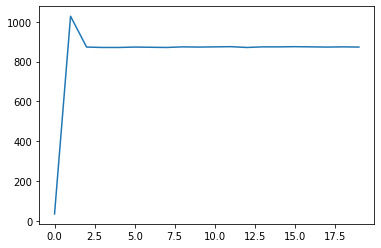

In [33]:
plt.plot(niter1)

In [34]:
k = np.argmin(niter1)
print(lambk[k])

0.0


In [35]:
lamb = lambk[k]
mu = lamb
epsi=0.1
nitermax= 3000
ux,uy,CF,step,n=RecalageGN(im2,im1,lamb,mu,nitermax,step0,epsi)

iteration : 3  cost function : 3.550829550396586 step : 0.08
iteration : 6  cost function : 3.515308509201881 step : 0.64
iteration : 9  cost function : 3.3175005862607145 step : 5.12
iteration : 12  cost function : 3.113172381809368 step : 40.96
iteration : 15  cost function : 2.7869343311277848 step : 327.68
iteration : 18  cost function : 2.3893406680031313 step : 2621.44
iteration : 21  cost function : 2.009249745276657 step : 10485.76
iteration : 24  cost function : 1.9781962400665993 step : 655.36
iteration : 27  cost function : 1.970208701083458 step : 5242.88
iteration : 30  cost function : 1.9645883197663263 step : 5242.88
iteration : 33  cost function : 1.9577136095368692 step : 655.36


on prend lambda = 10,5

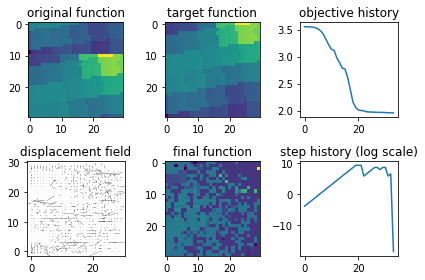

In [36]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(im2)
ax[0,0].set_title('original function')
ax[0,1].imshow(im1)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(im2,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

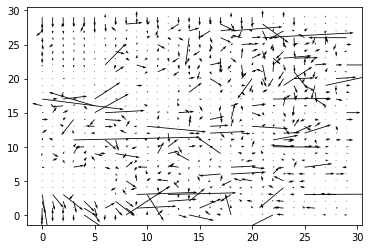

In [37]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================
Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences/déplacements entre les deux images ?

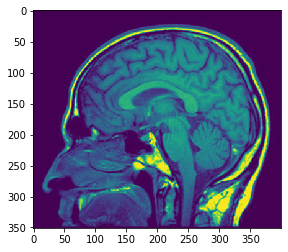

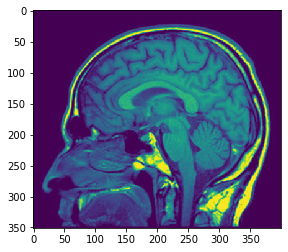

In [13]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [14]:
[n,m]=im1.size
sigma=0.1
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [ ]:
epsi=0.01
stepini=0.01
nitermax = 5000
lamb = 0.0001
mu = 0.0001
ux,uy,CF,step, niter=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)

iteration : 3  cost function : 0.14378266568826878 step : 0.08
iteration : 6  cost function : 0.1435182966307982 step : 0.64
iteration : 9  cost function : 0.1414353121976472 step : 5.12
iteration : 12  cost function : 0.12664688791055412 step : 40.96
iteration : 15  cost function : 0.07367524667918667 step : 327.68
iteration : 18  cost function : 0.054490660858069626 step : 20.48
iteration : 21  cost function : 0.053399614583654234 step : 20.48
iteration : 24  cost function : 0.053030424409352475 step : 10.24
iteration : 27  cost function : 0.05275613354759687 step : 10.24
iteration : 30  cost function : 0.05251414487138783 step : 10.24
iteration : 33  cost function : 0.05236623483392294 step : 10.24
iteration : 36  cost function : 0.05203014453222114 step : 10.24
iteration : 39  cost function : 0.05190443513327623 step : 5.12
iteration : 42  cost function : 0.051618297422295525 step : 5.12
iteration : 45  cost function : 0.05136707555049709 step : 10.24
iteration : 48  cost function 

In [ ]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()